# RESIZE IMAGE

In [223]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

def load_images_from_folder(foldername):
    images = []
    for filename in os.listdir(foldername):
        img=Image.open(os.path.join(foldername,filename)).resize((144,108))
        #img.resize((108,144))
        #img=mpimg.imread(os.path.join(foldername,filename))
        img = np.asarray(img)
        if img is not None:
            images.append(img)
    return images


In [224]:
imgs = load_images_from_folder('zelle')

In [225]:
imgs[-5].shape

(108, 144, 3)

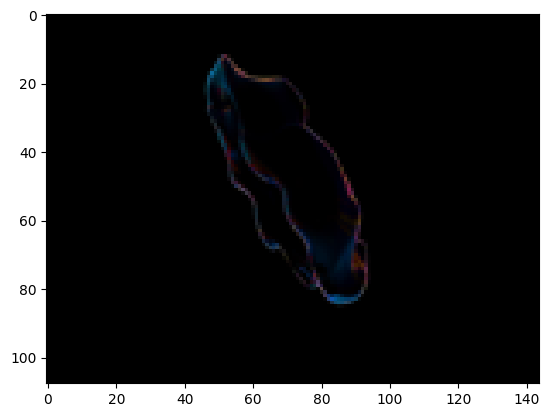

In [226]:
plt.imshow(imgs[1])

In [227]:
from tensorflow.image import resize

In [228]:
type(imgs[2])

numpy.ndarray

In [229]:
X_train = (np.array(imgs)) / 255.

In [230]:
len(X_train)

273

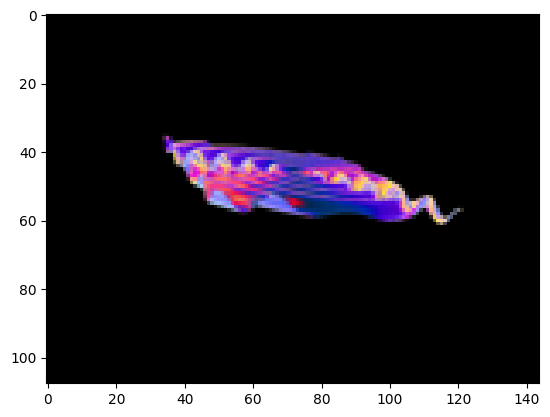

In [231]:
plt.imshow(imgs[0])

In [232]:
import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
def build_encoder(latent_dimension):
    '''returns an encoder model, of output_shape equals to latent_dimension'''

    encoder = Sequential()
    
    encoder.add(Conv2D(8, (2,2), input_shape=(108, 144, 3), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(16, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(32, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2))     

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension, activation='tanh'))
    
    return encoder

In [233]:
encoder = build_encoder(latent_dimension=2)

In [234]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose
def build_decoder(latent_dimension):
    # $CHALLENGIFY_BEGIN
    decoder = Sequential()
    decoder.add(Dense(3*4*8, activation='tanh', input_shape=(latent_dimension,)))
    decoder.add(Reshape((3, 4, 8)))  # no batch axis here
    decoder.add(Conv2DTranspose(8, (2, 2), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(8, (2, 2), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(8, (3, 3), strides=3, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(3, (3, 3), strides=3, padding='same', activation='relu'))
    
    return decoder

In [235]:
encoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 107, 143, 8)       104       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 53, 71, 8)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 70, 16)        528       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 35, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 34, 32)        2080      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 12, 17, 32)      

In [236]:
decoder = build_decoder(2)

In [237]:
decoder.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 96)                288       
                                                                 
 reshape_3 (Reshape)         (None, 3, 4, 8)           0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 6, 8, 8)          264       
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 12, 16, 8)        264       
 Transpose)                                                      
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 36, 48, 8)        584       
 Transpose)                                                      
                                                      

In [238]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
def build_autoencoder(encoder, decoder):
    inp = Input((108, 144, 3))
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

autoencoder = build_autoencoder(encoder, decoder)

In [239]:
def compile_autoencoder(autoencoder):
    autoencoder.compile(loss='mse', optimizer='adam')

In [240]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10)

compile_autoencoder(autoencoder)
autoencoder.fit(X_train, X_train, epochs = 1000, batch_size = 32, callbacks=[es])

Epoch 1/1000
9/9 [==============================] - 1s 30ms/step - loss: 0.0257
Epoch 2/1000
9/9 [==============================] - 0s 29ms/step - loss: 0.0248
Epoch 3/1000
9/9 [==============================] - 0s 29ms/step - loss: 0.0242
Epoch 4/1000
9/9 [==============================] - 0s 28ms/step - loss: 0.0238
Epoch 5/1000
9/9 [==============================] - 0s 28ms/step - loss: 0.0235
Epoch 6/1000
9/9 [==============================] - 0s 27ms/step - loss: 0.0234
Epoch 7/1000
9/9 [==============================] - 0s 28ms/step - loss: 0.0232
Epoch 8/1000
9/9 [==============================] - 0s 29ms/step - loss: 0.0231
Epoch 9/1000
9/9 [==============================] - 0s 26ms/step - loss: 0.0230
Epoch 10/1000
9/9 [==============================] - 0s 26ms/step - loss: 0.0228
Epoch 11/1000
9/9 [==============================] - 0s 27ms/step - loss: 0.0225
Epoch 12/1000
9/9 [==============================] - 0s 26ms/step - loss: 0.0220
Epoch 13/1000
9/9 [==================

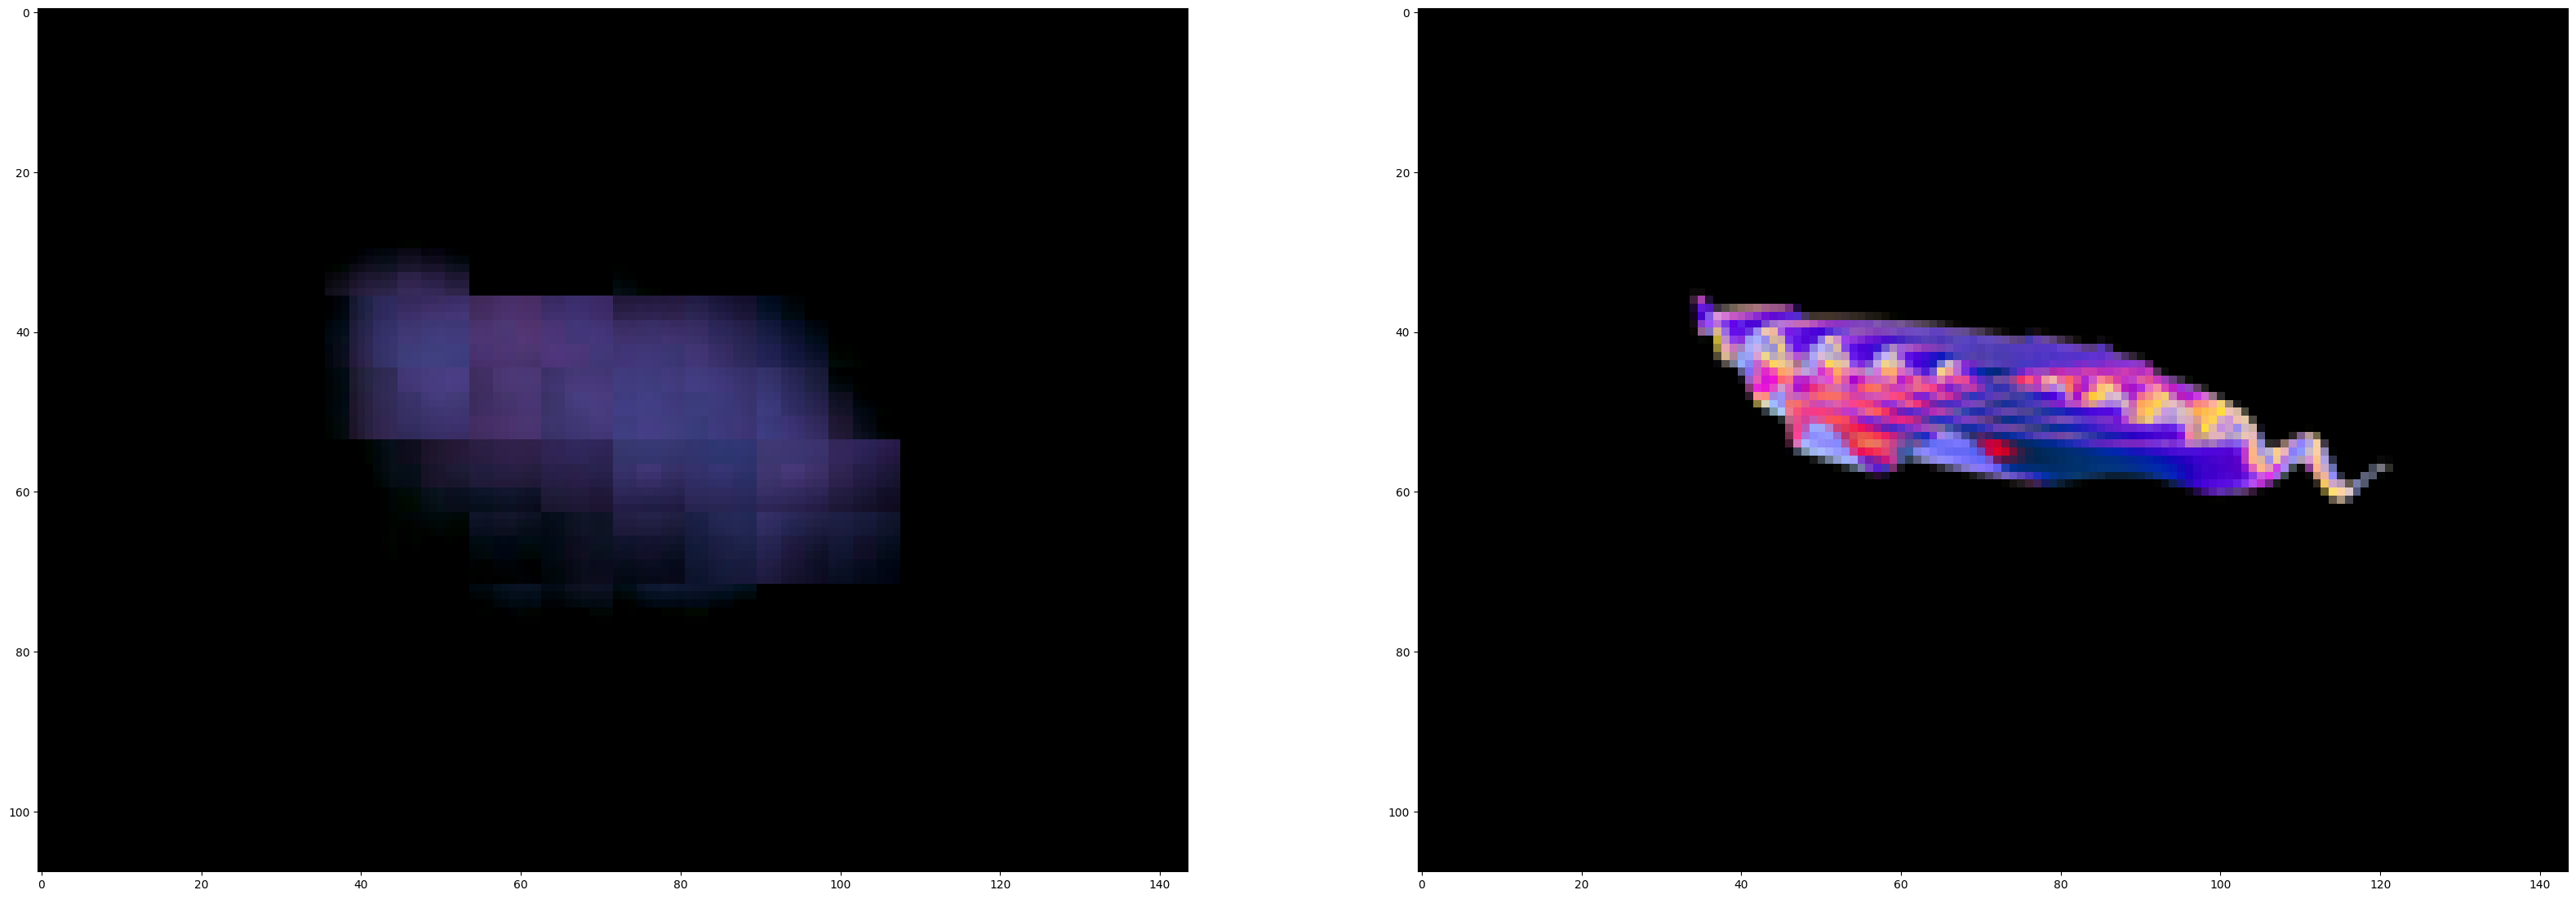

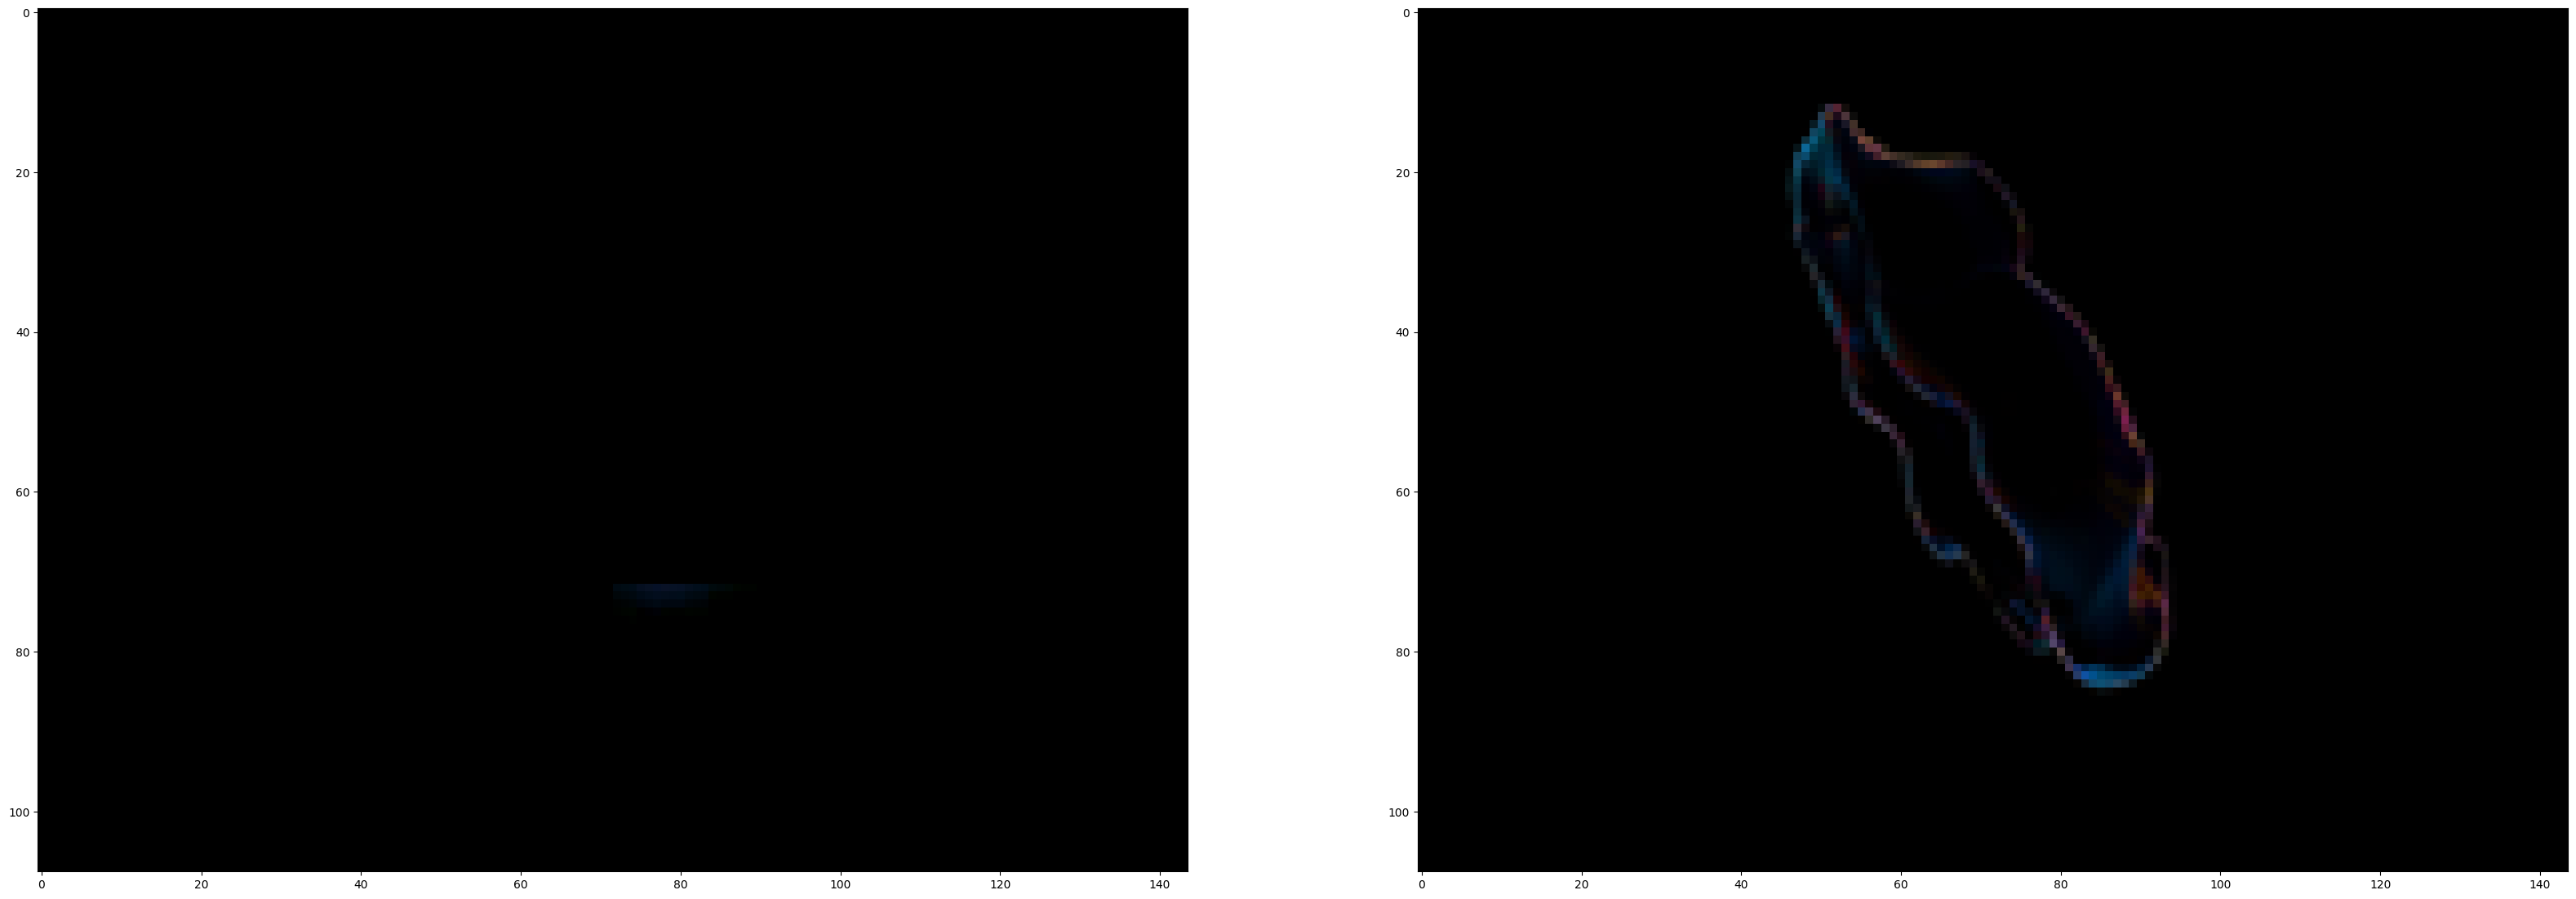

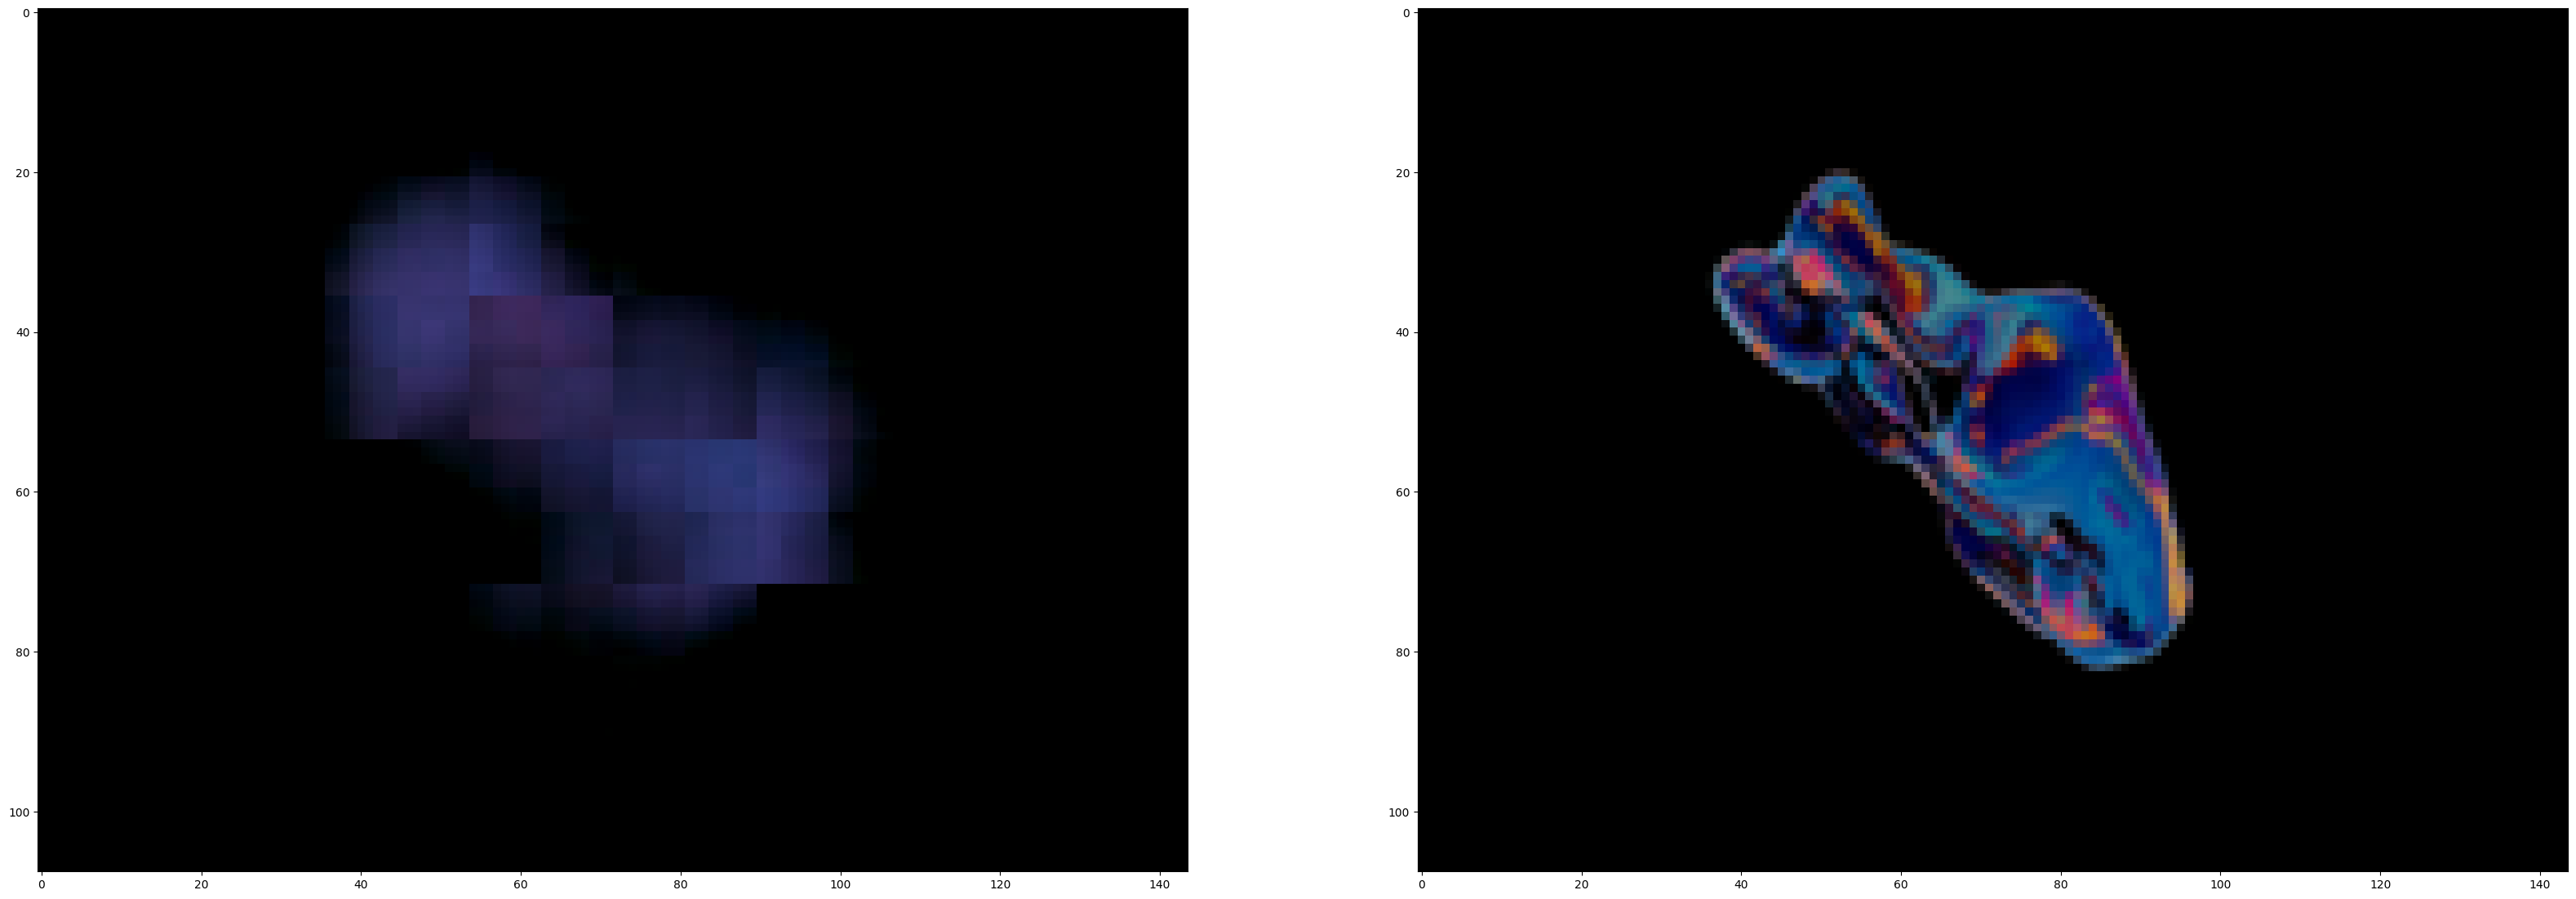

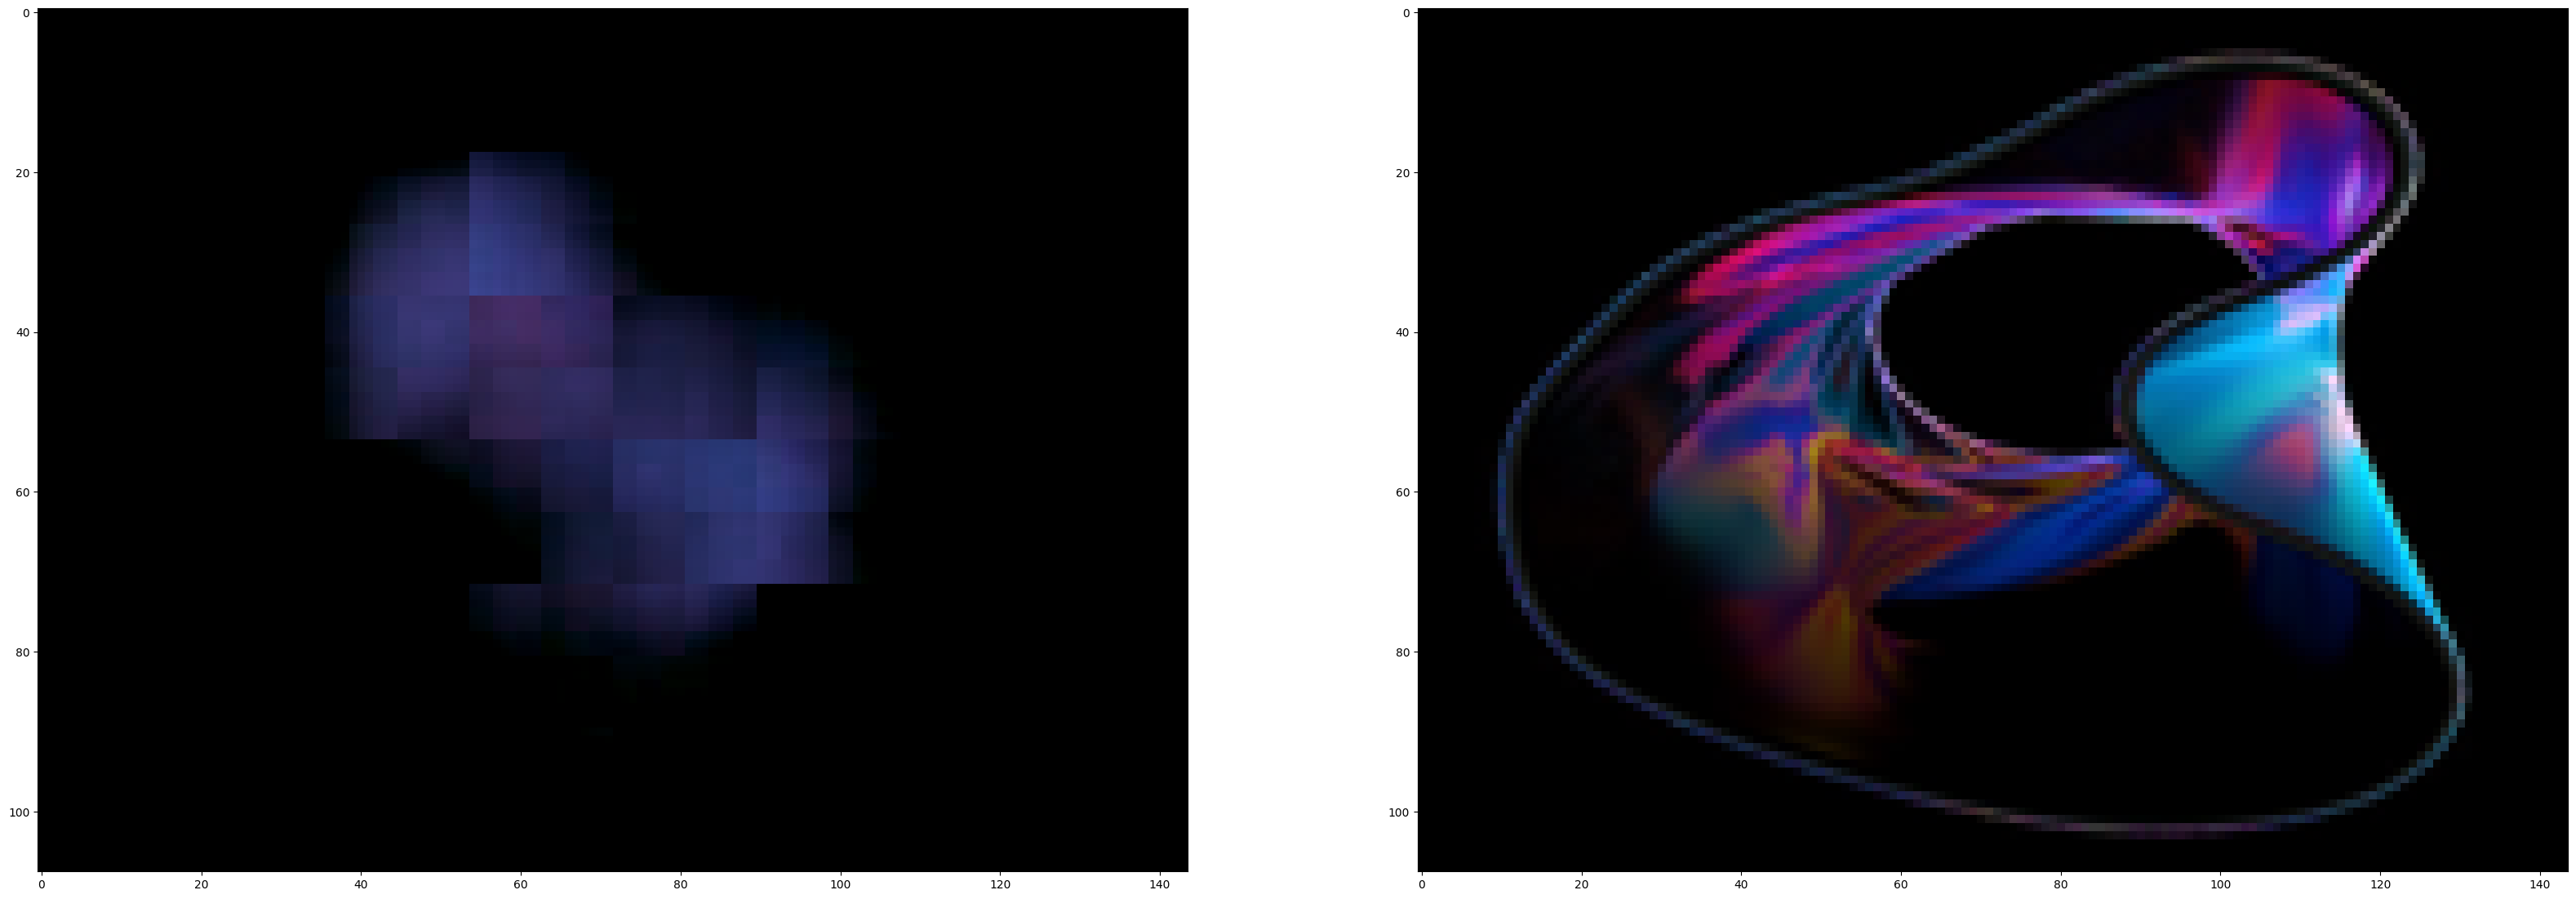

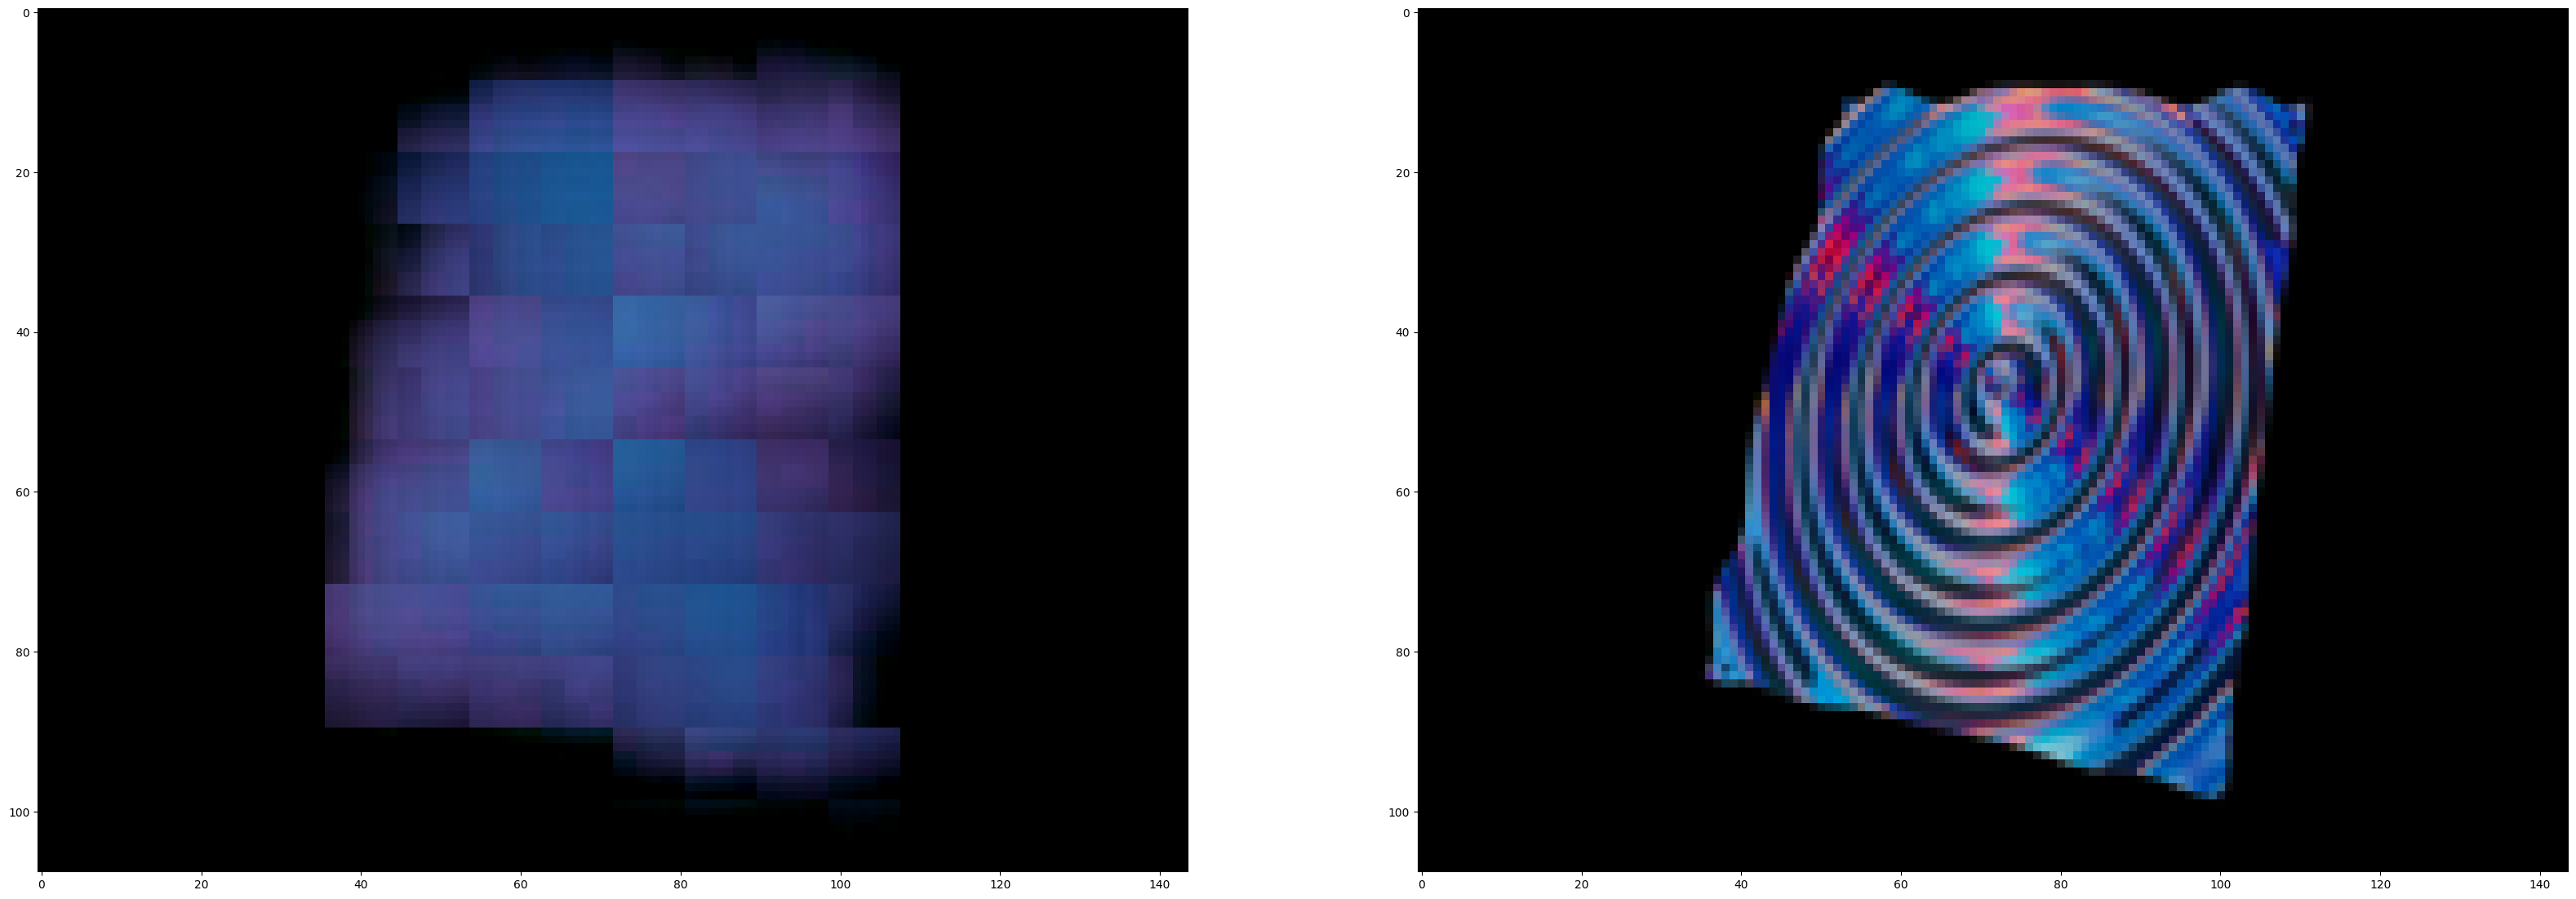

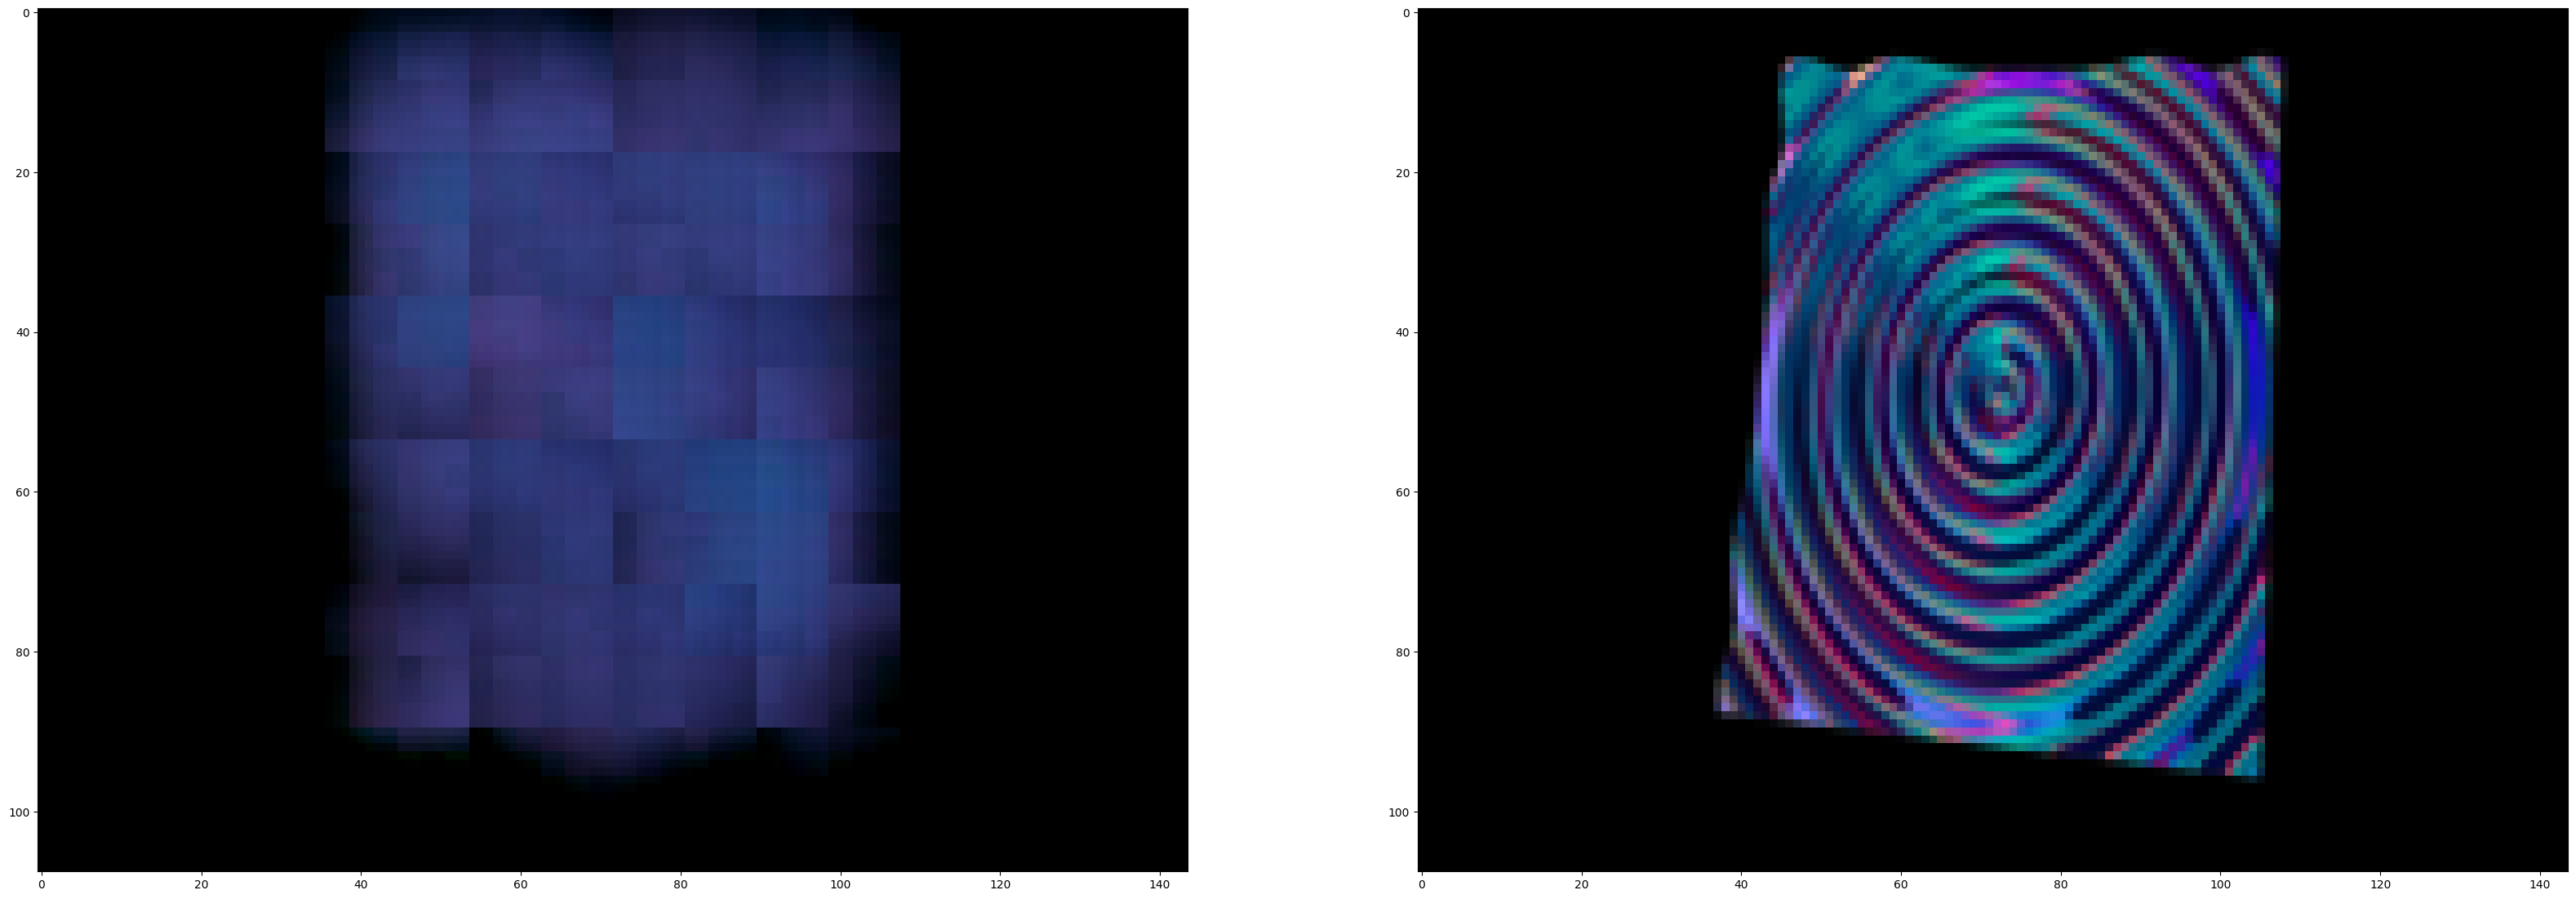

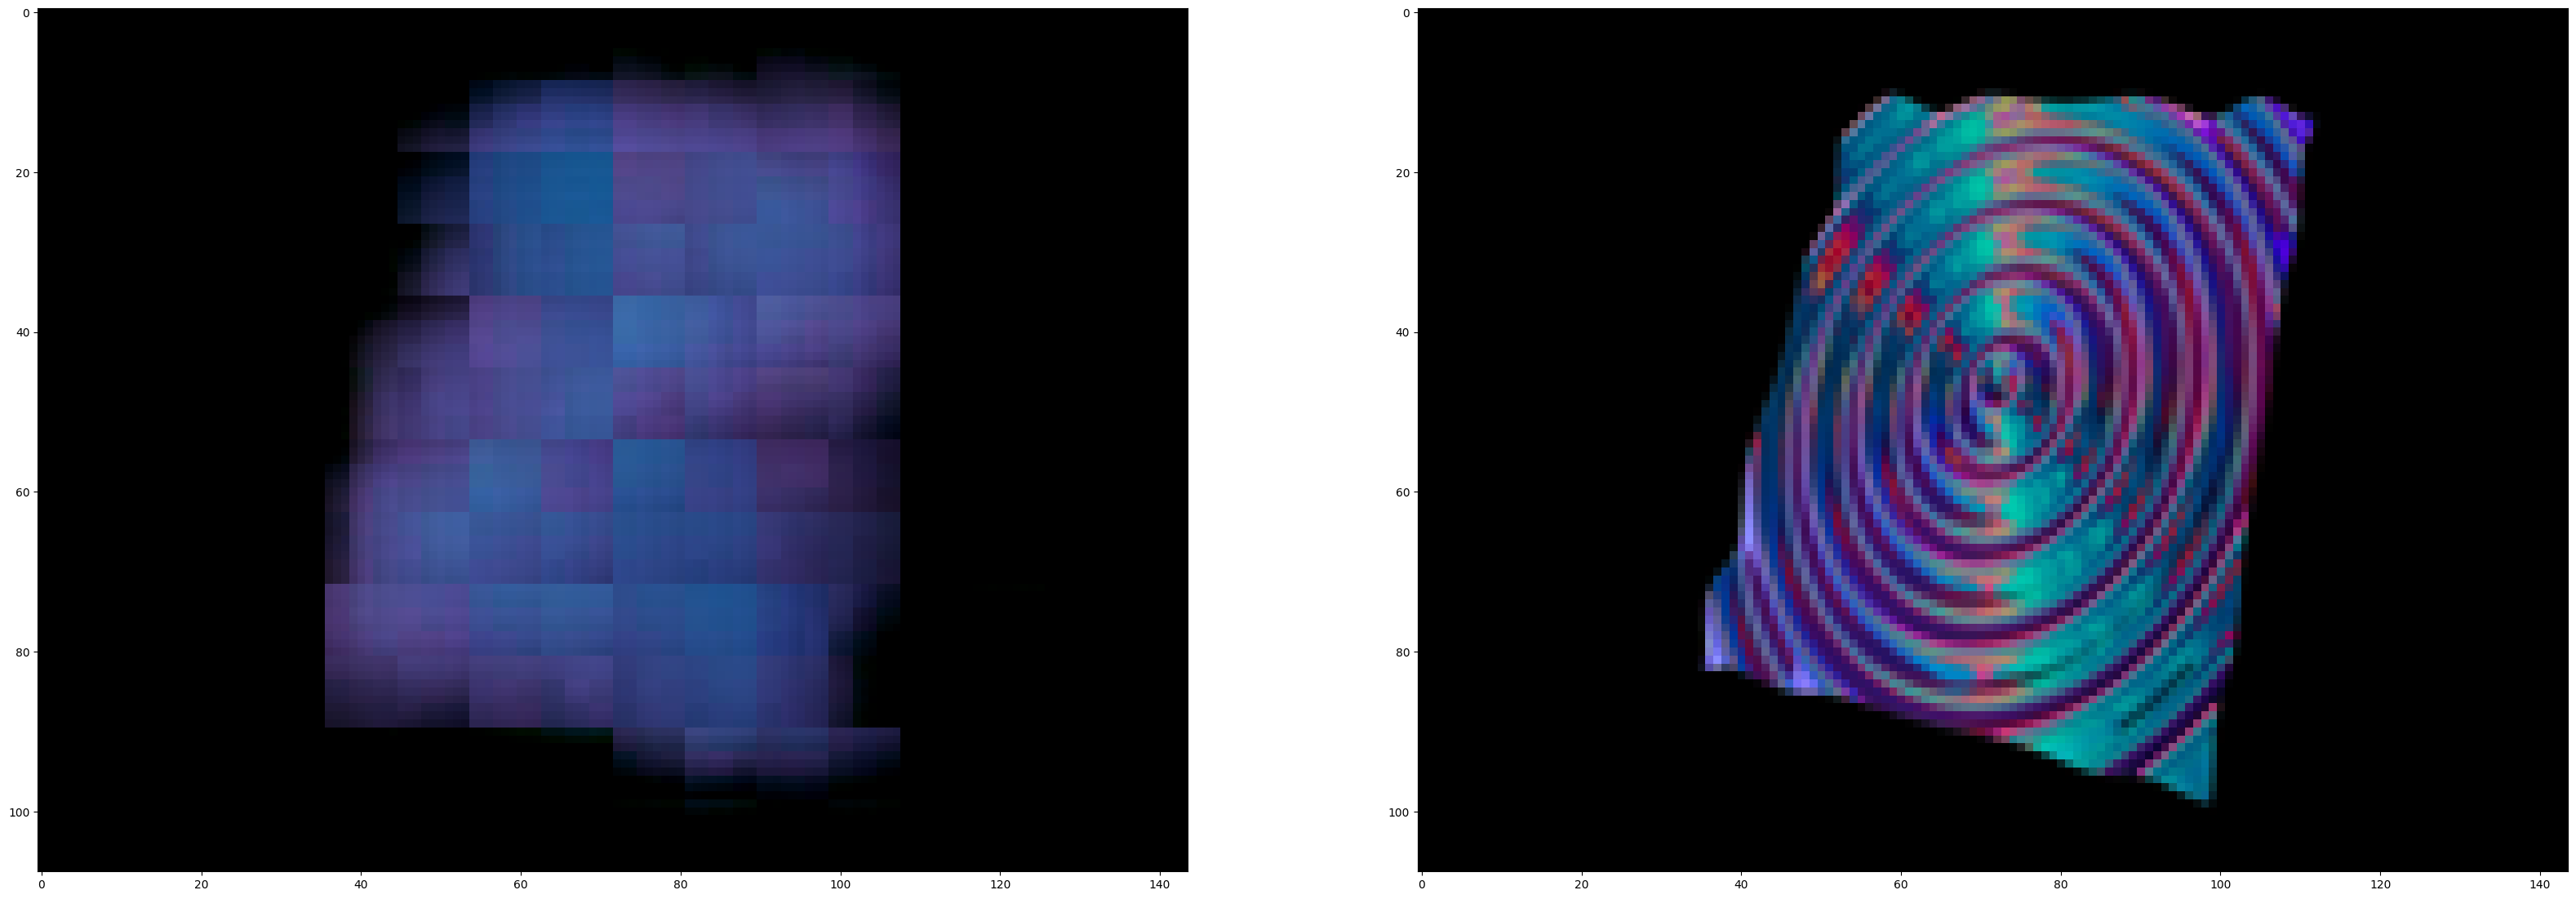

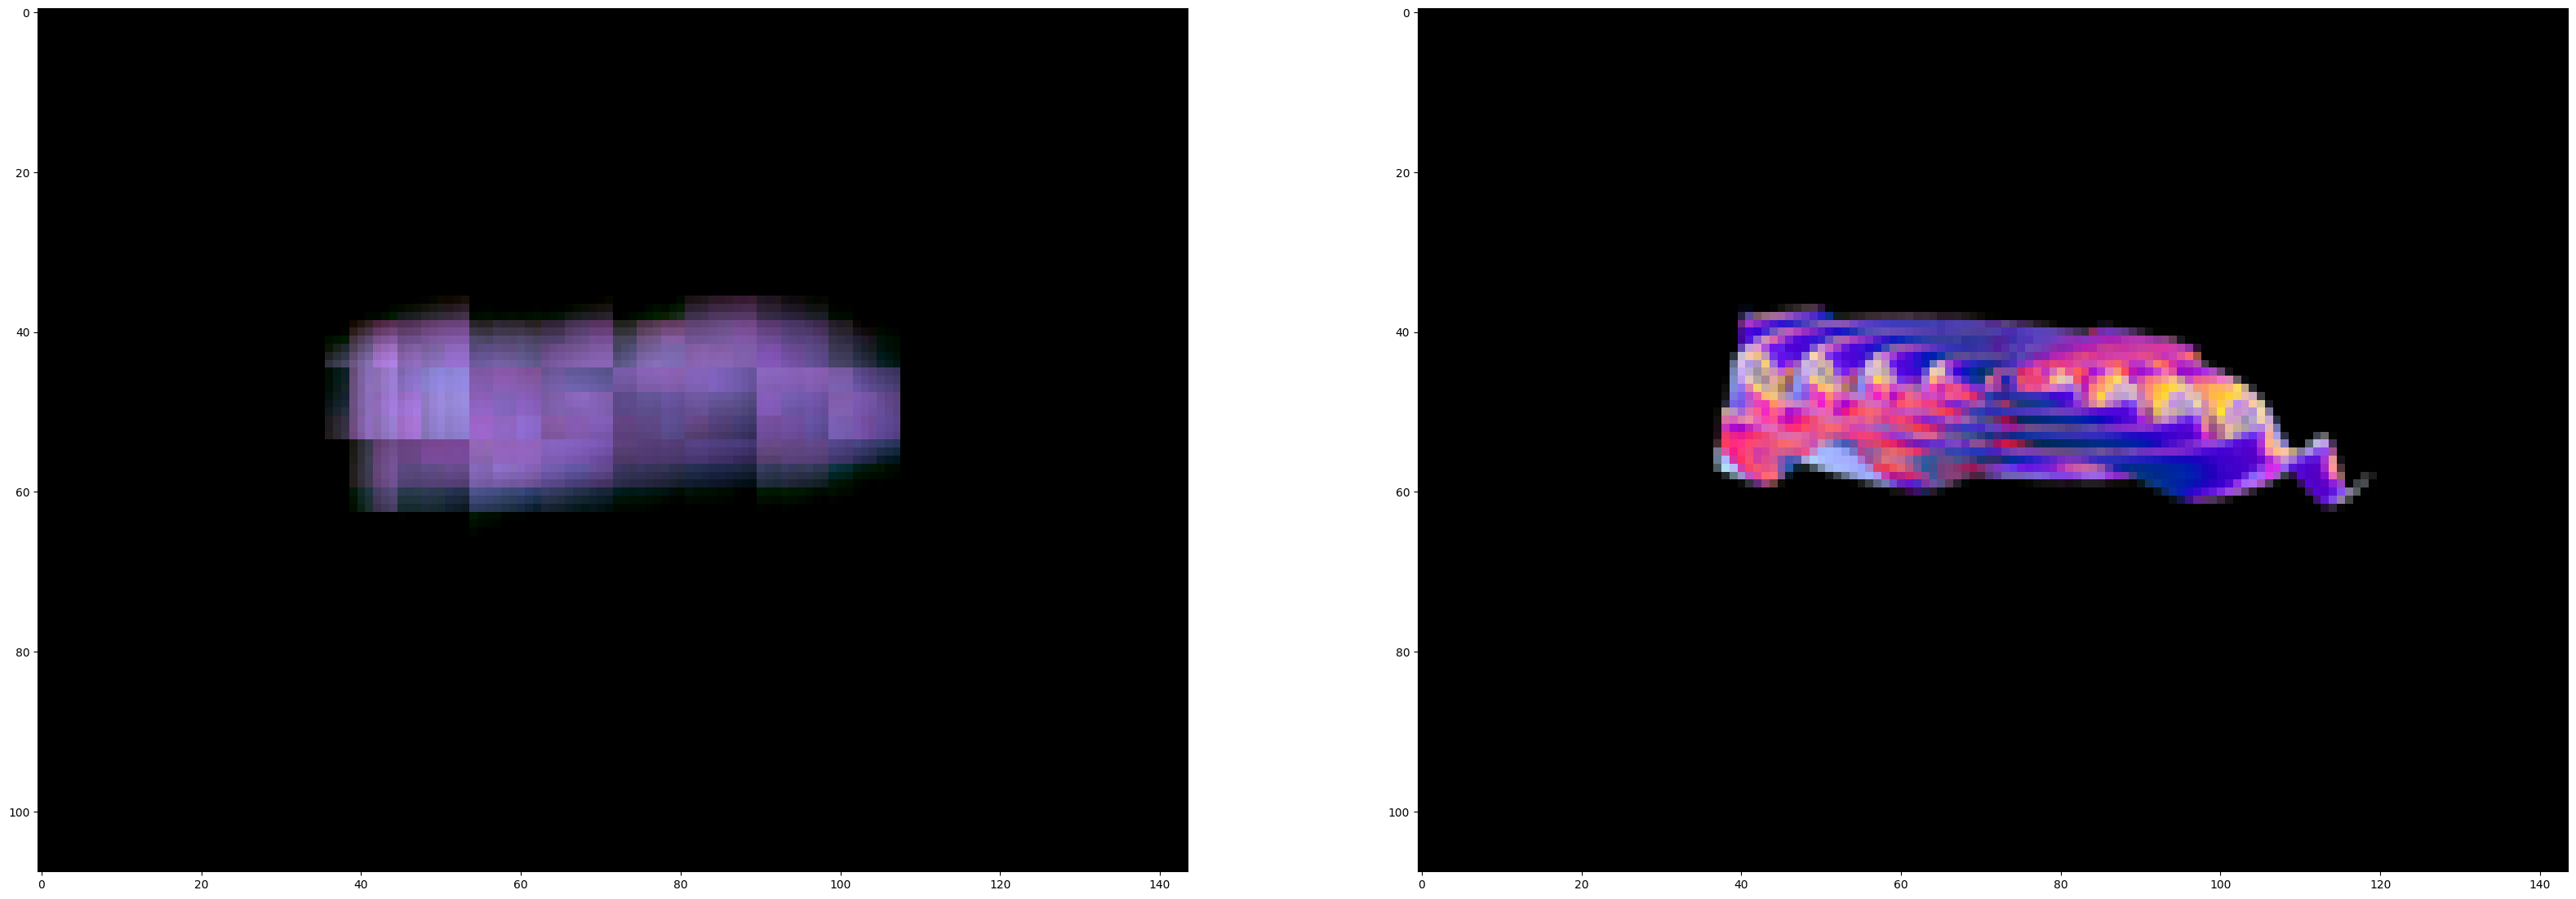

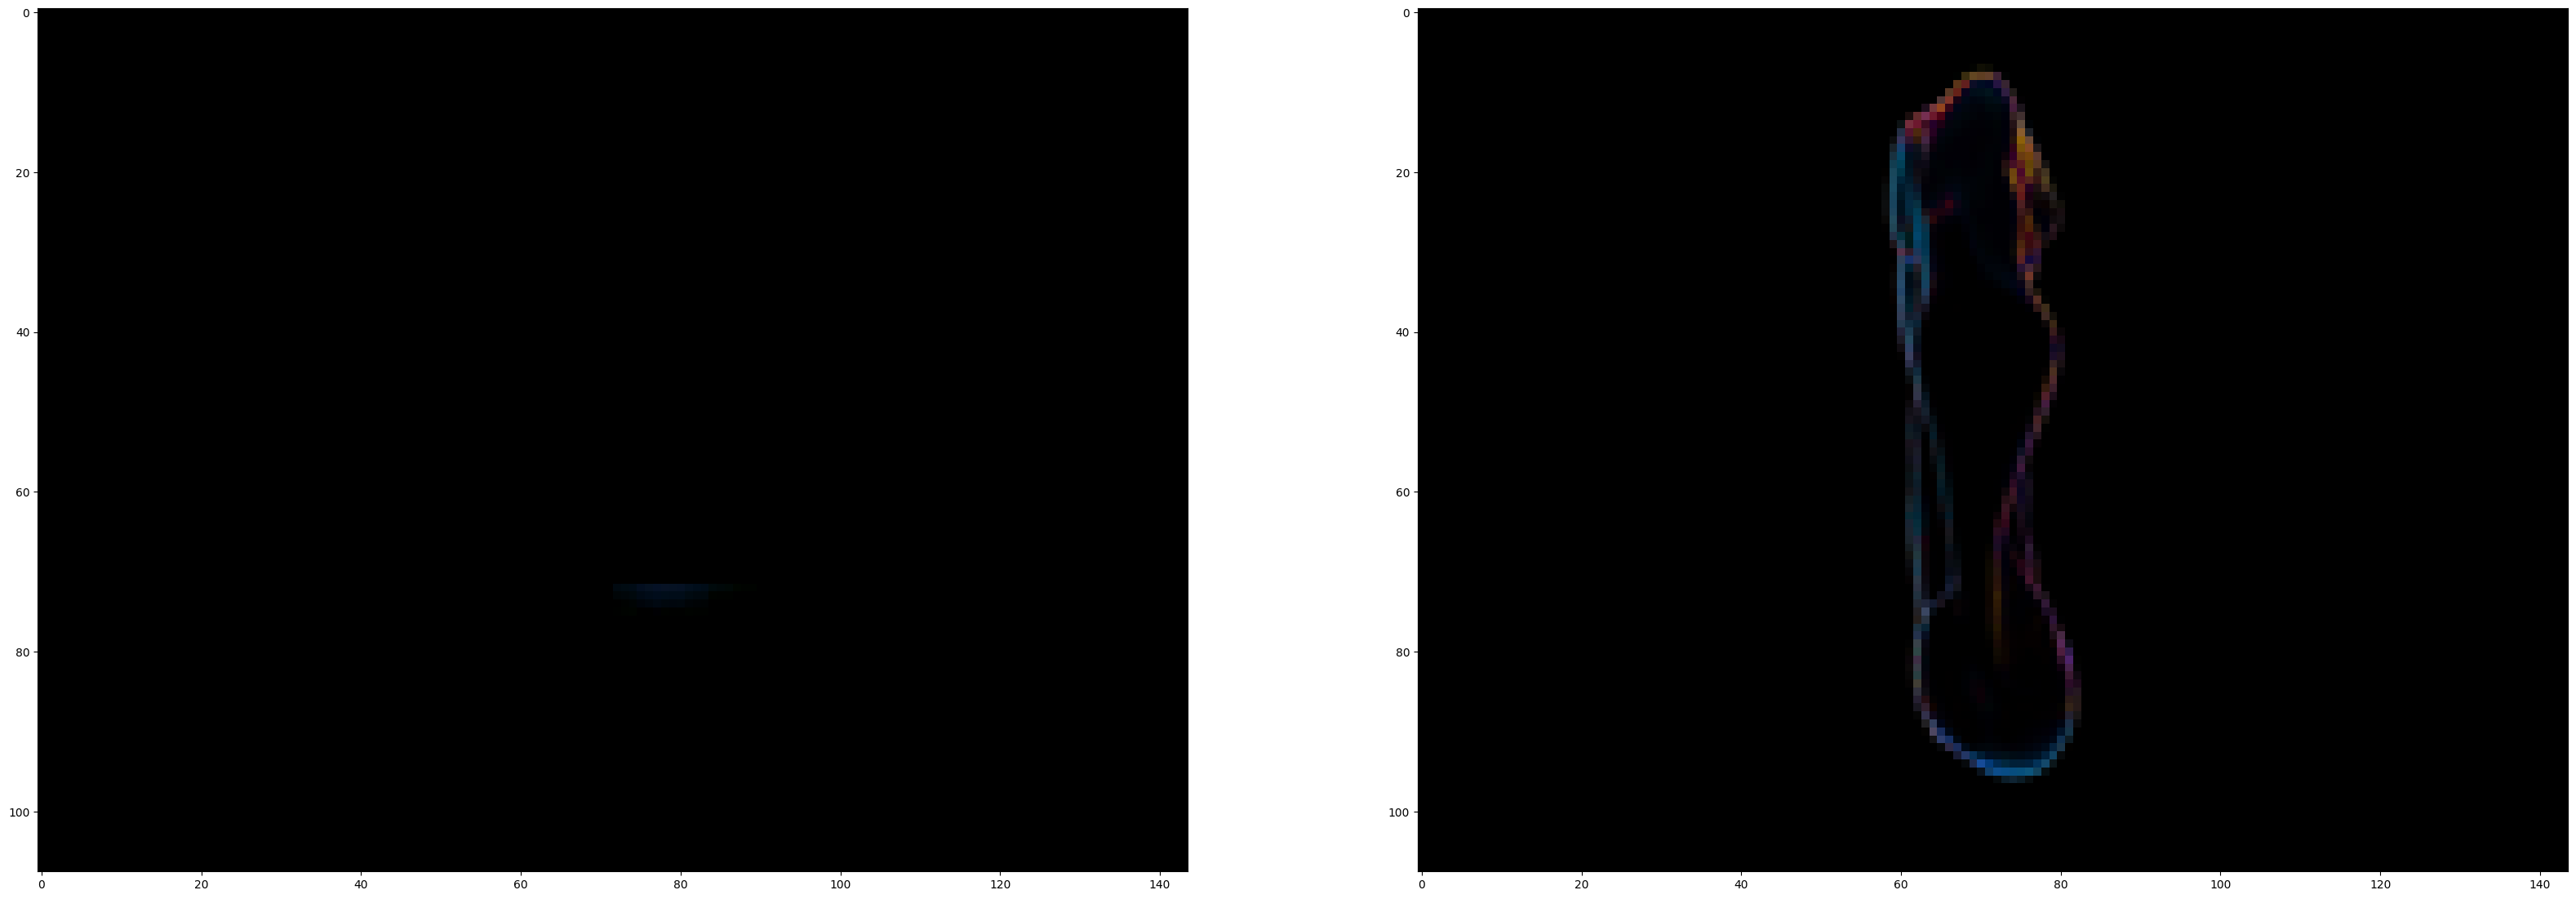

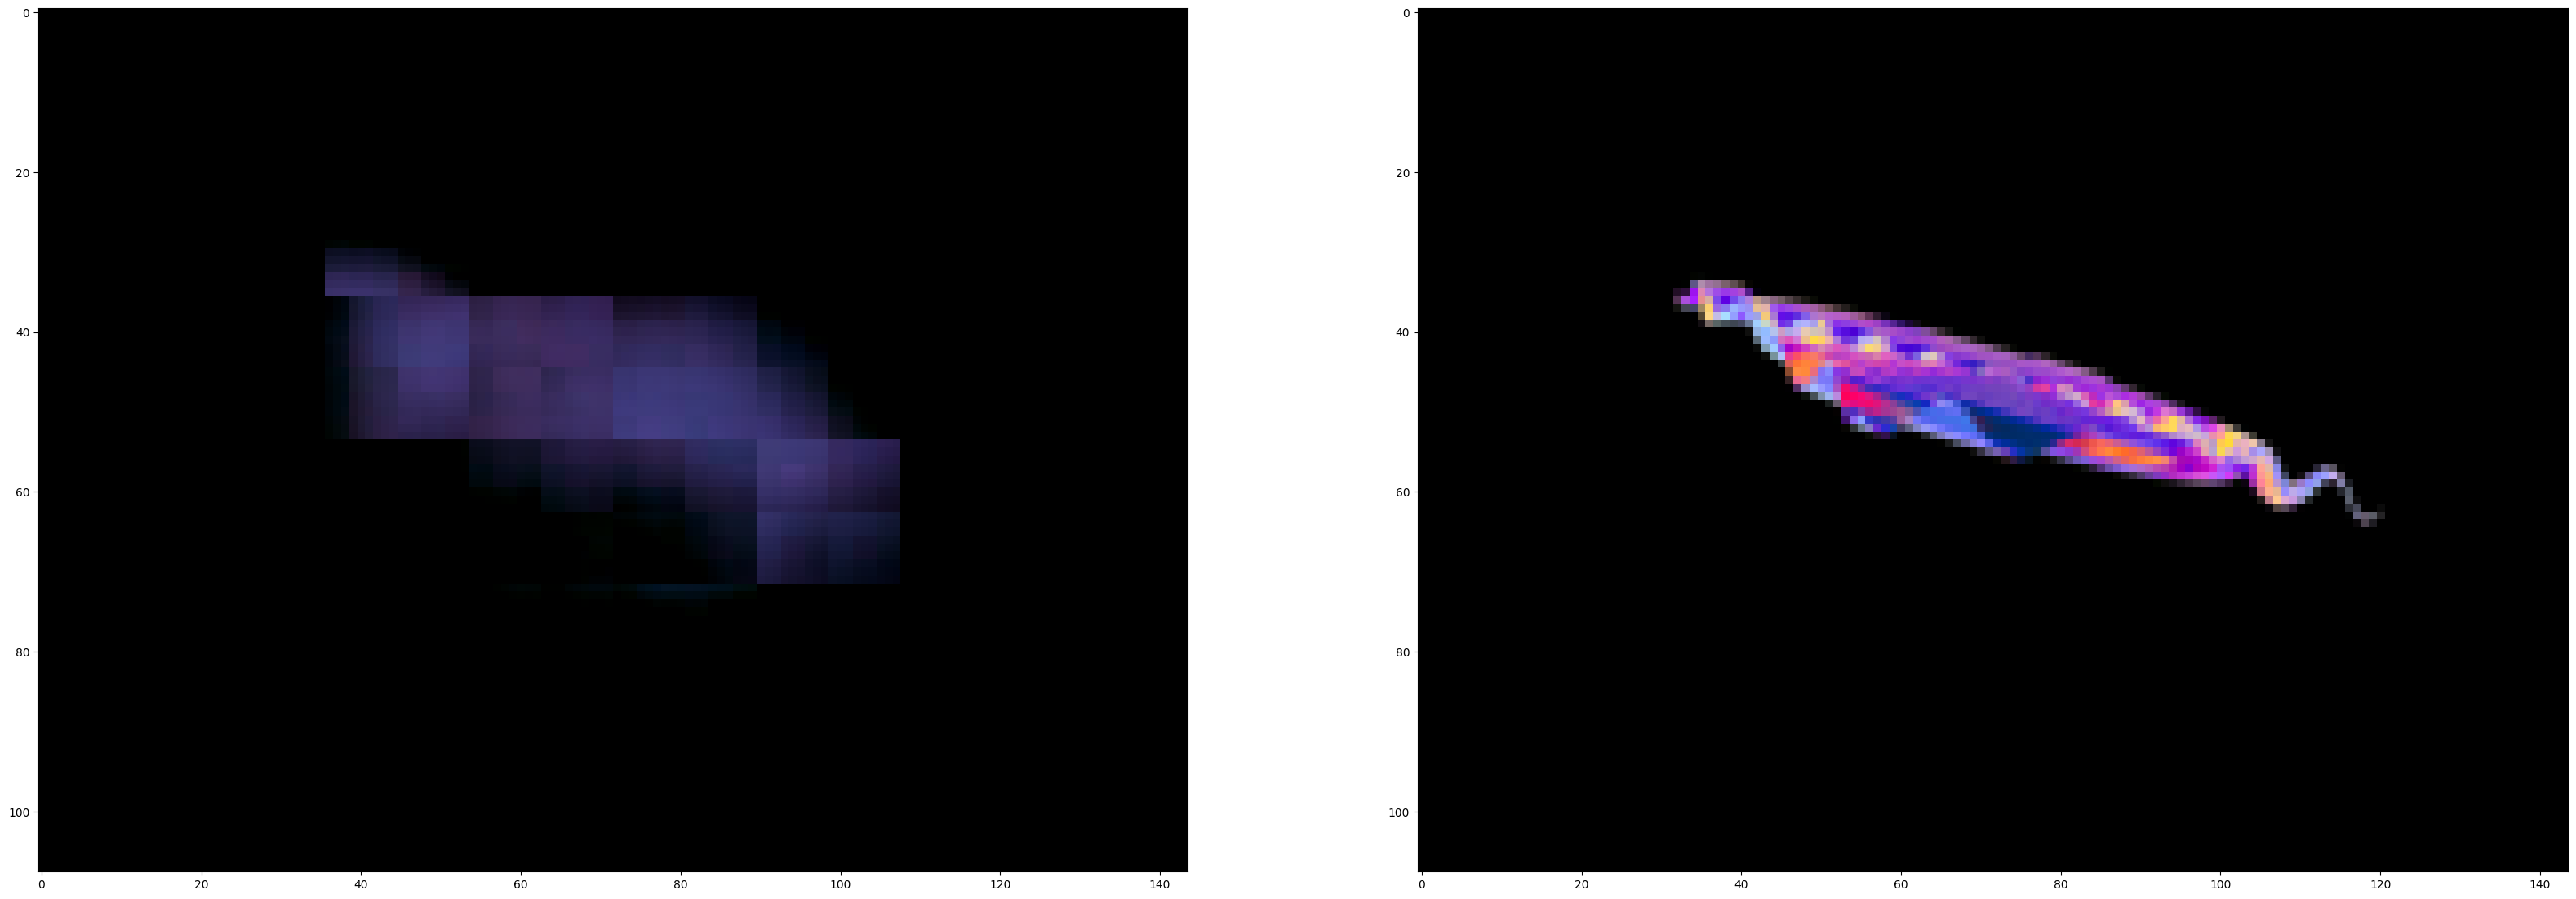

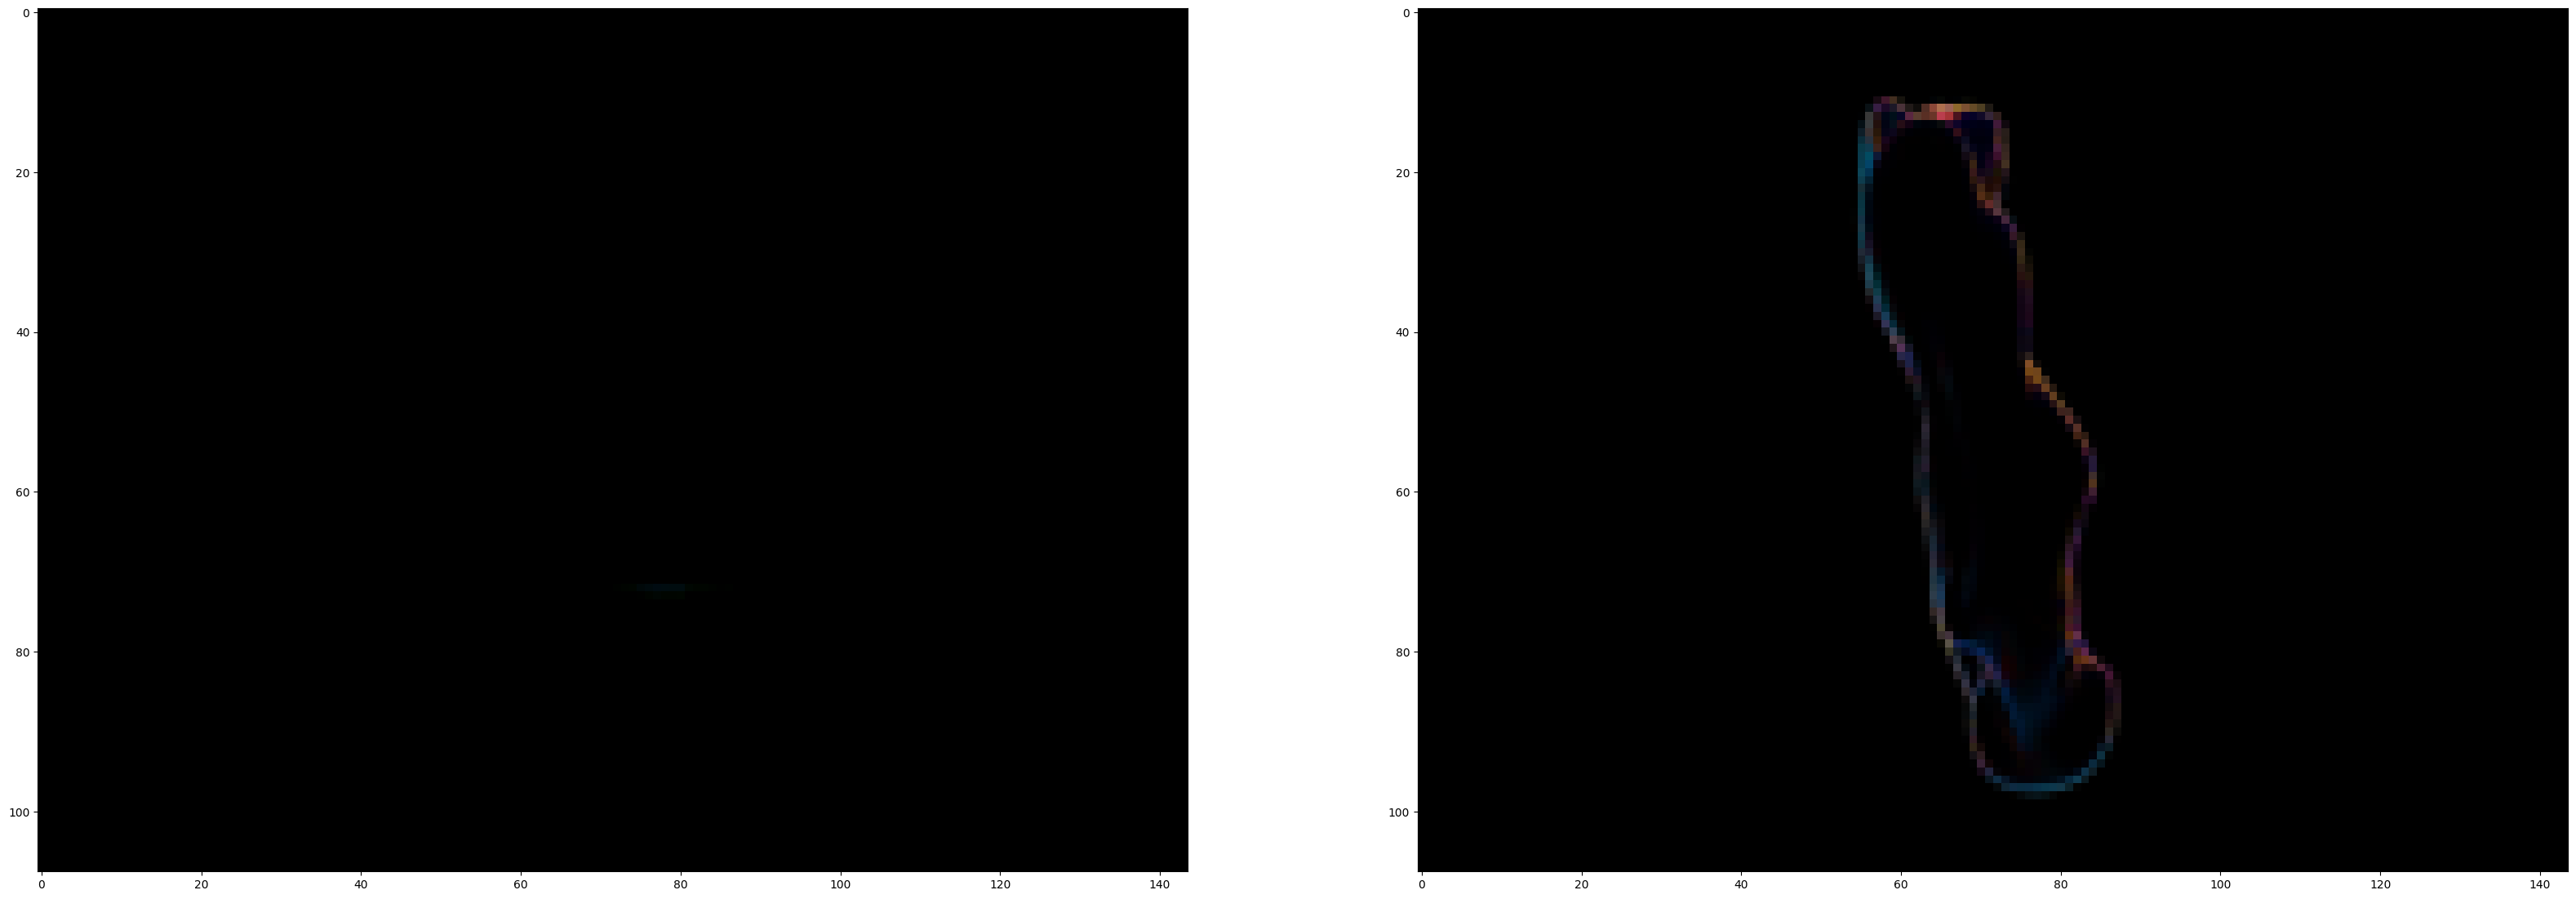

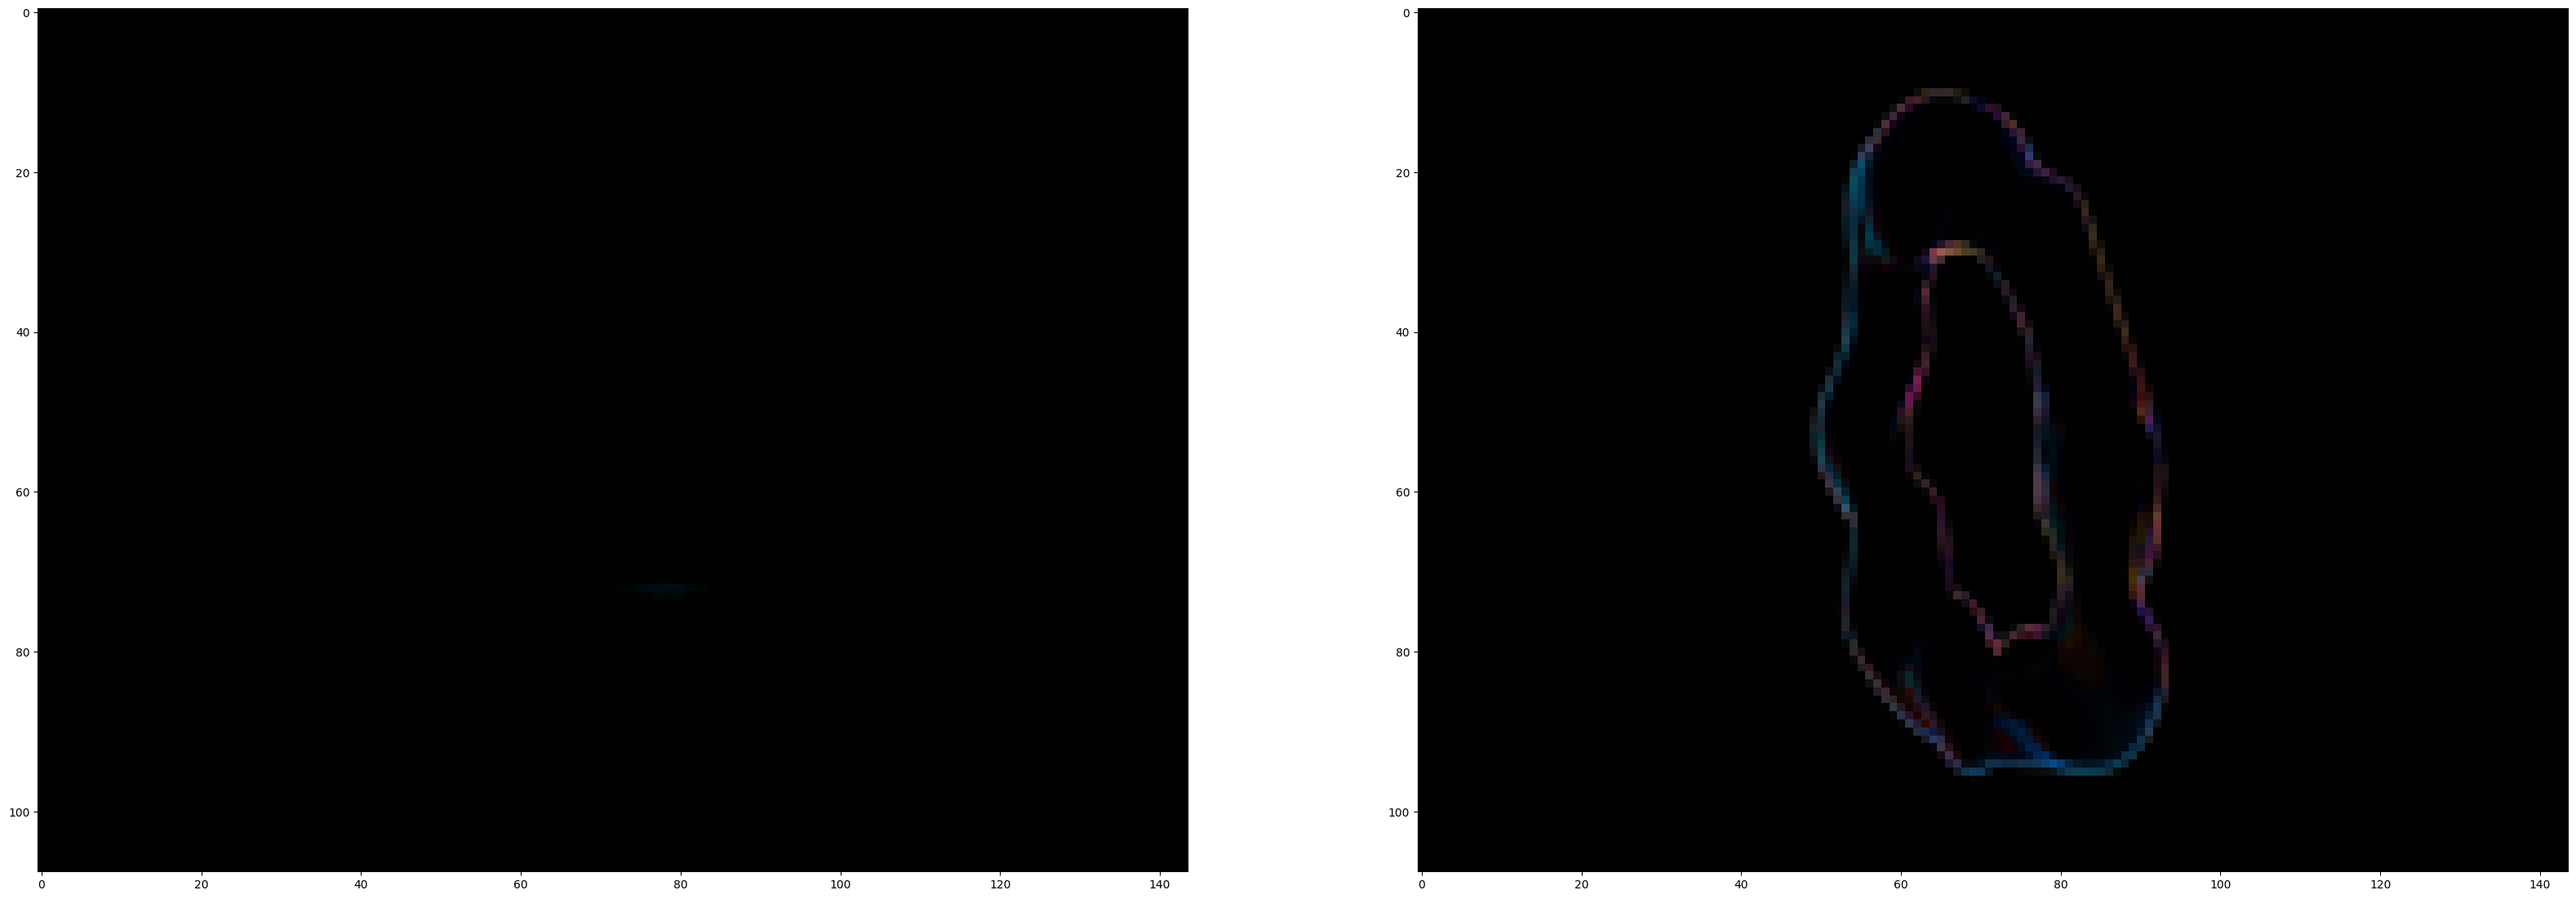

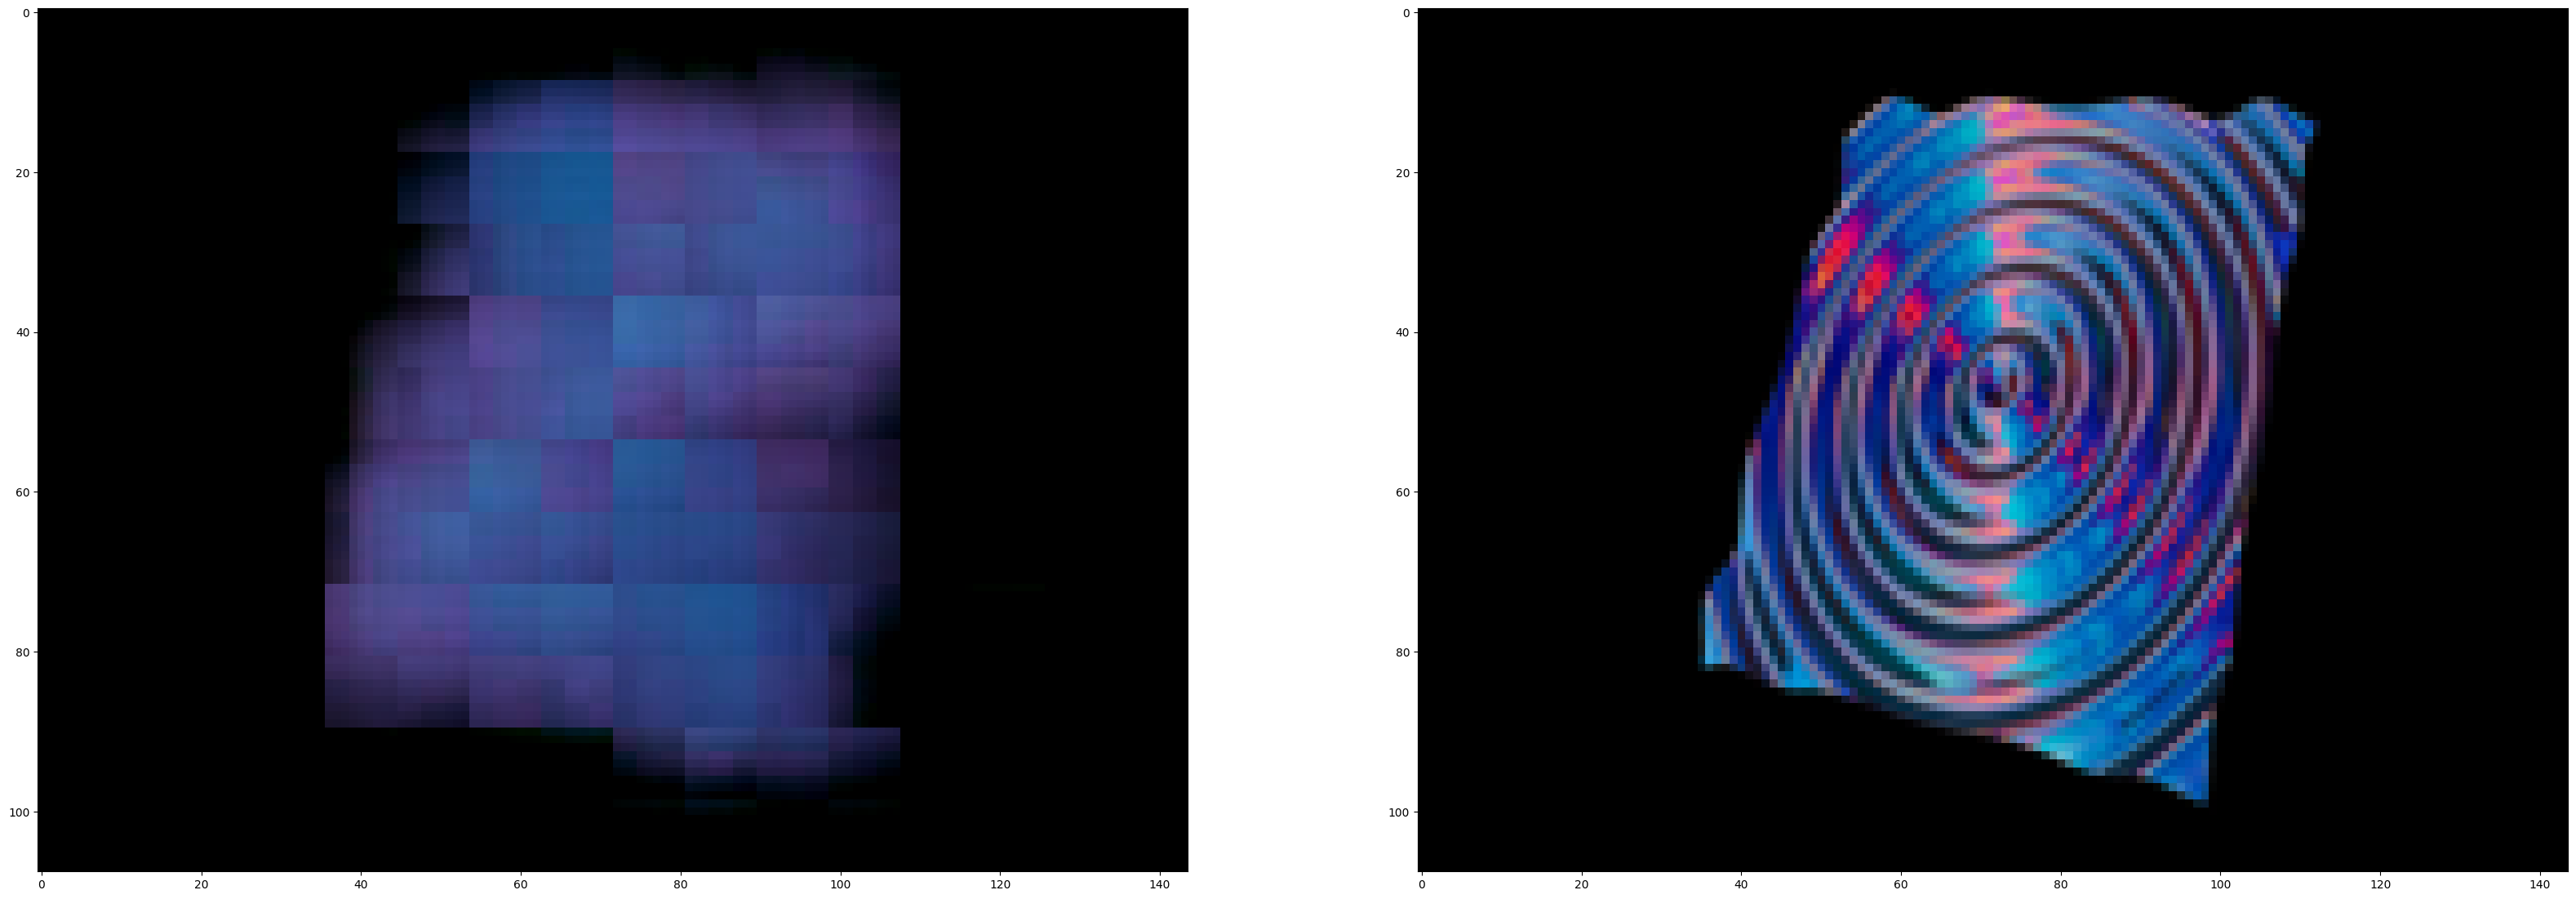

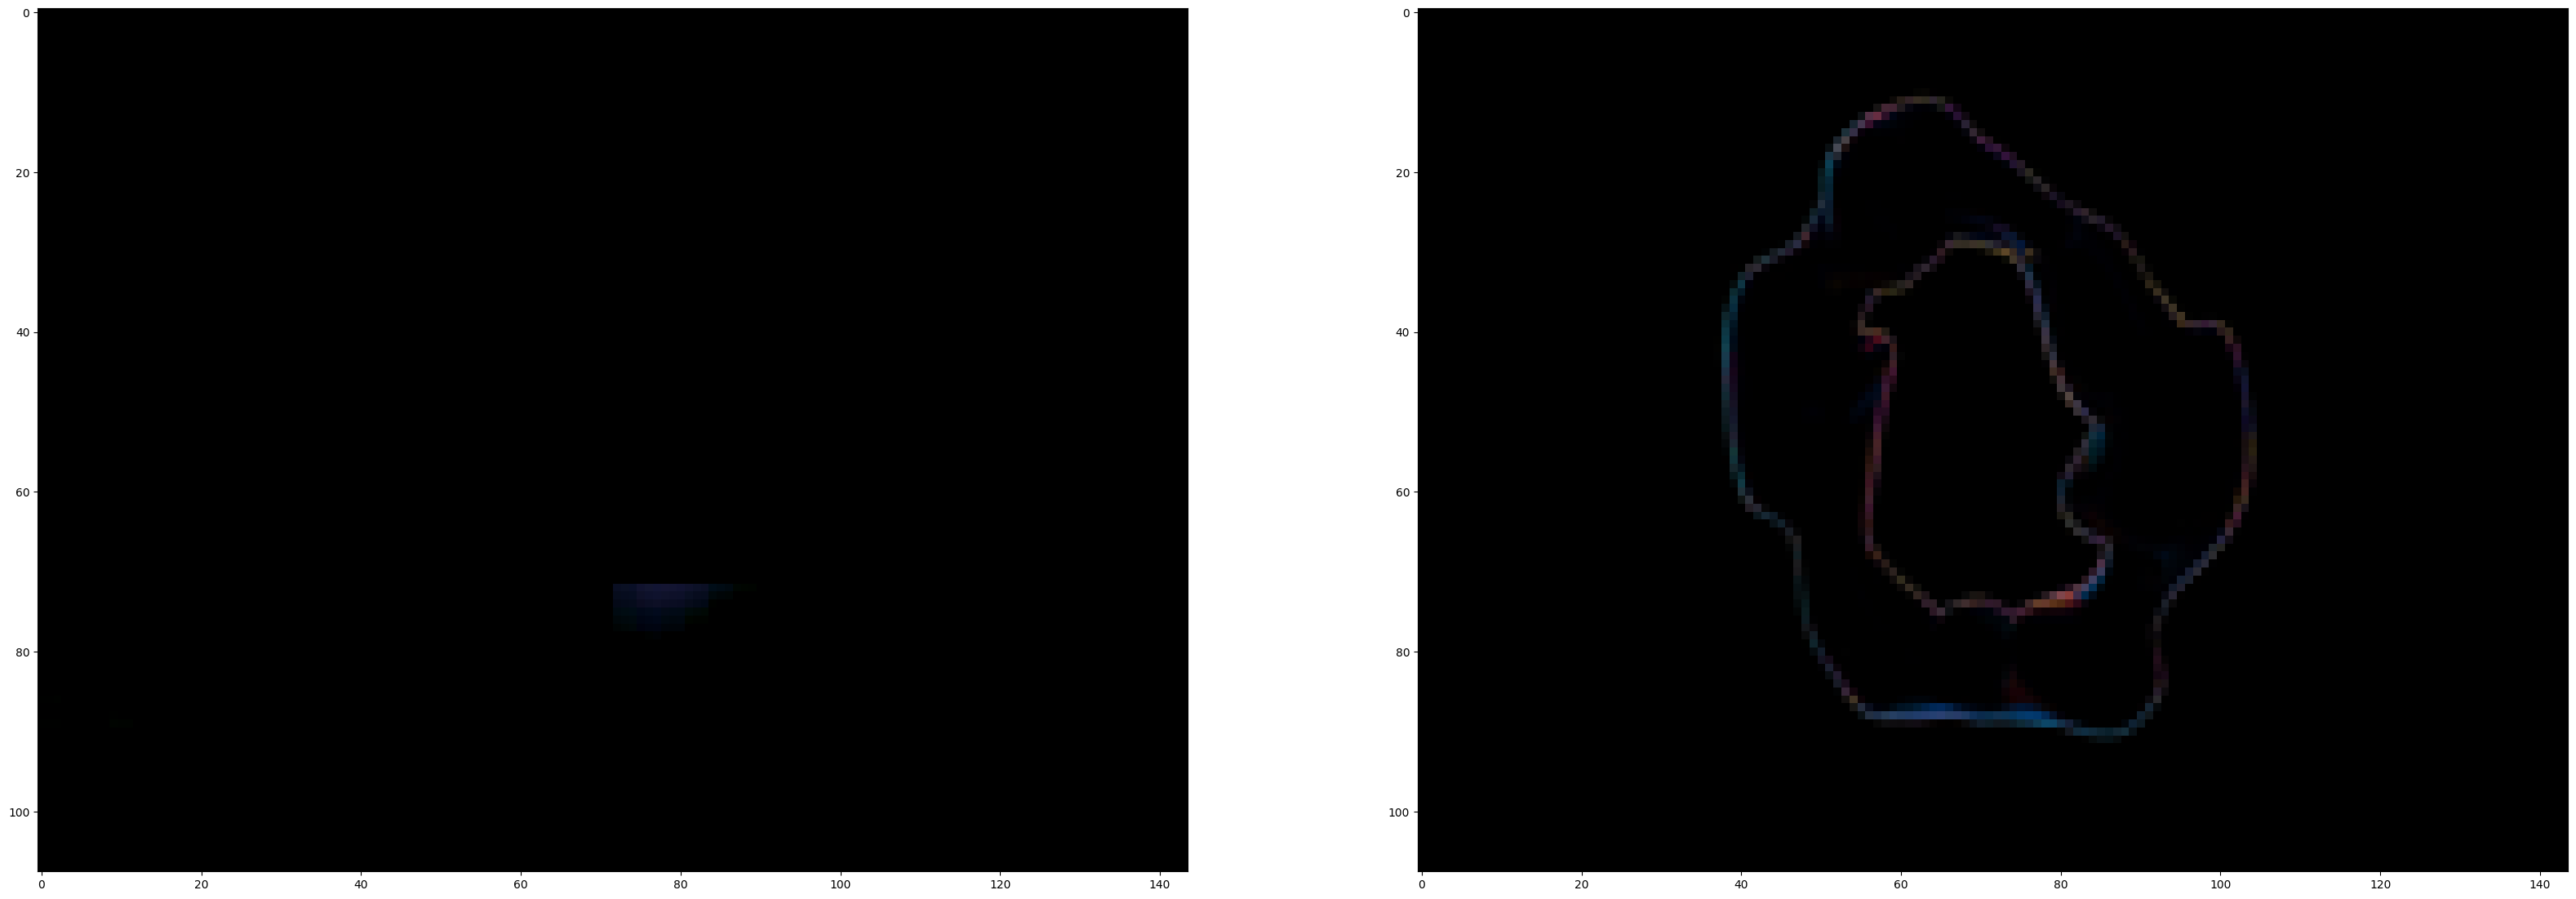

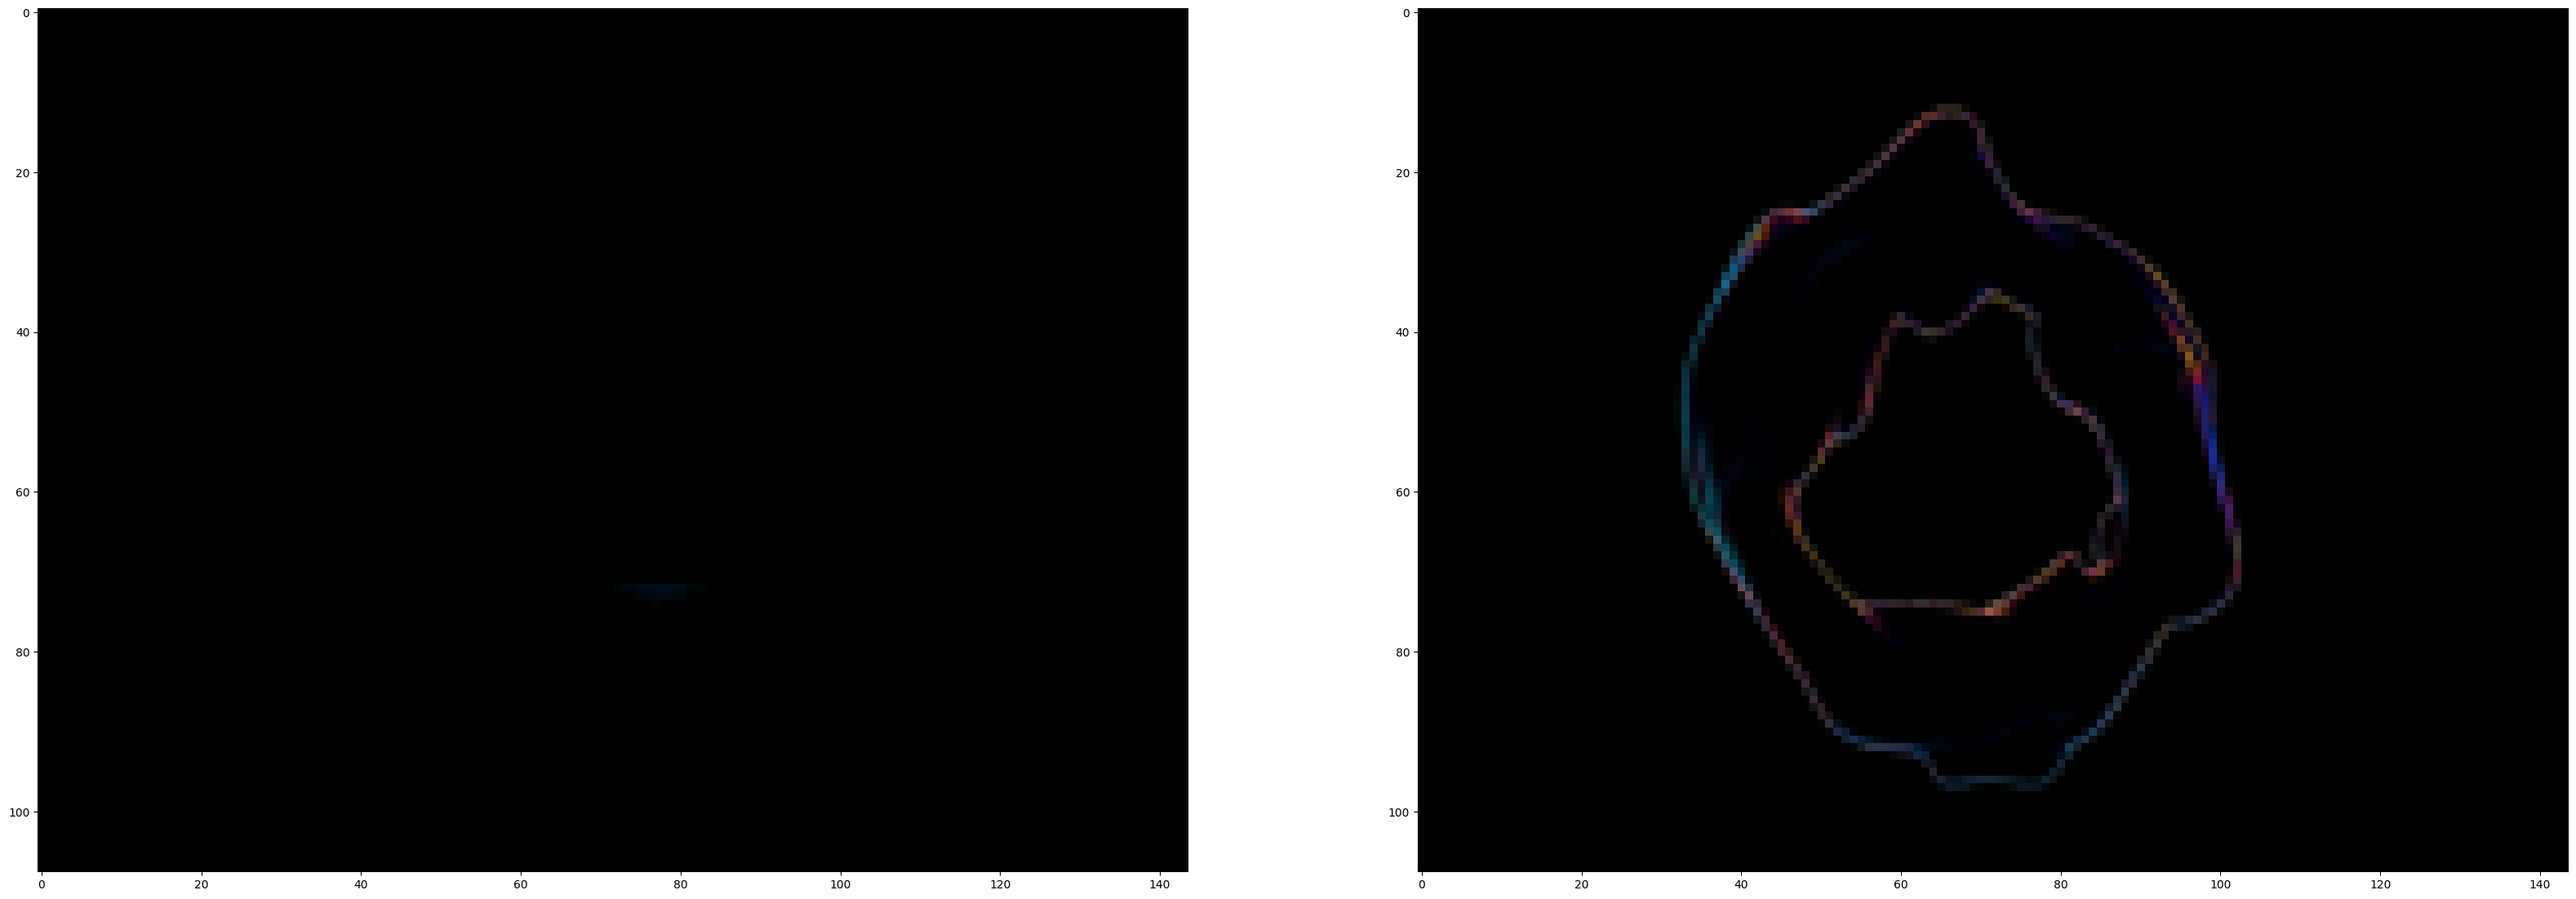

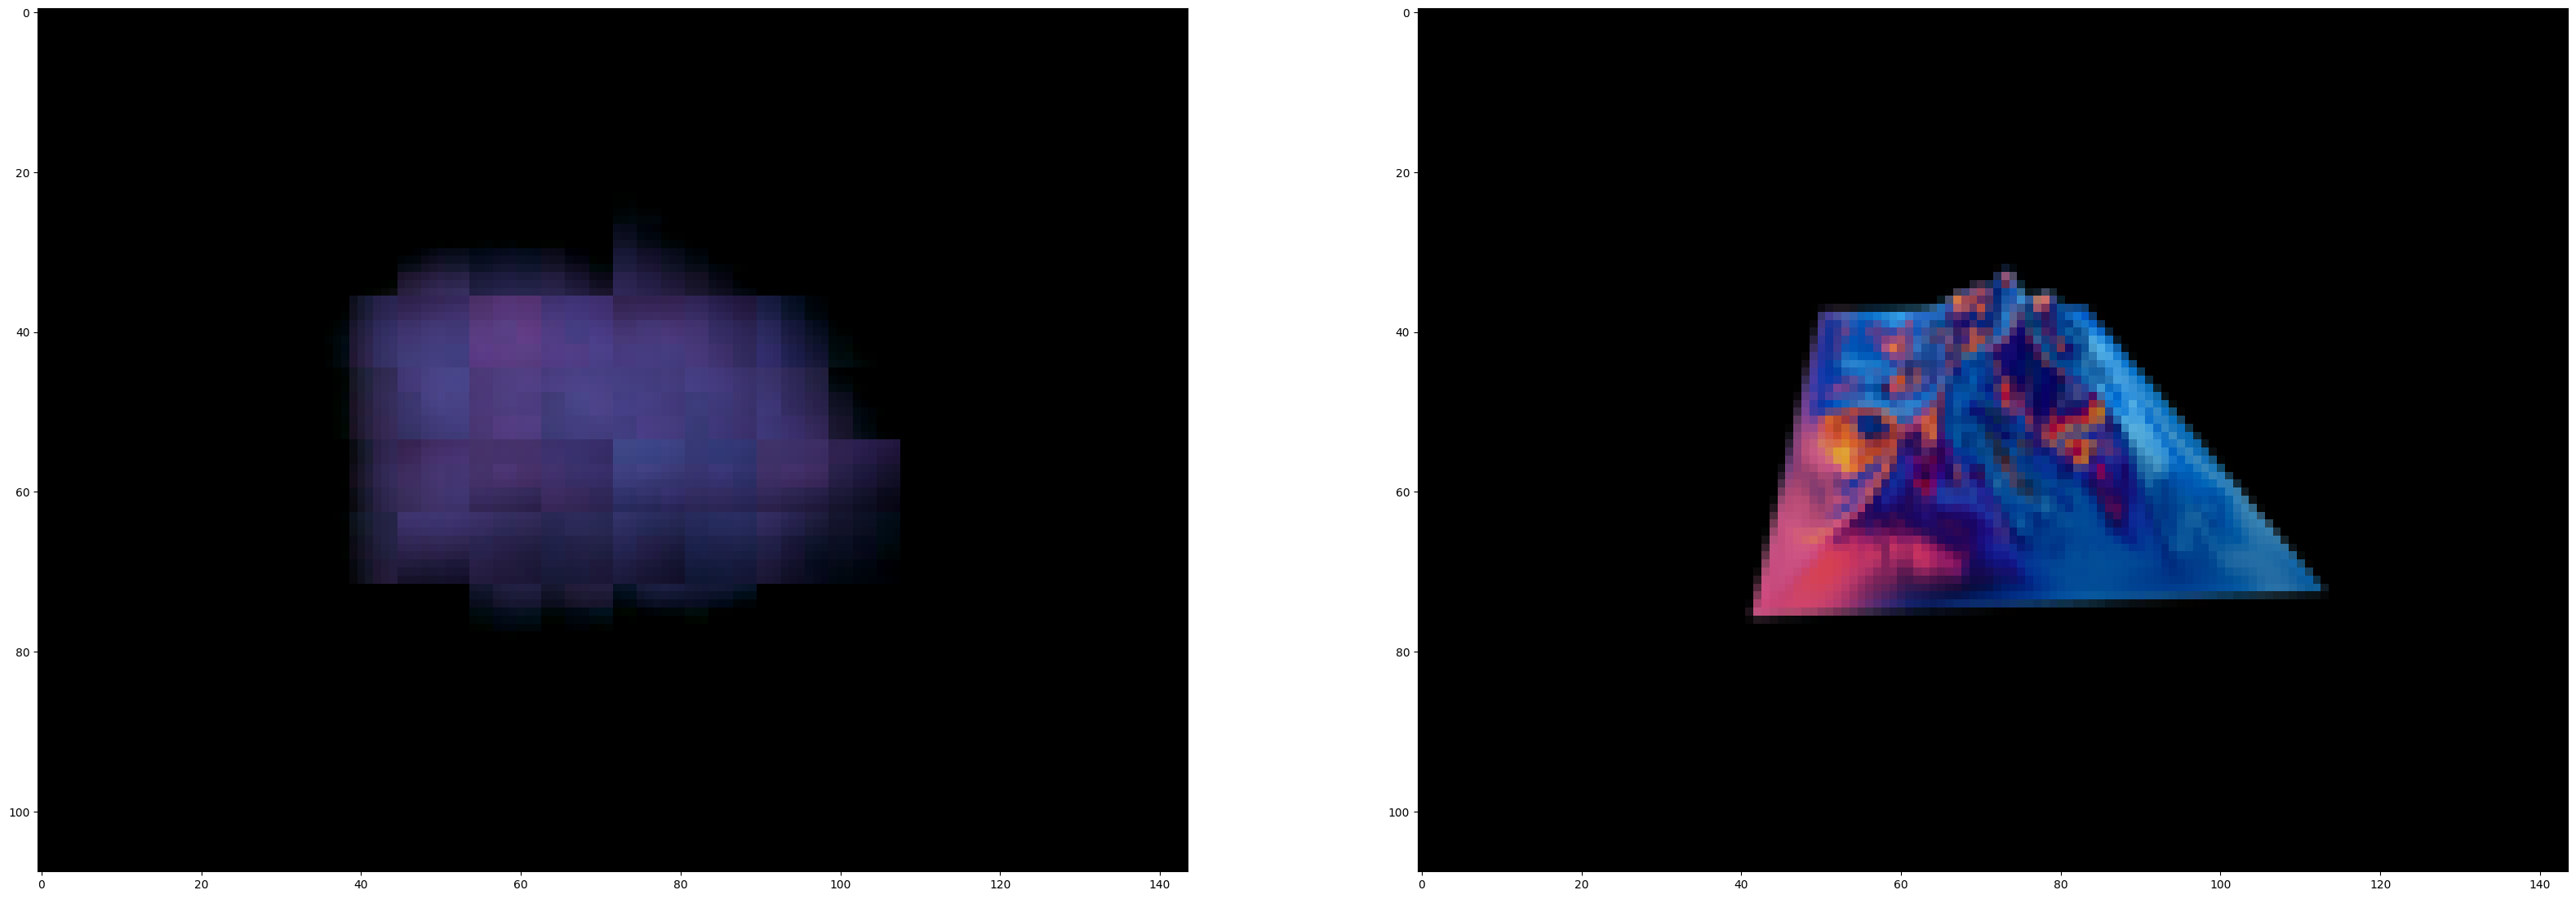

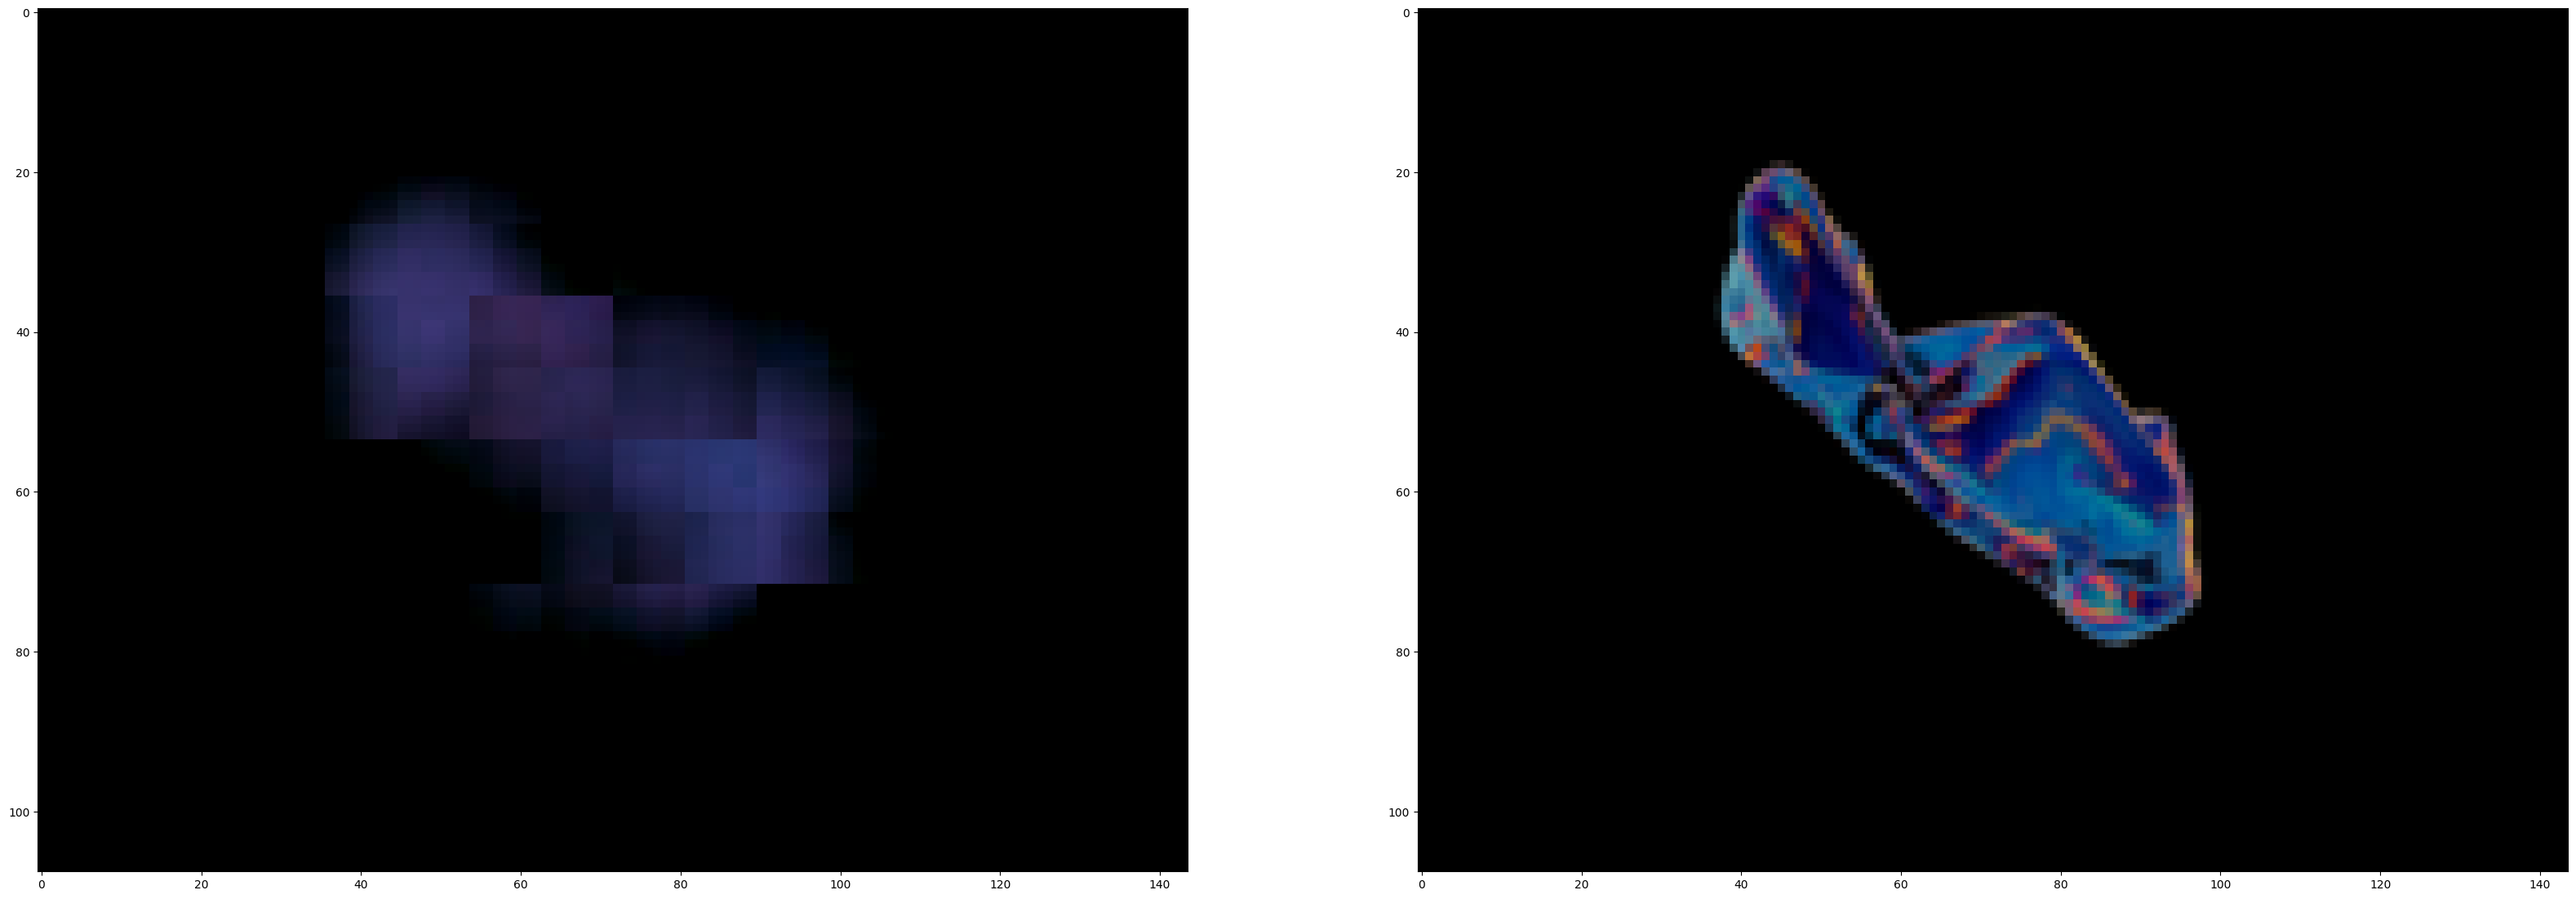

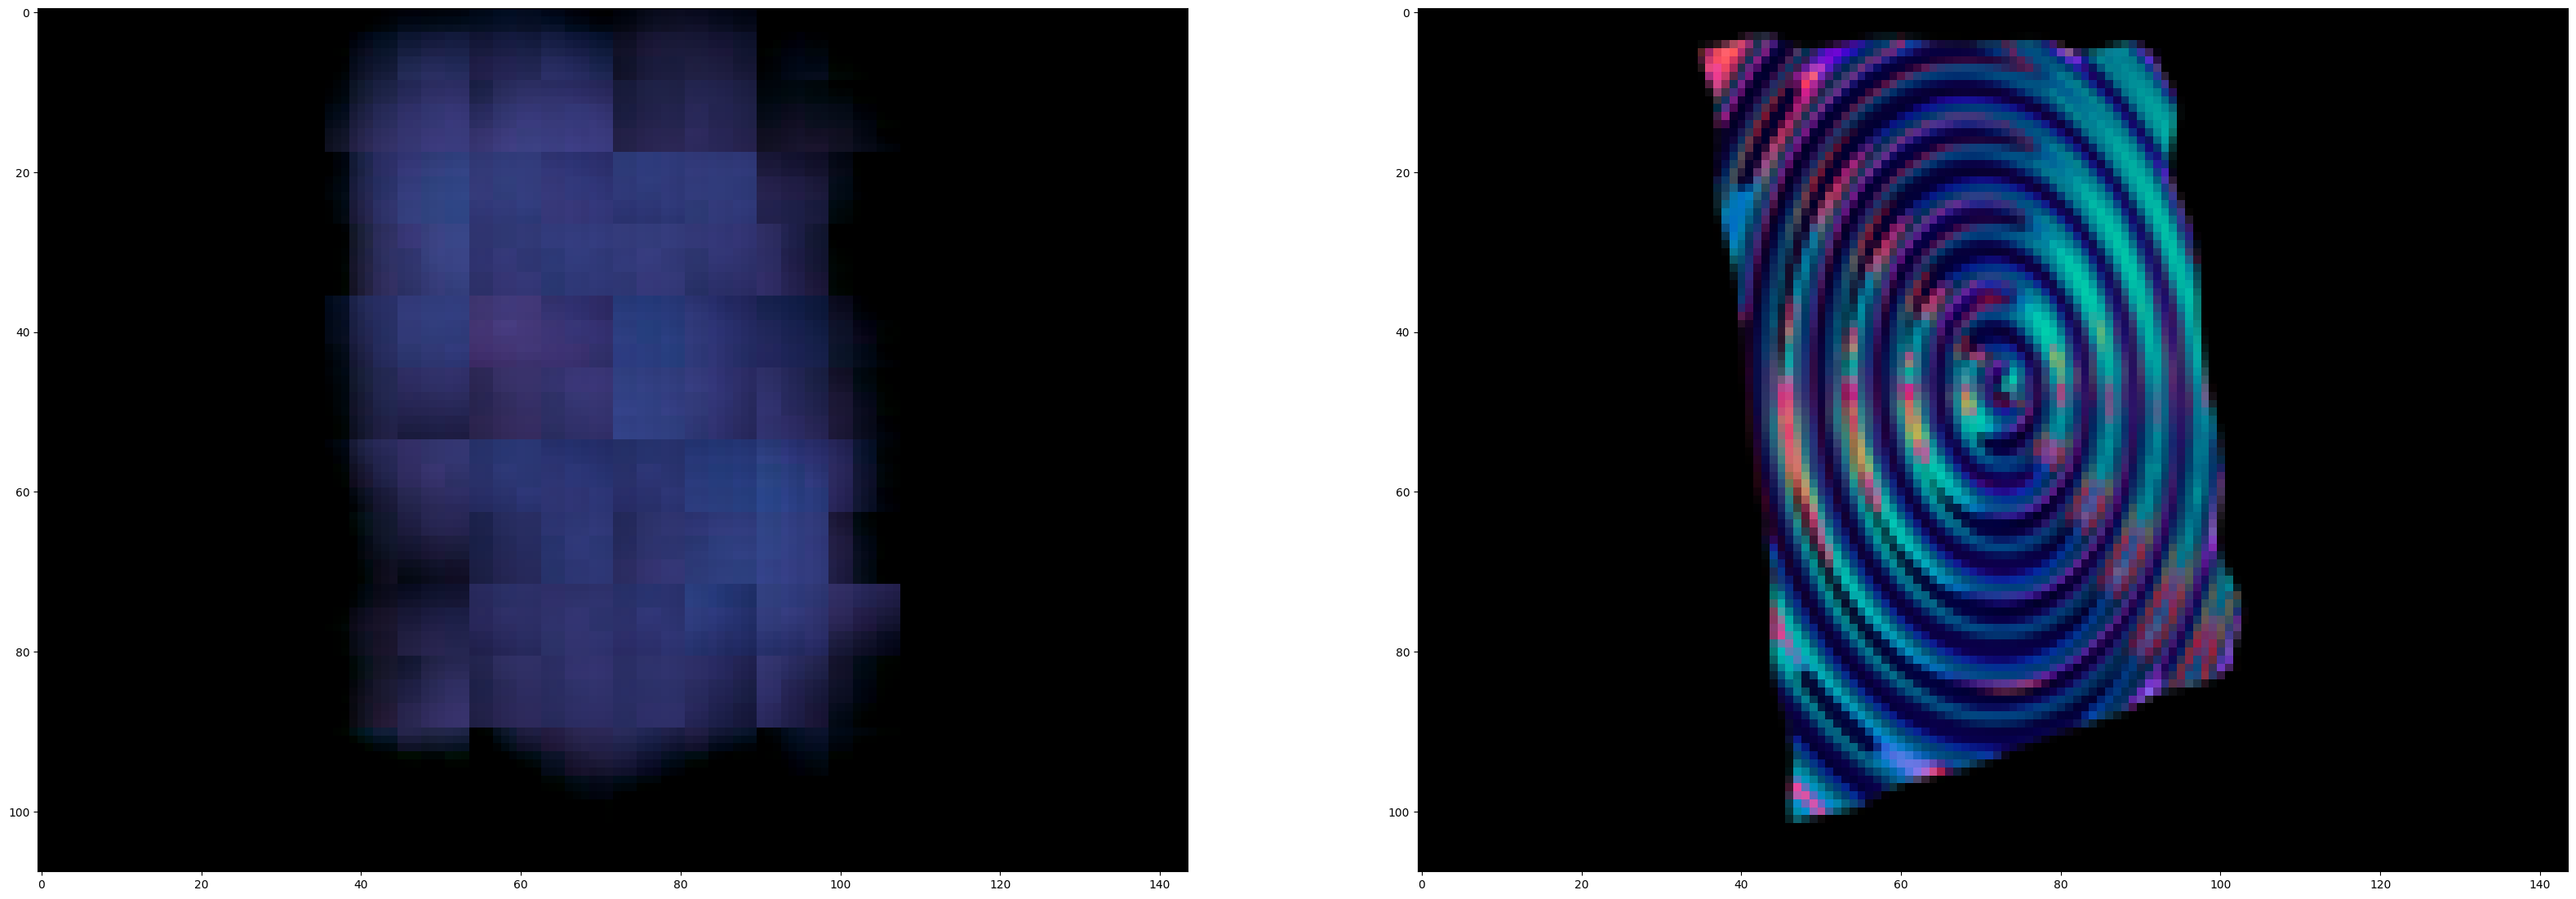

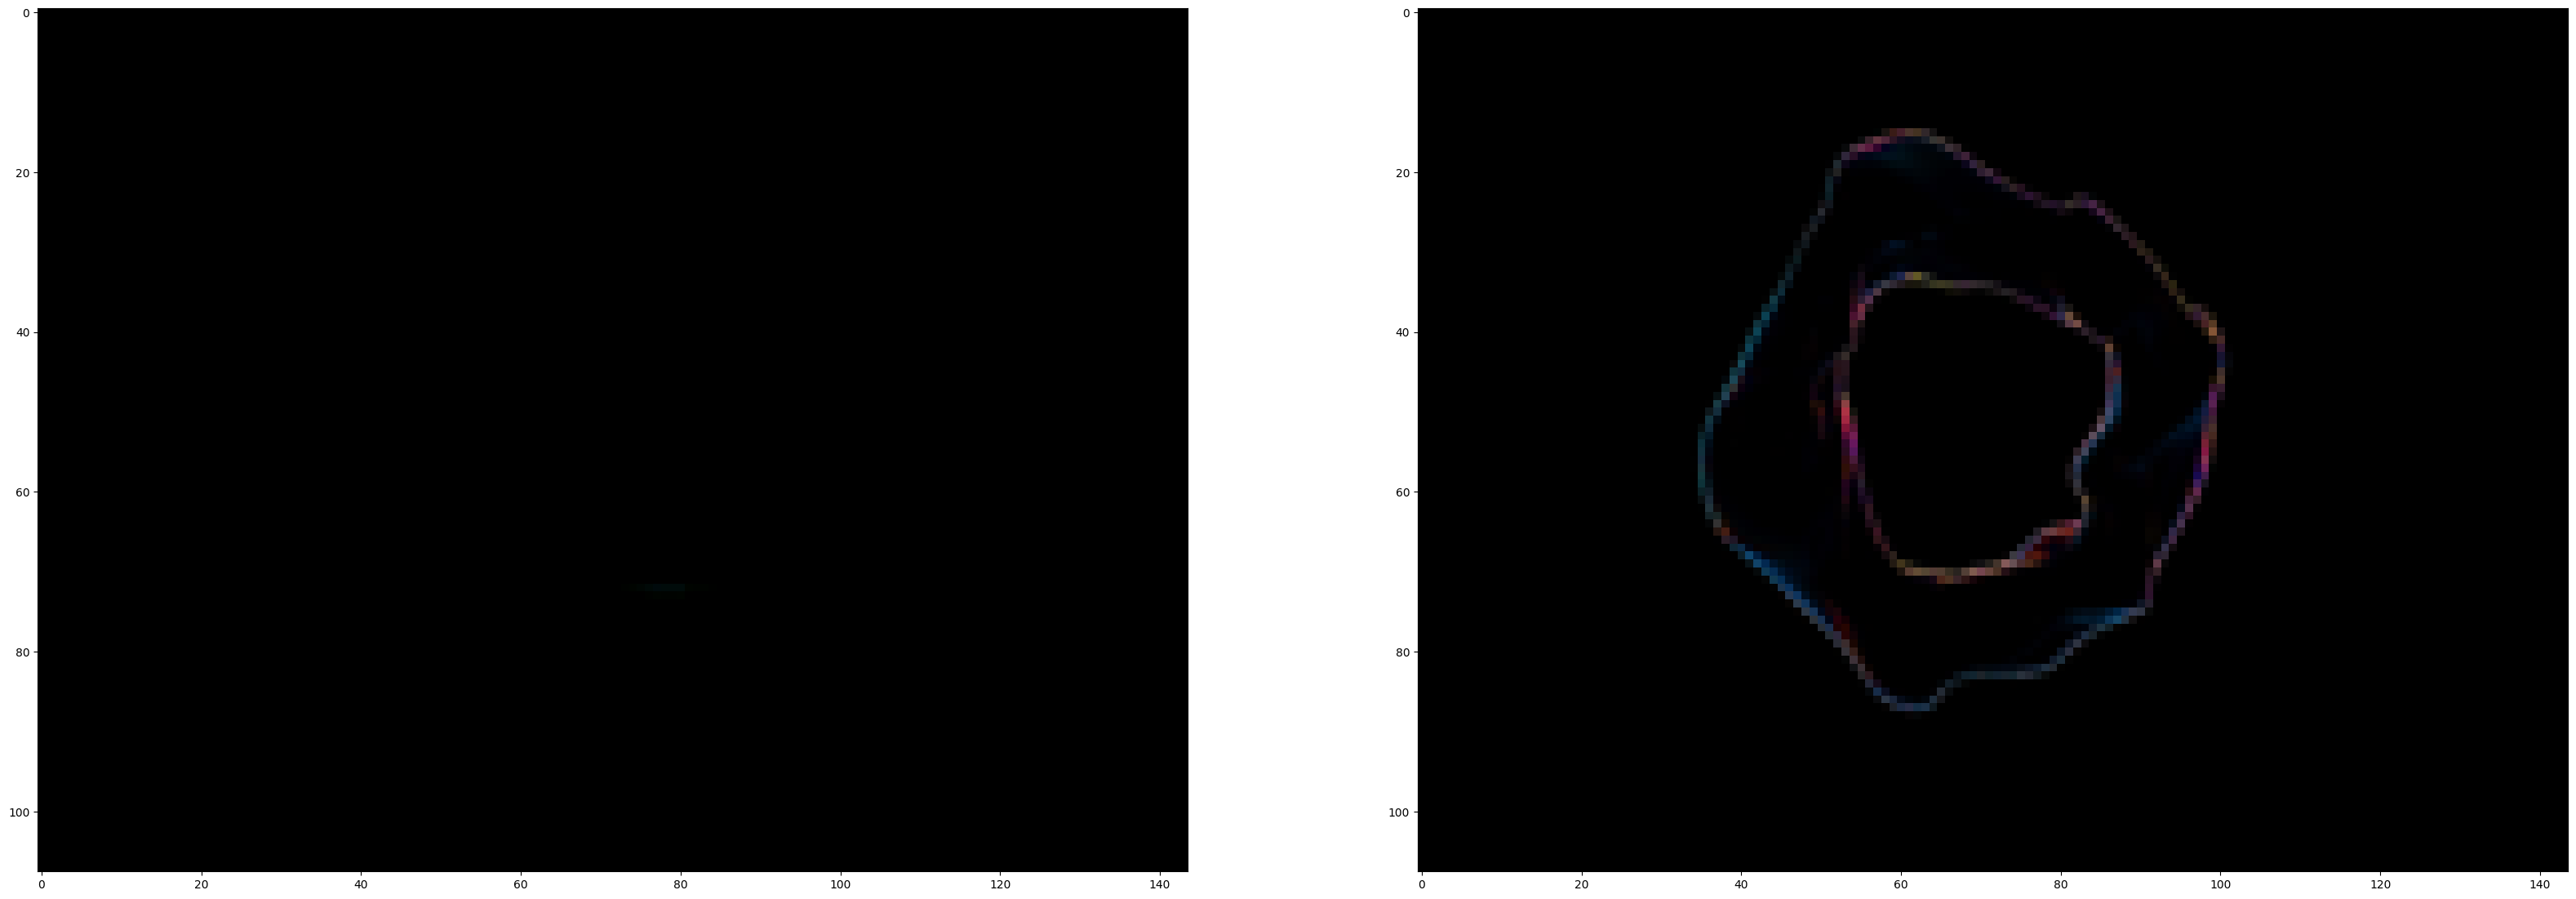

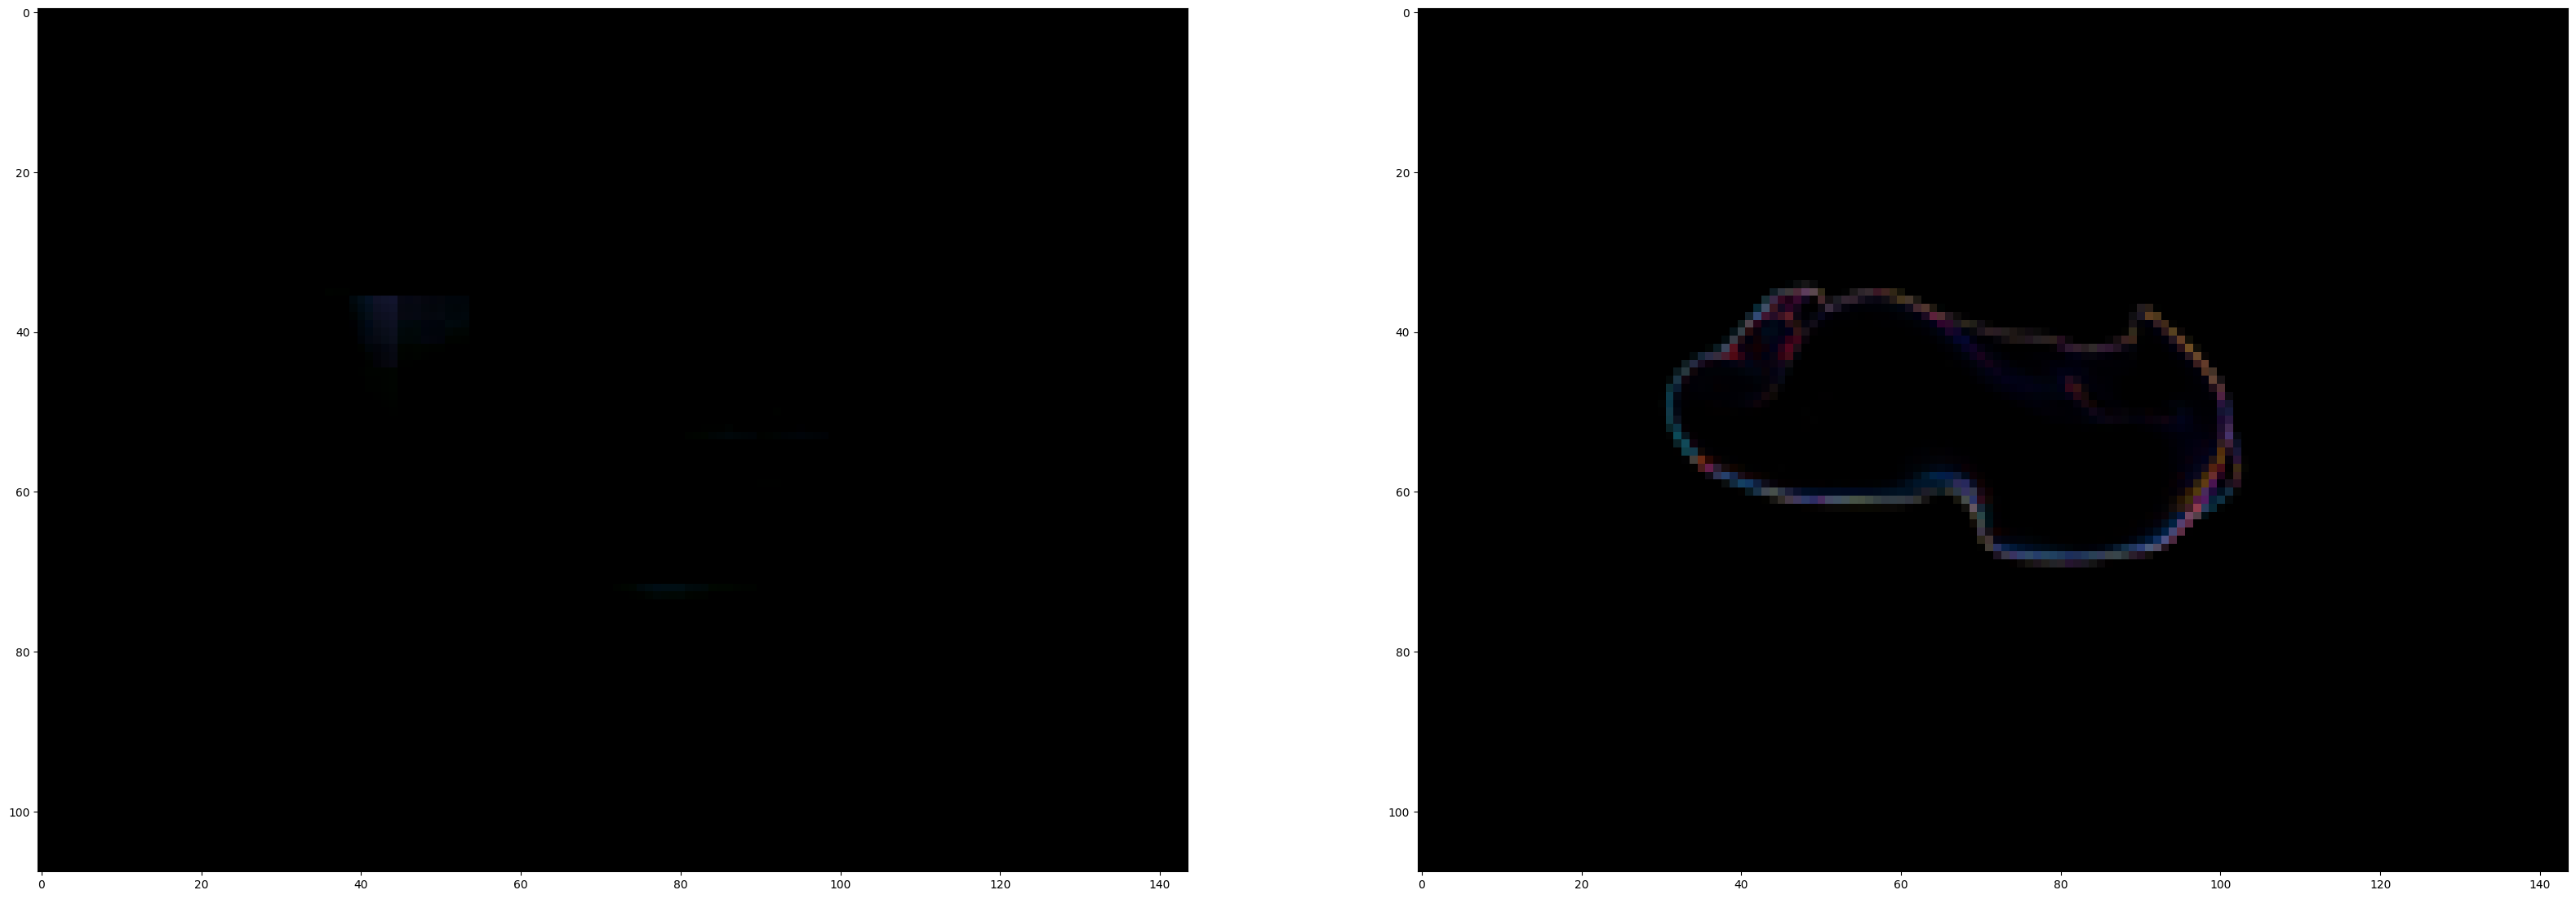

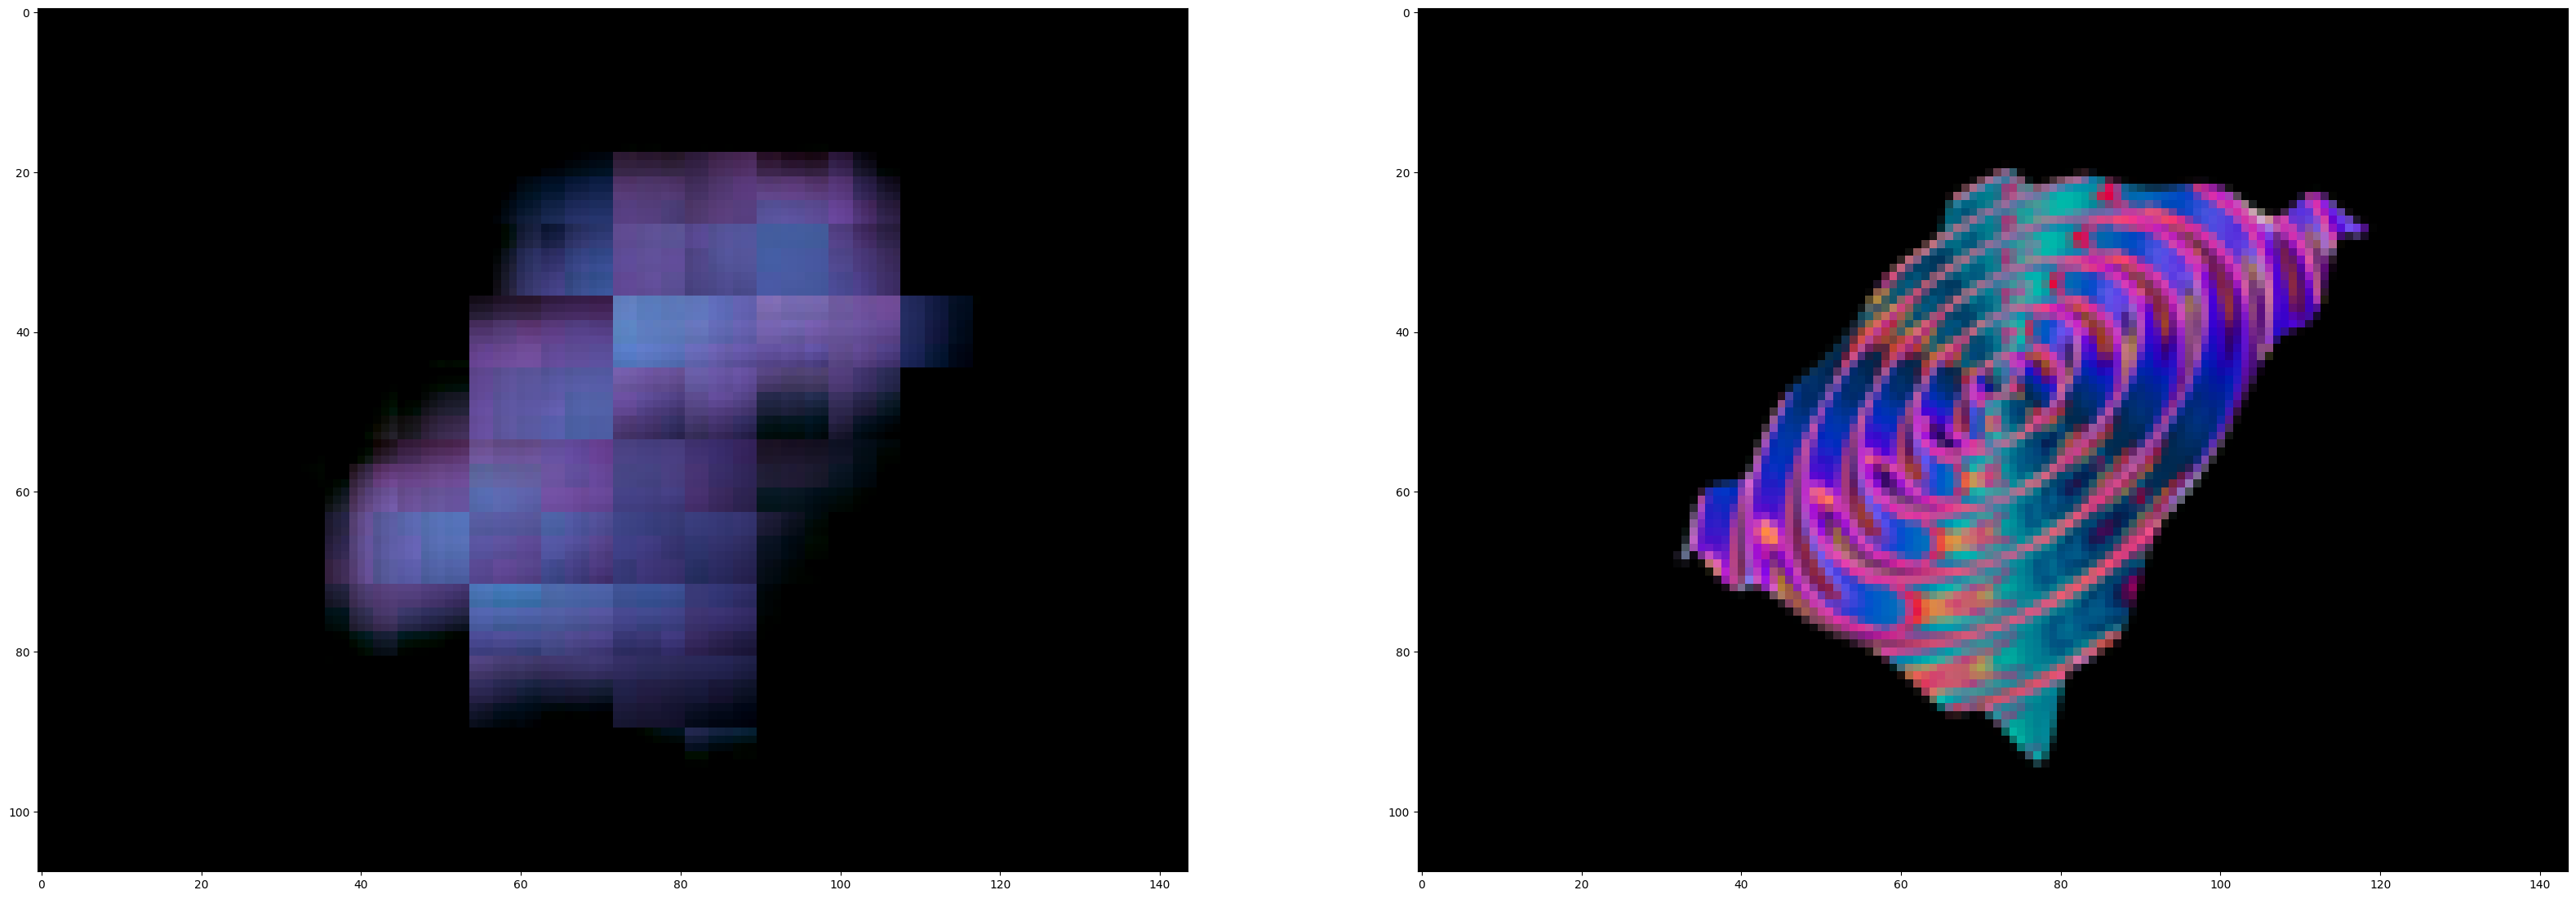

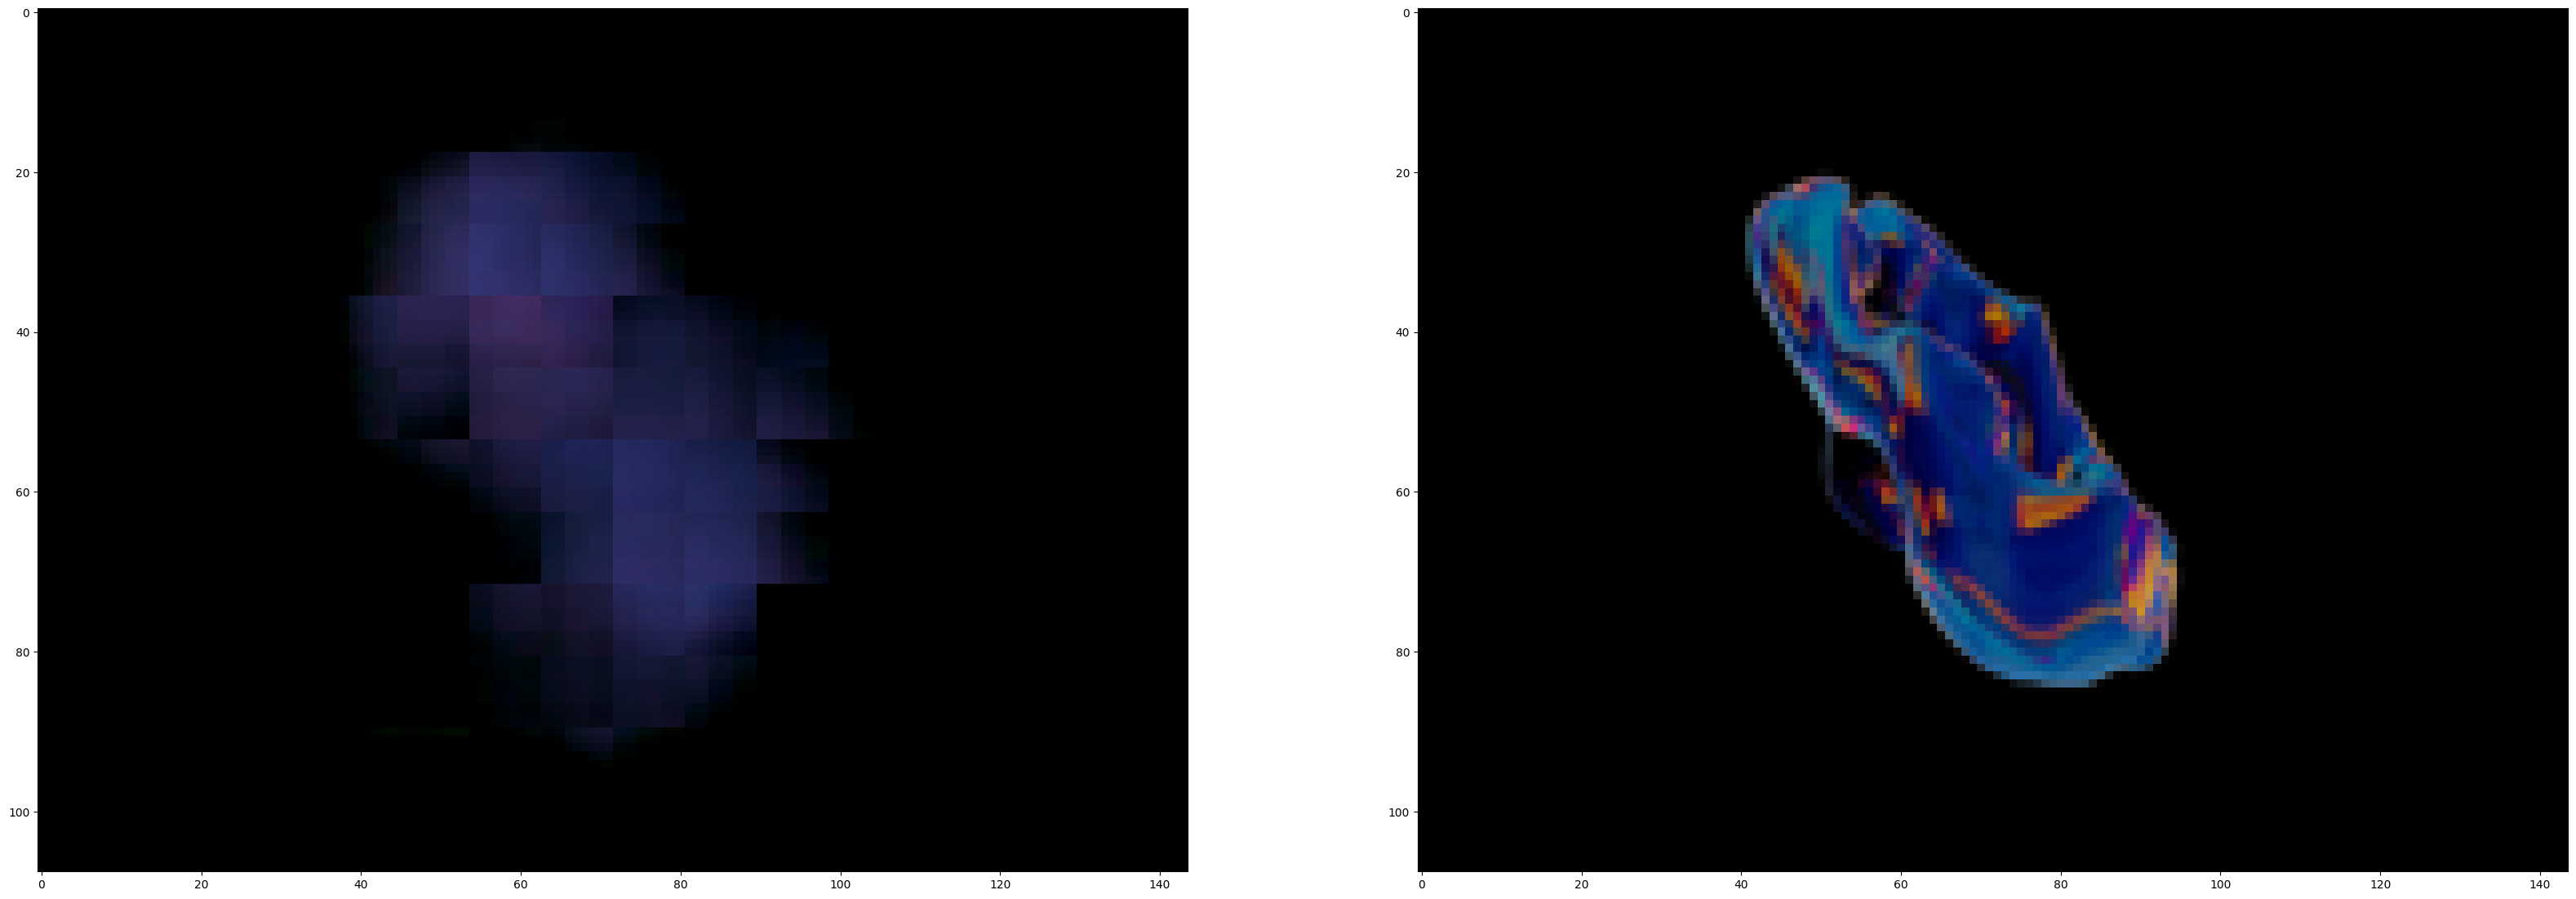

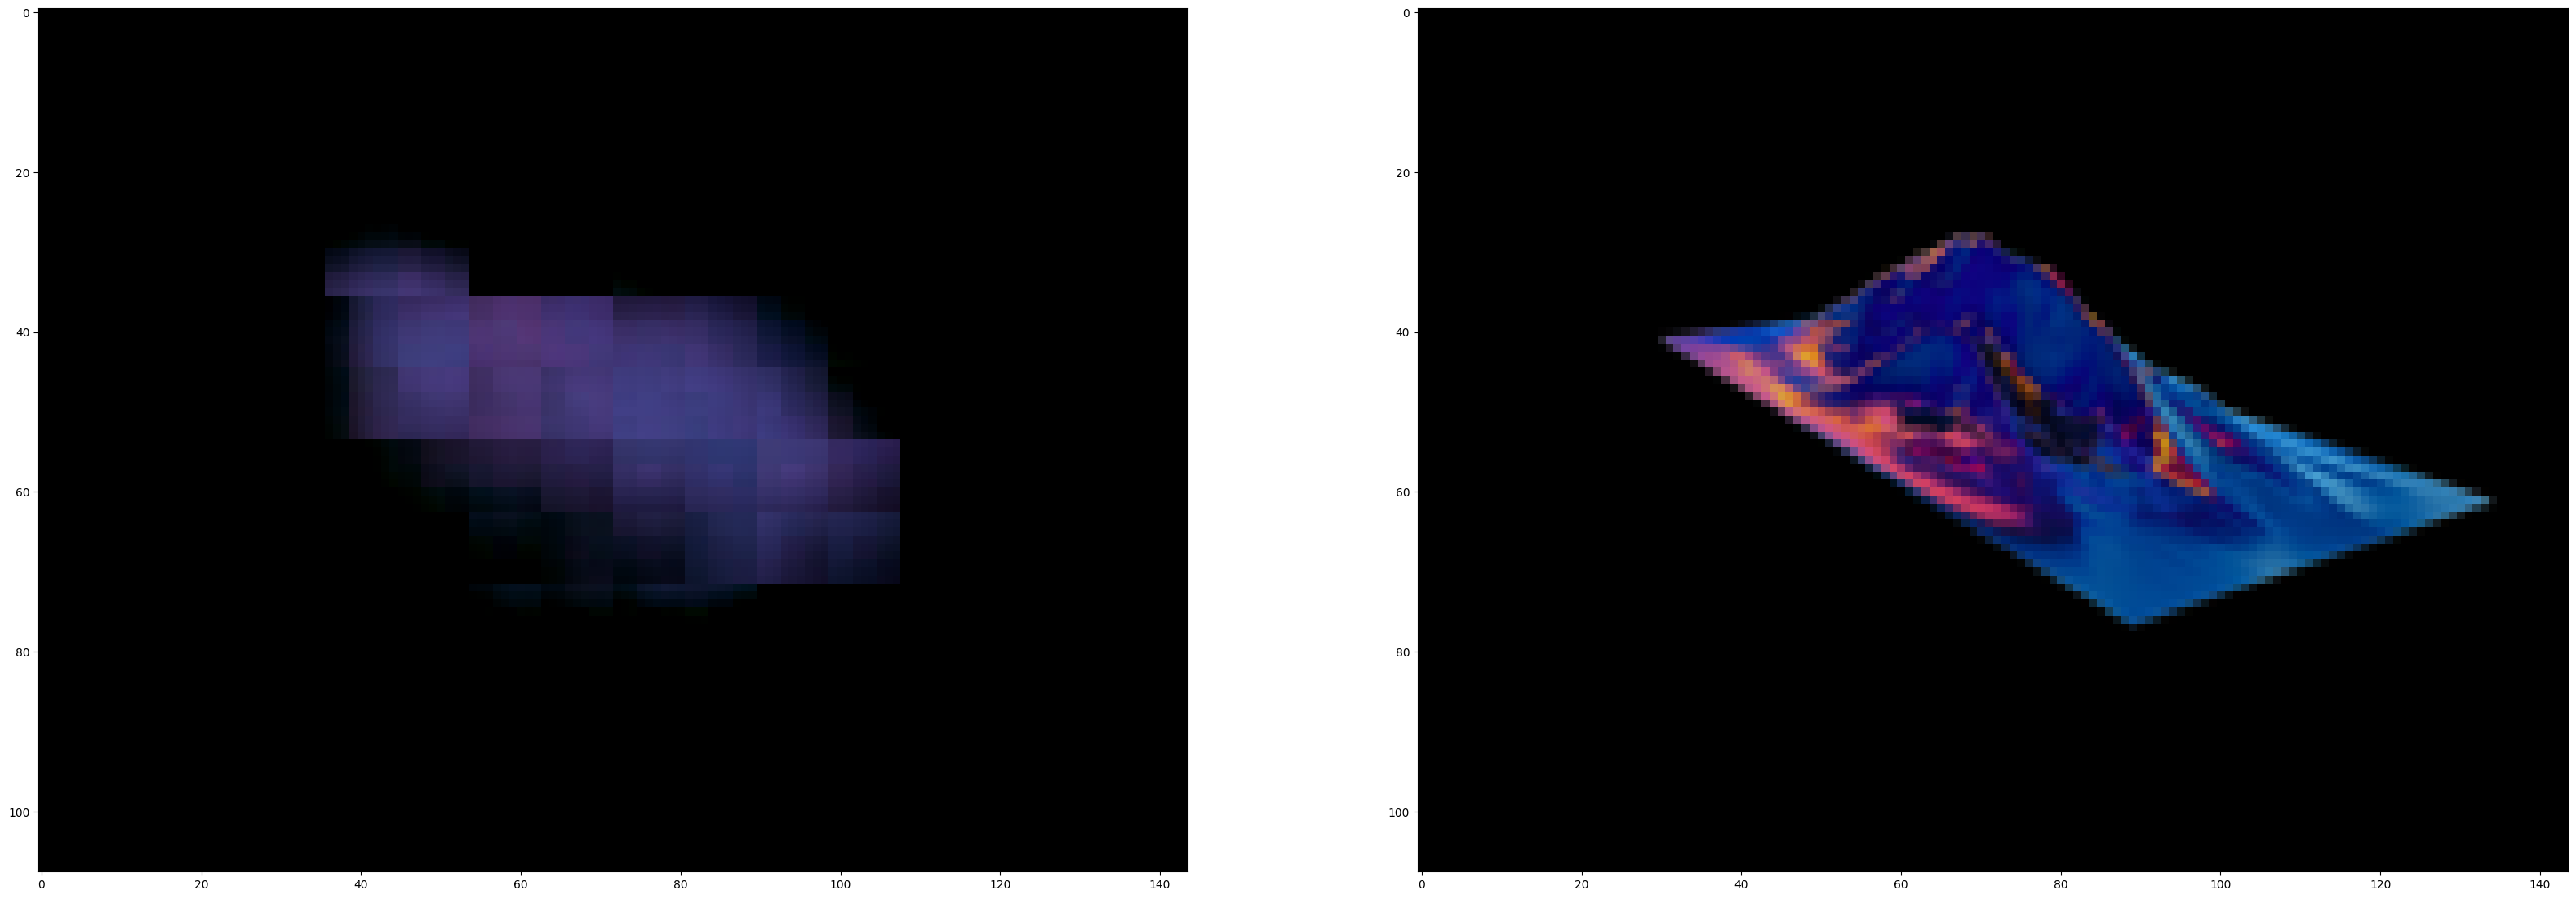

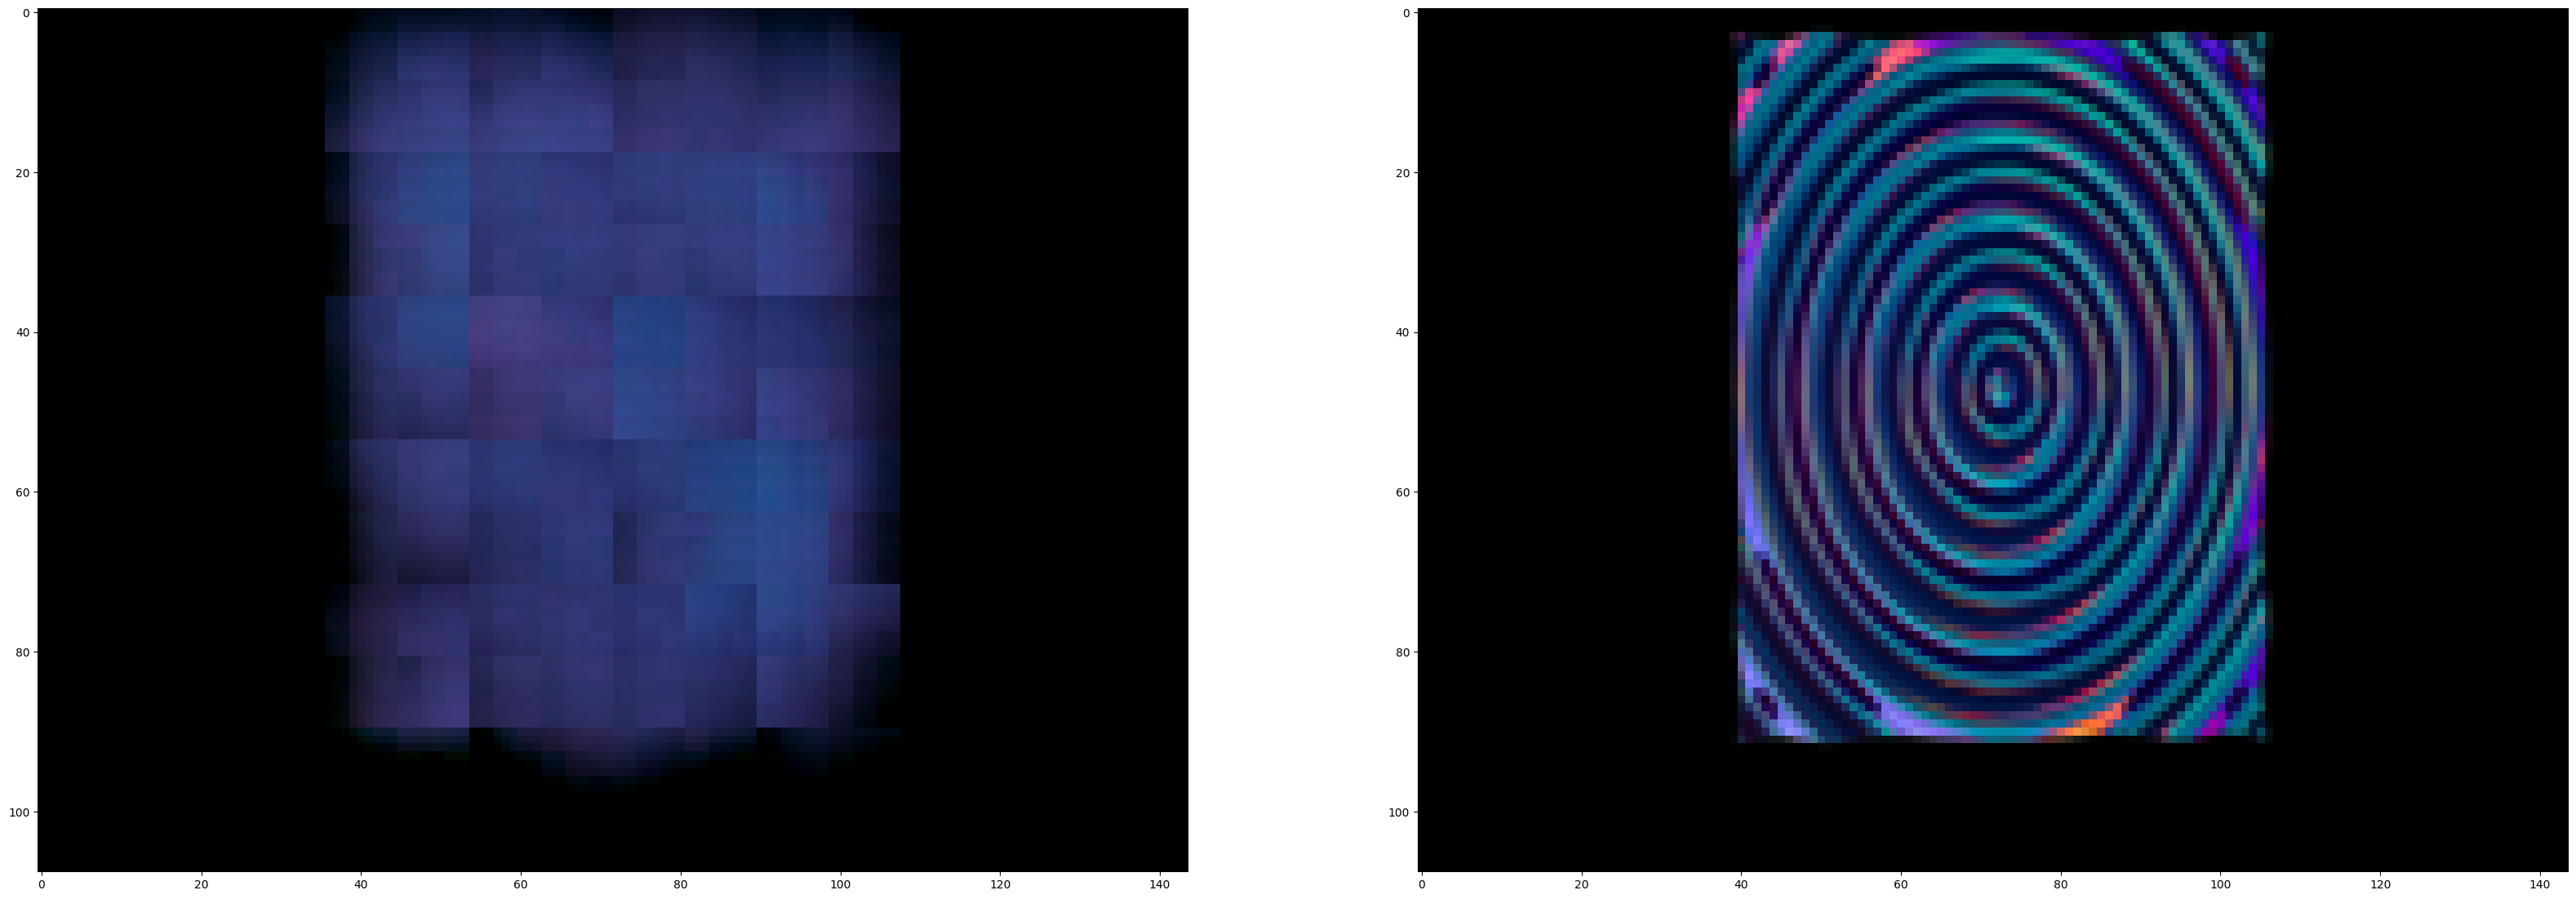

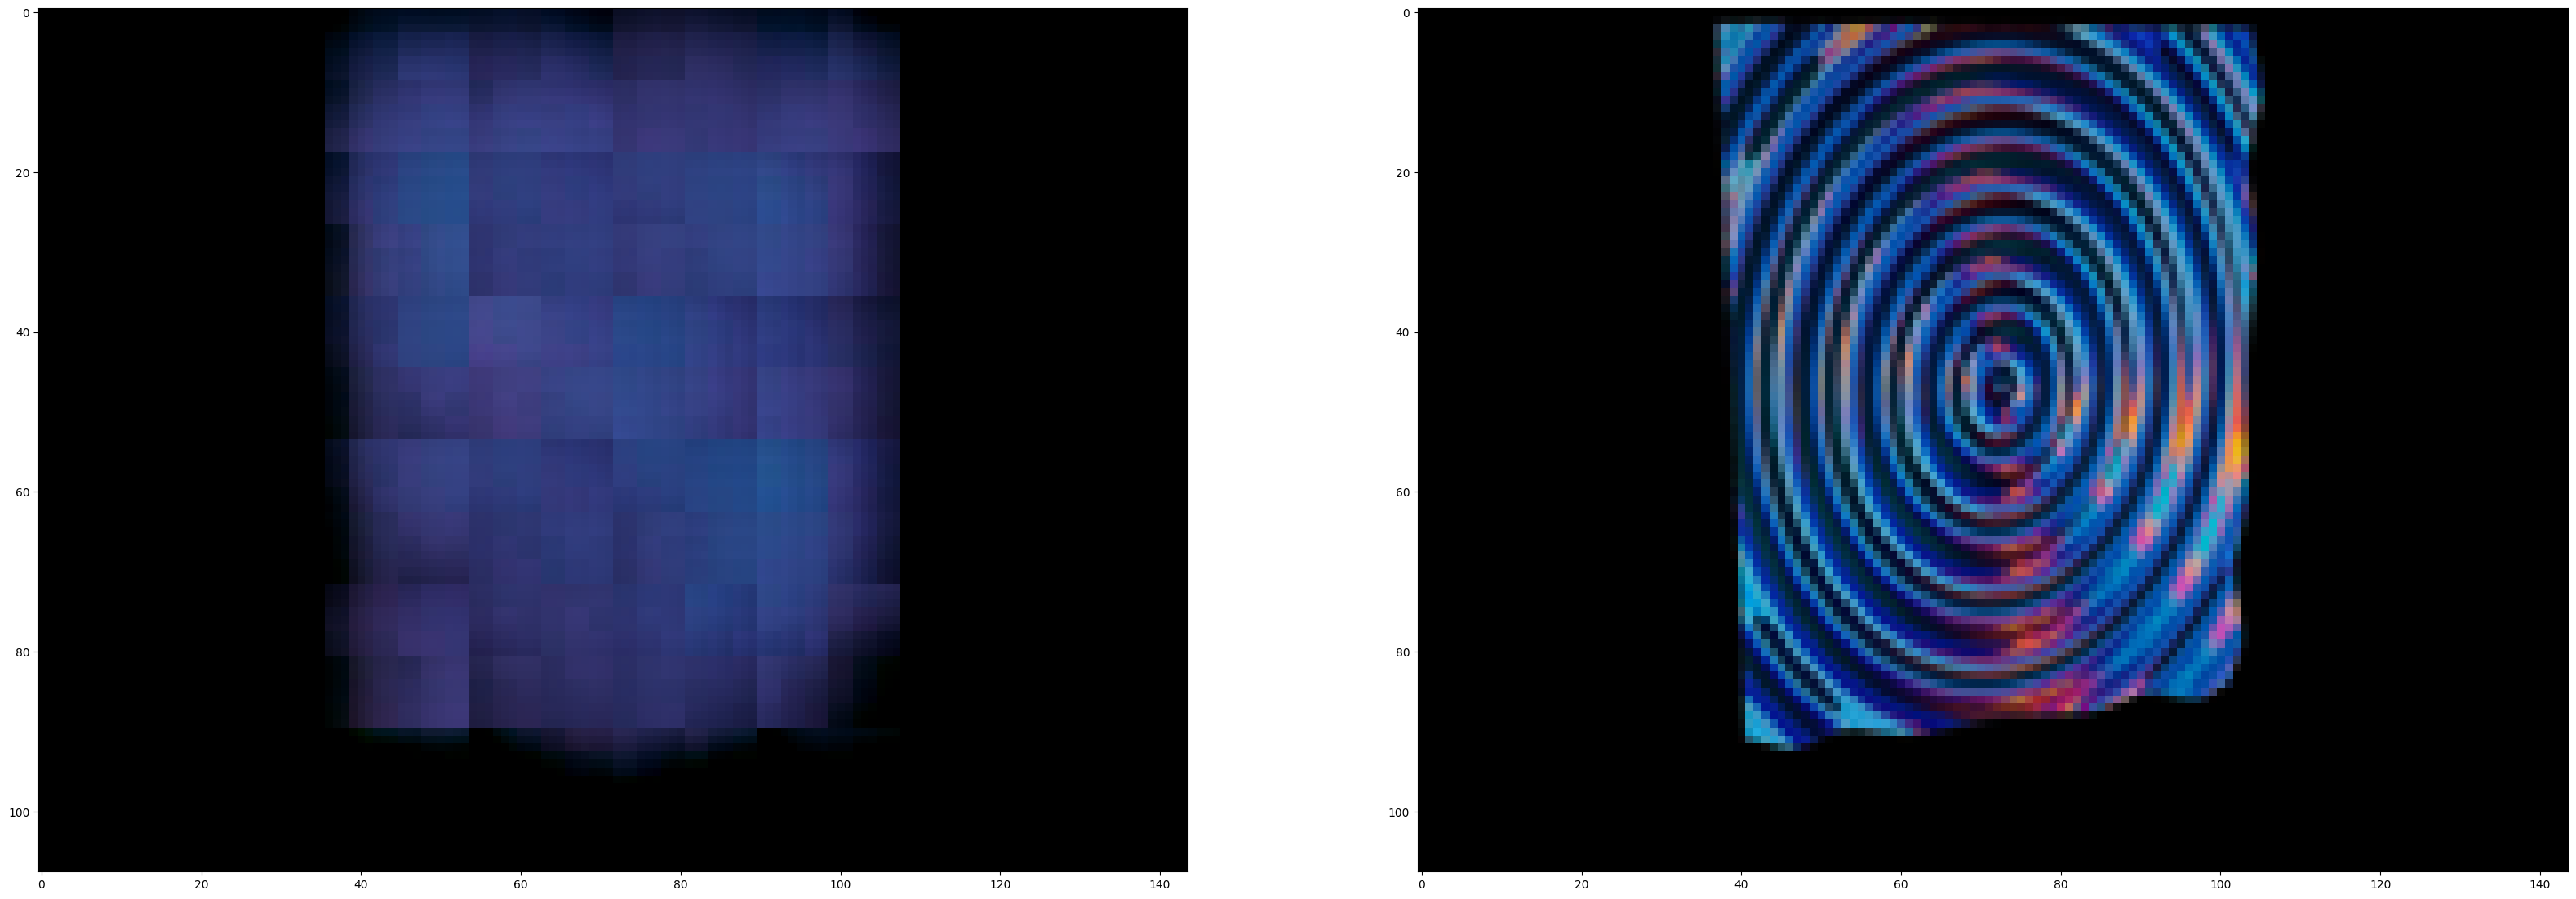

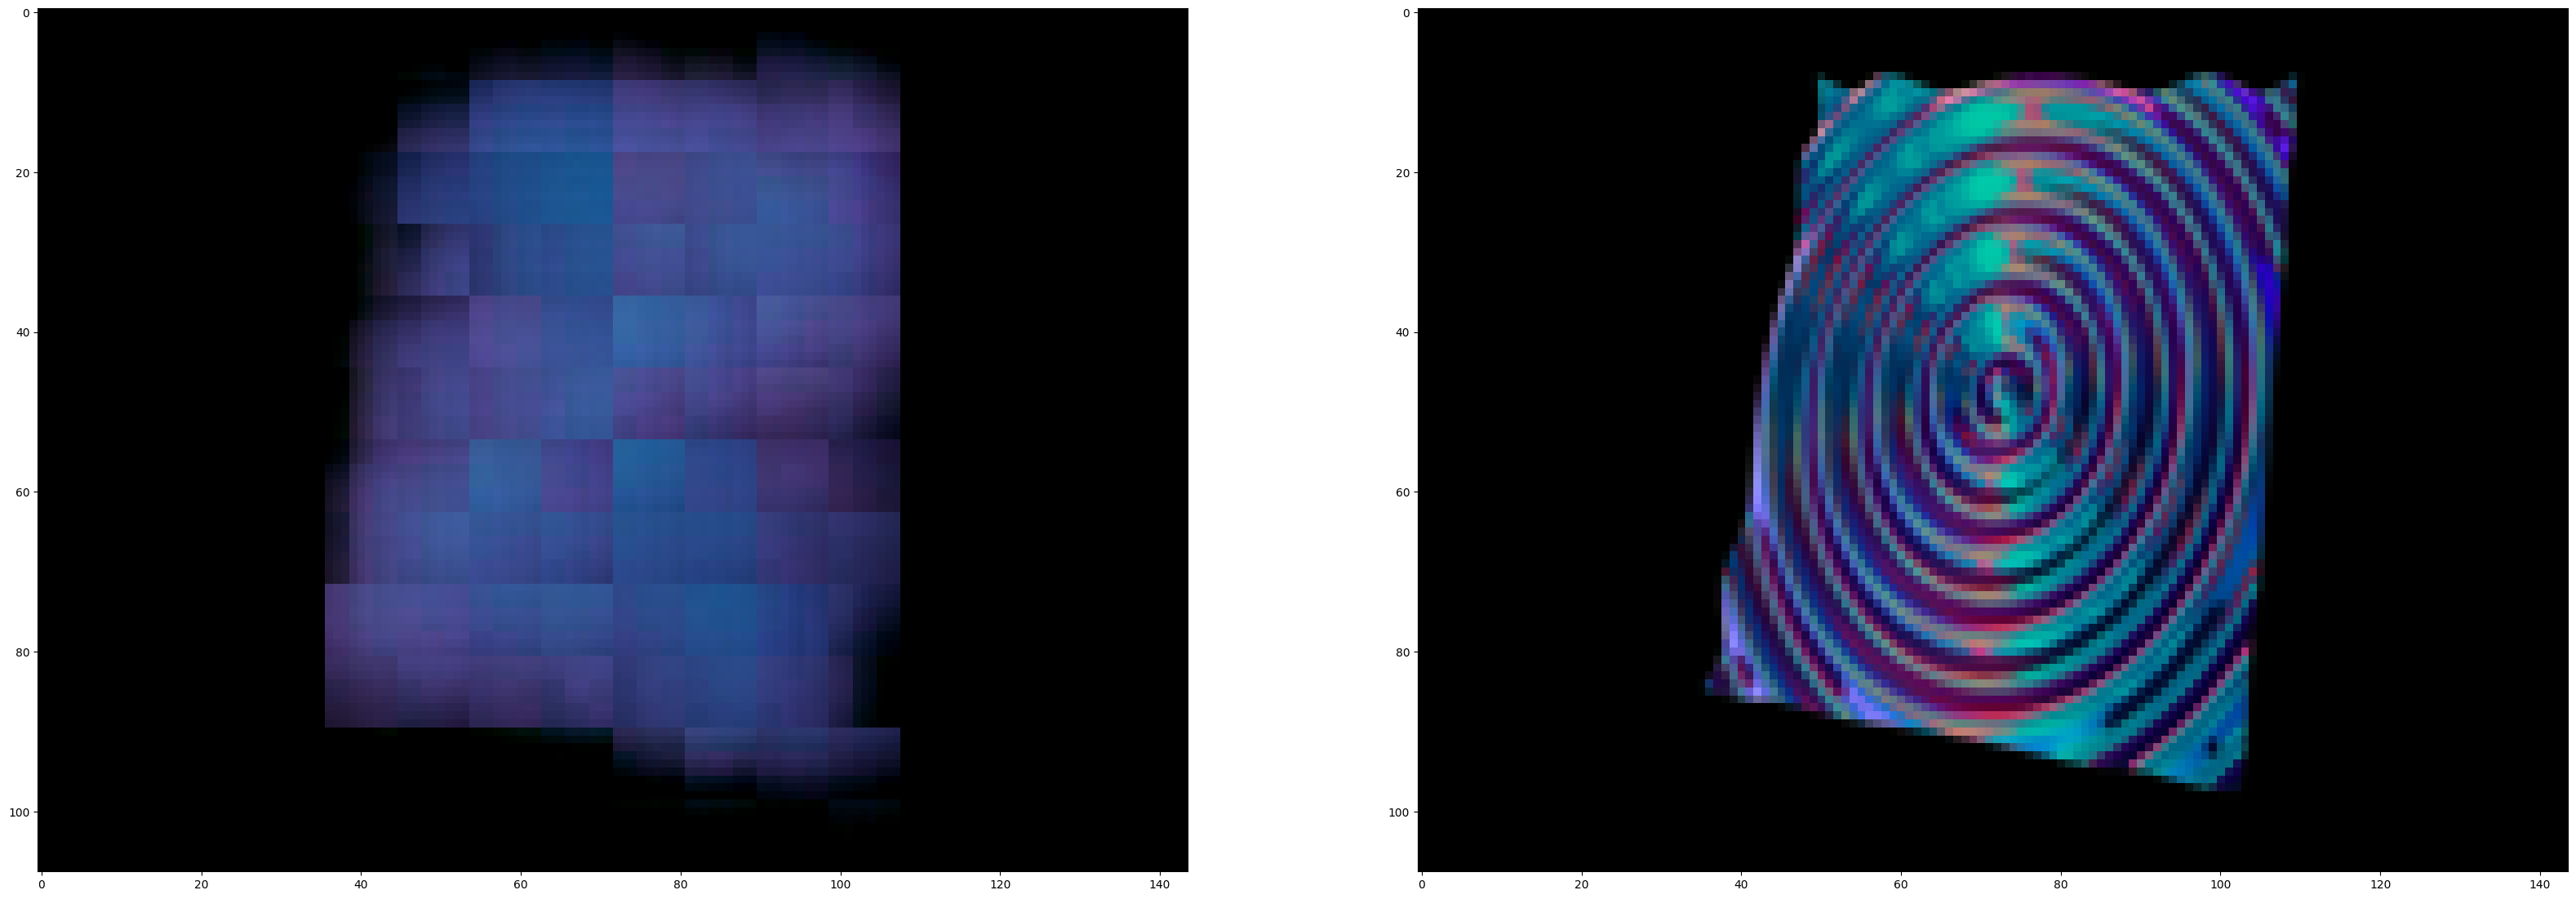

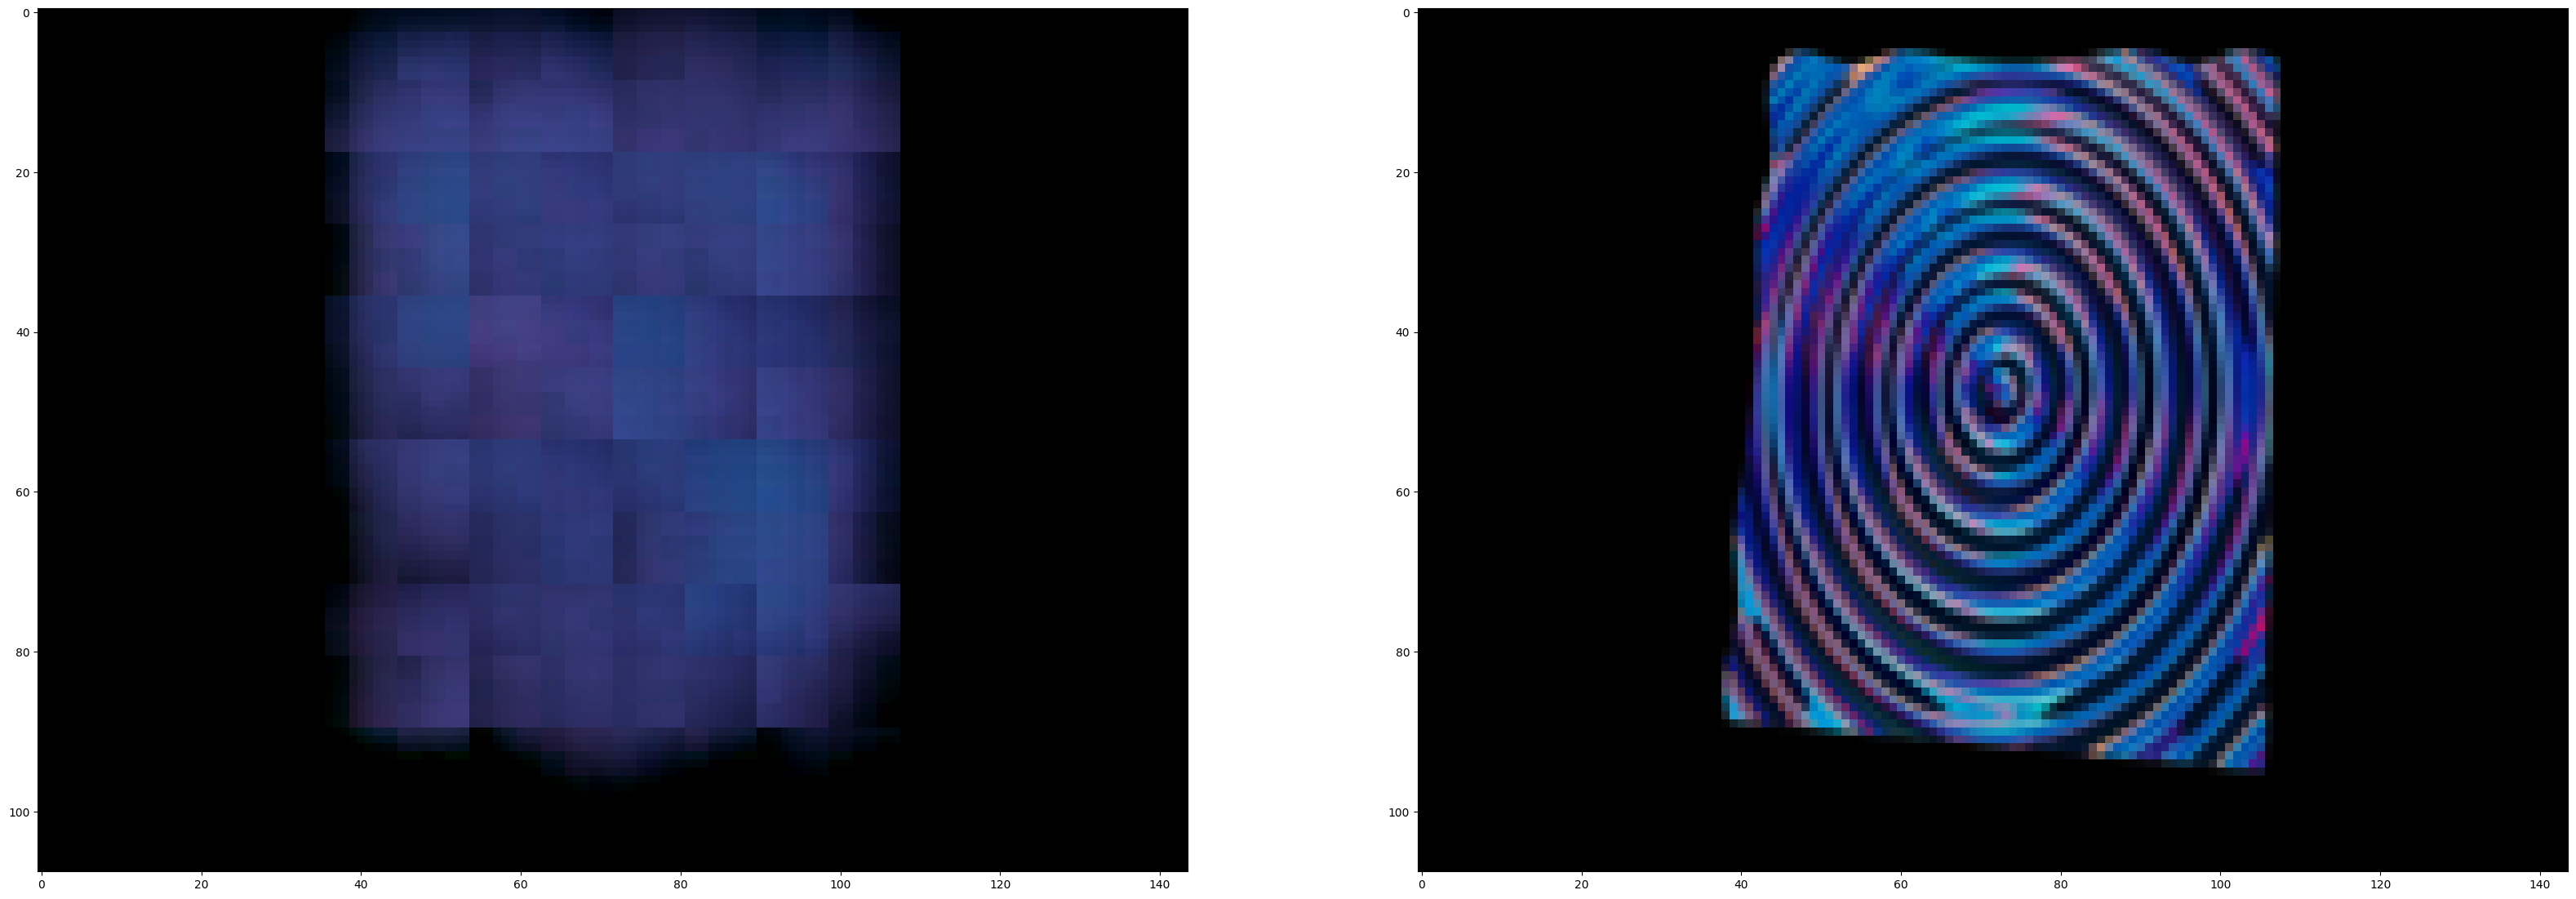

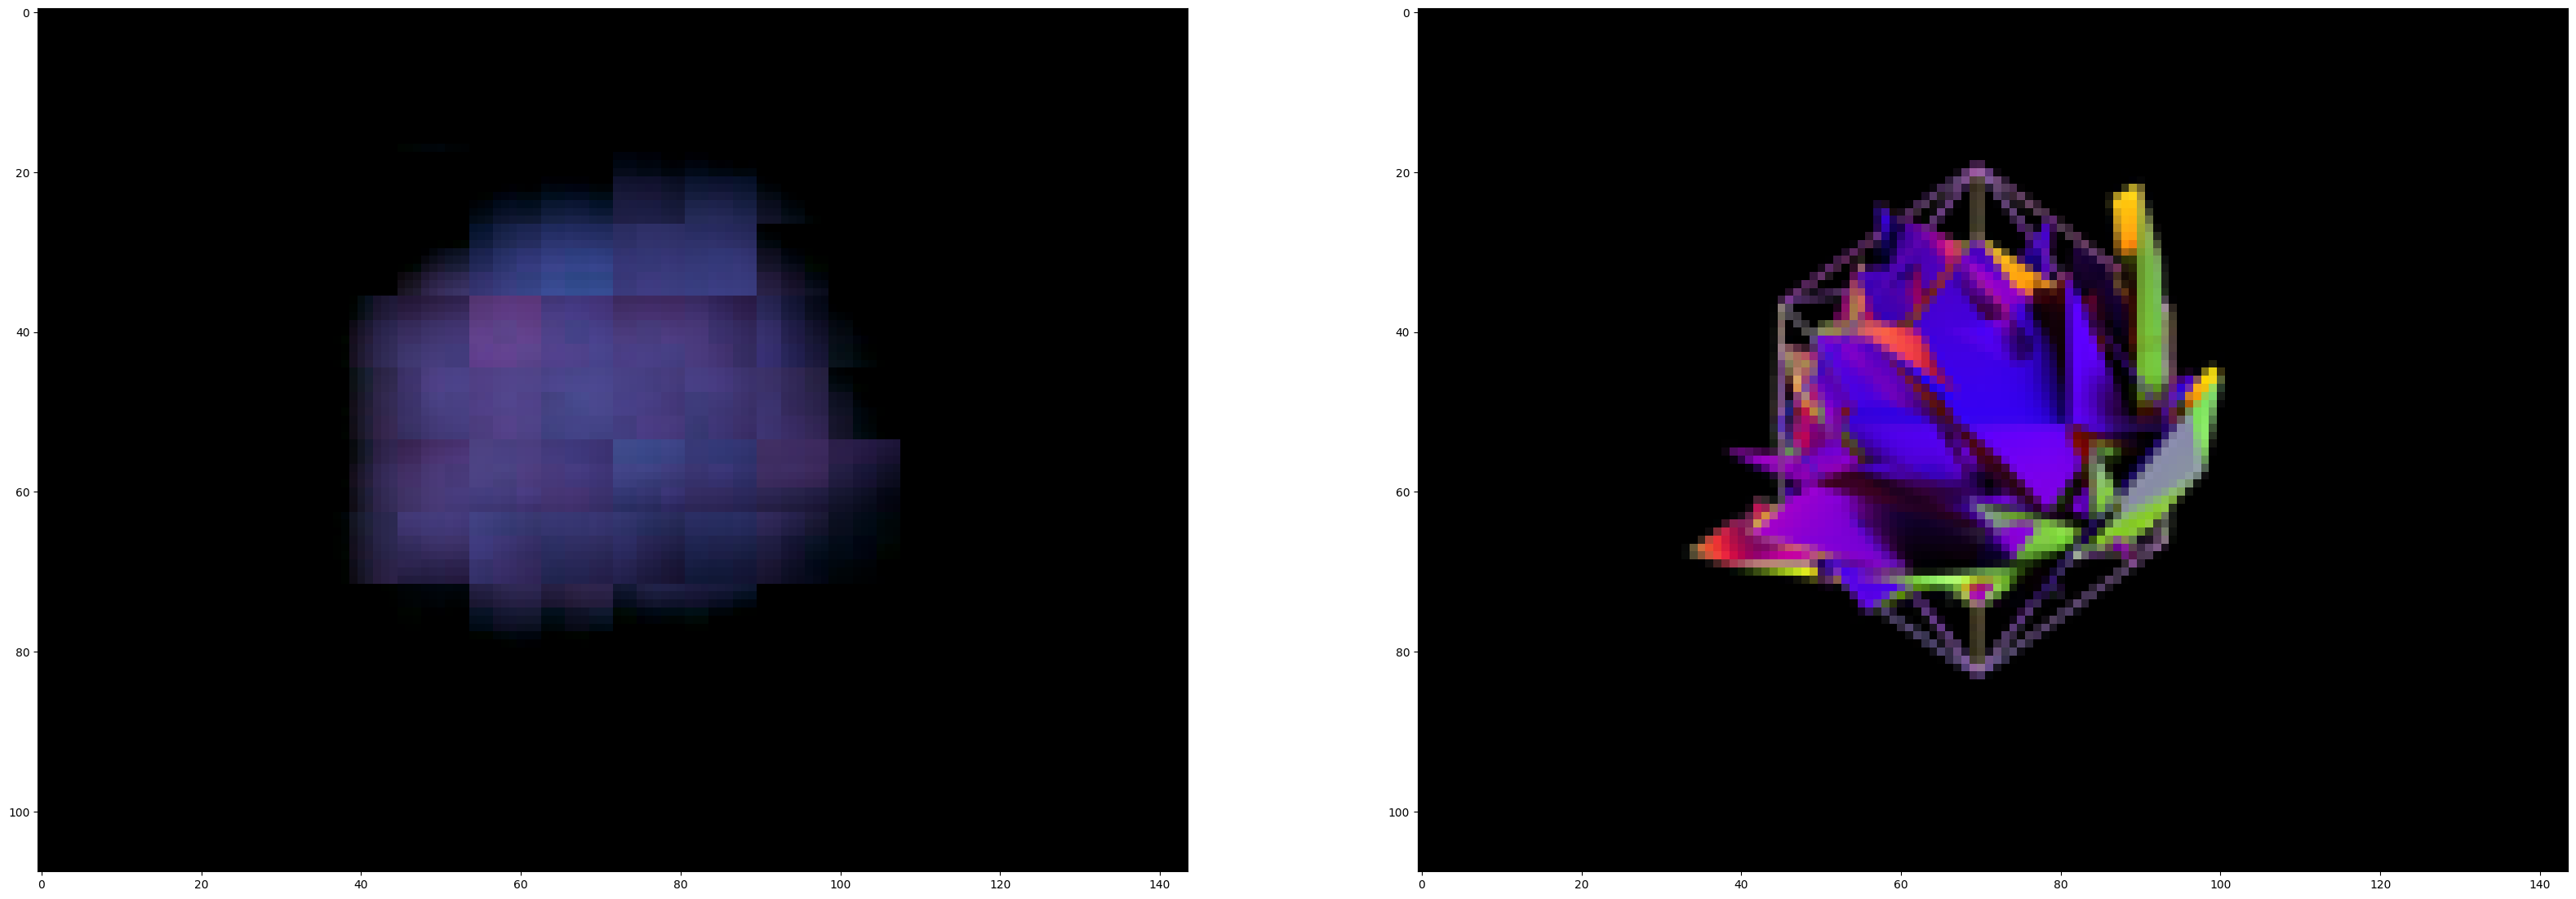

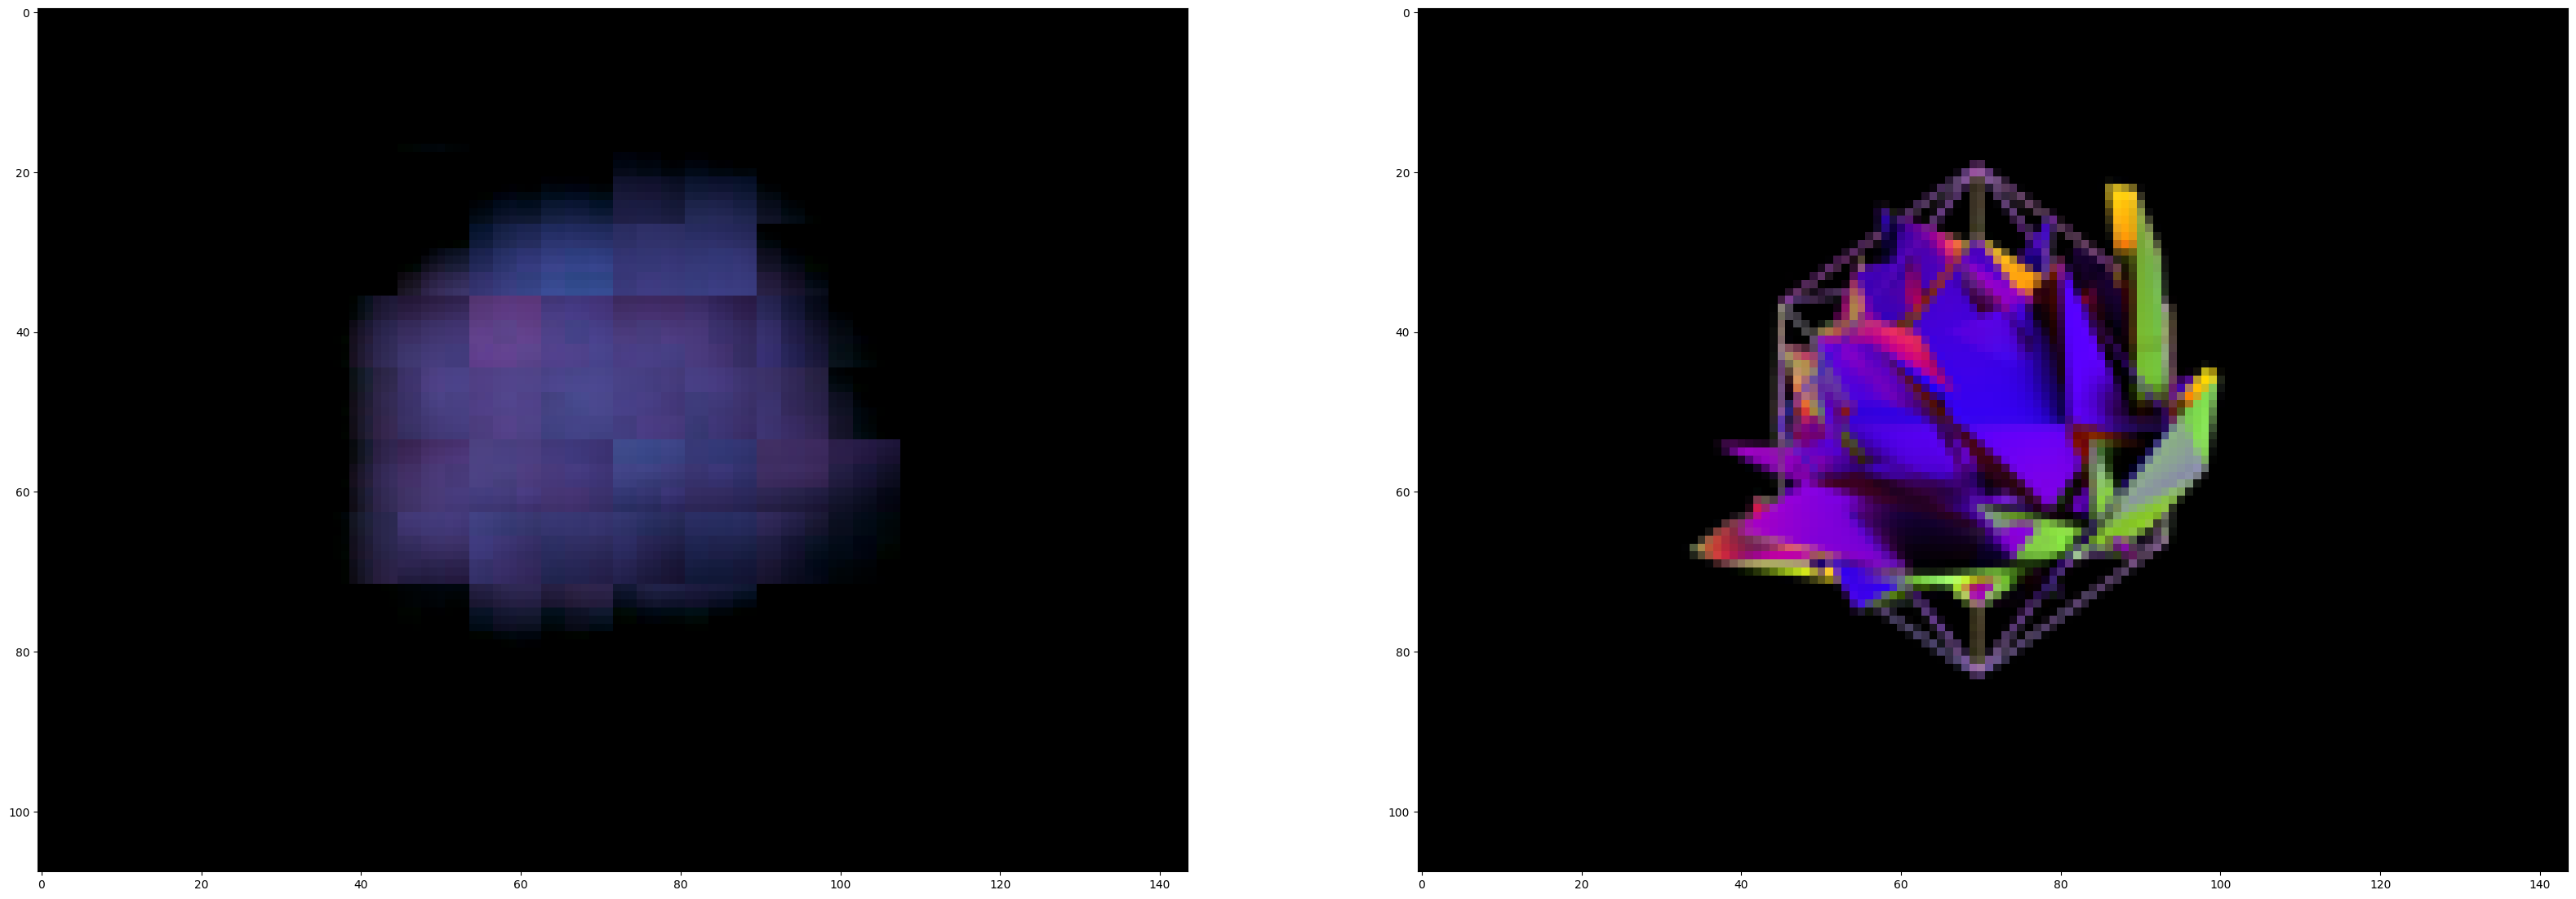

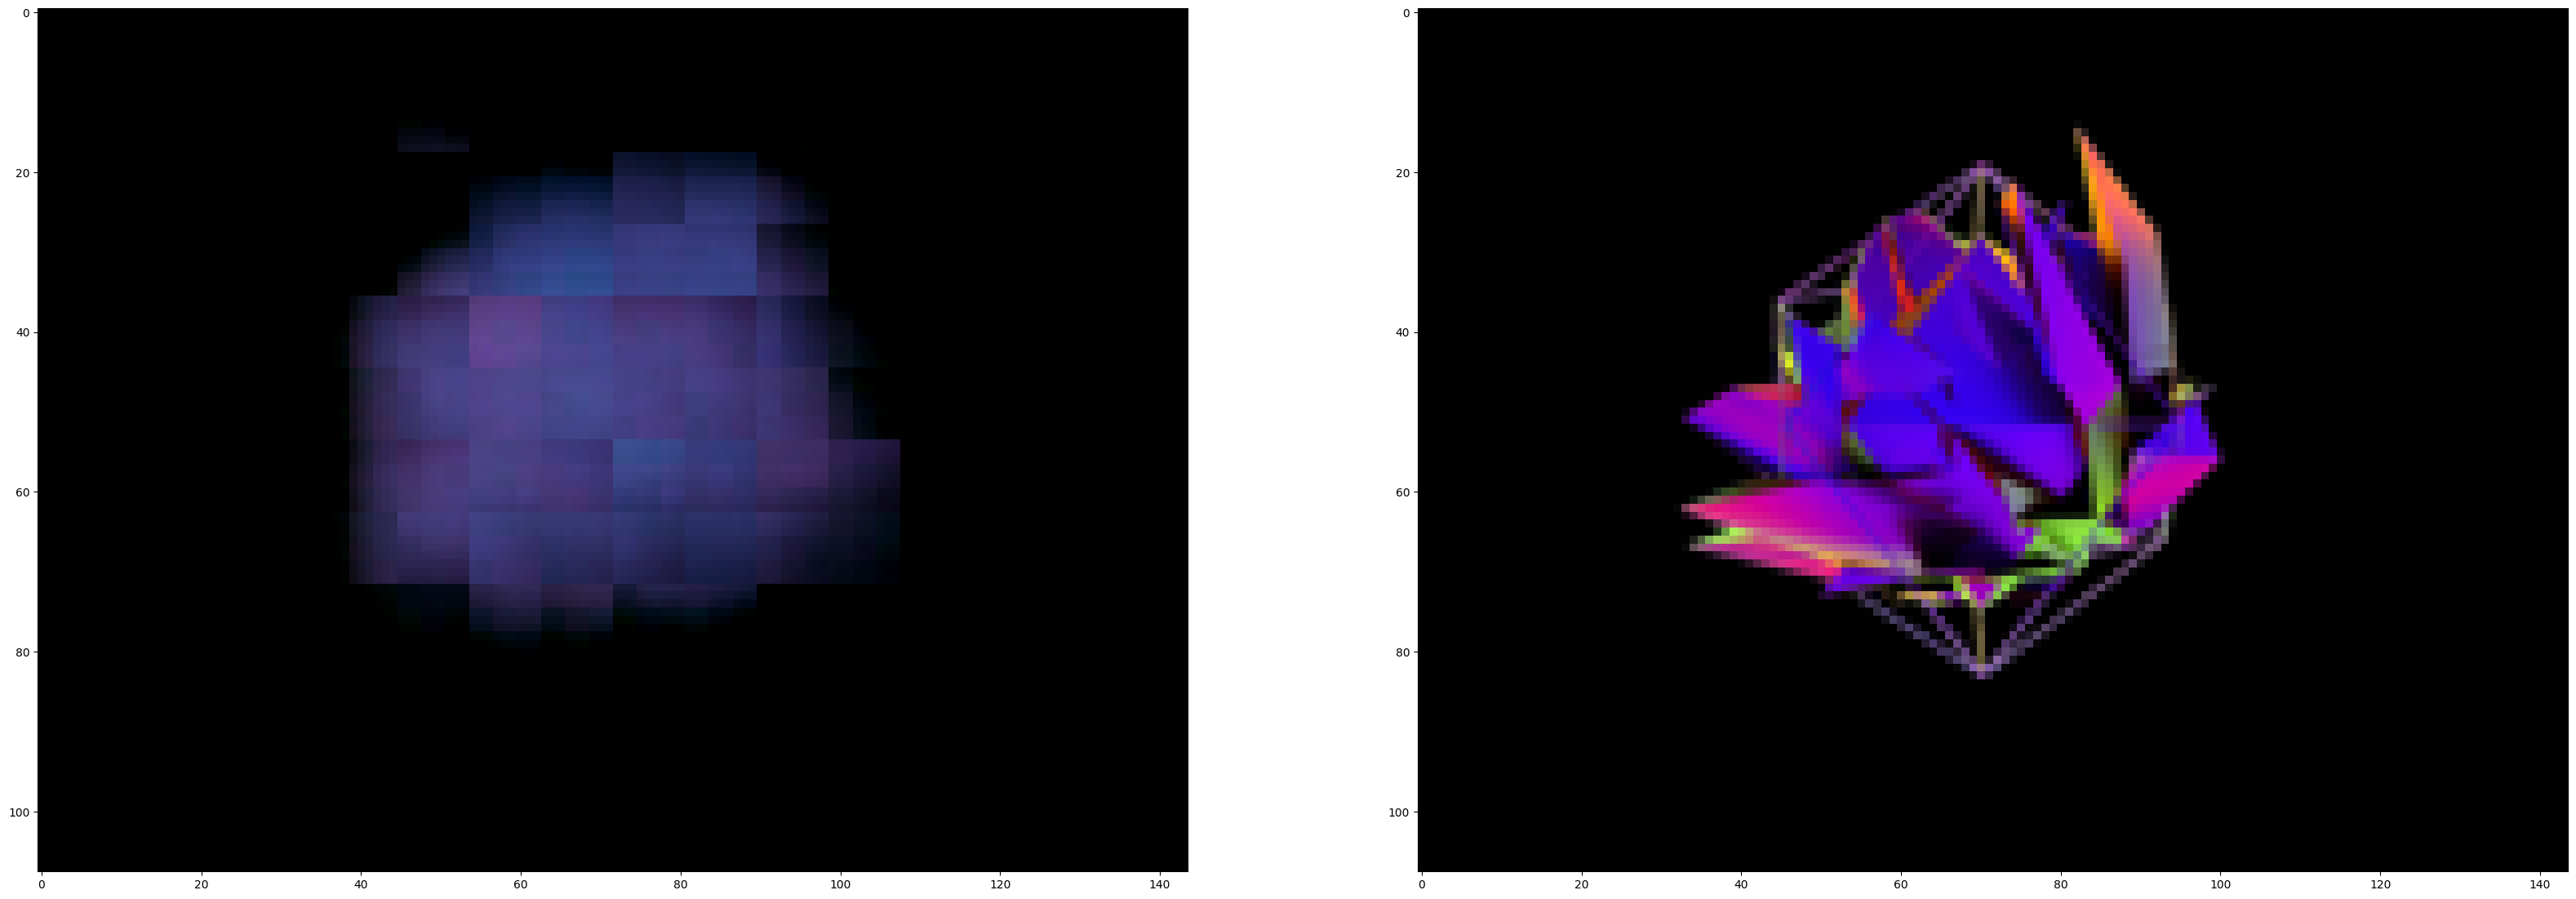

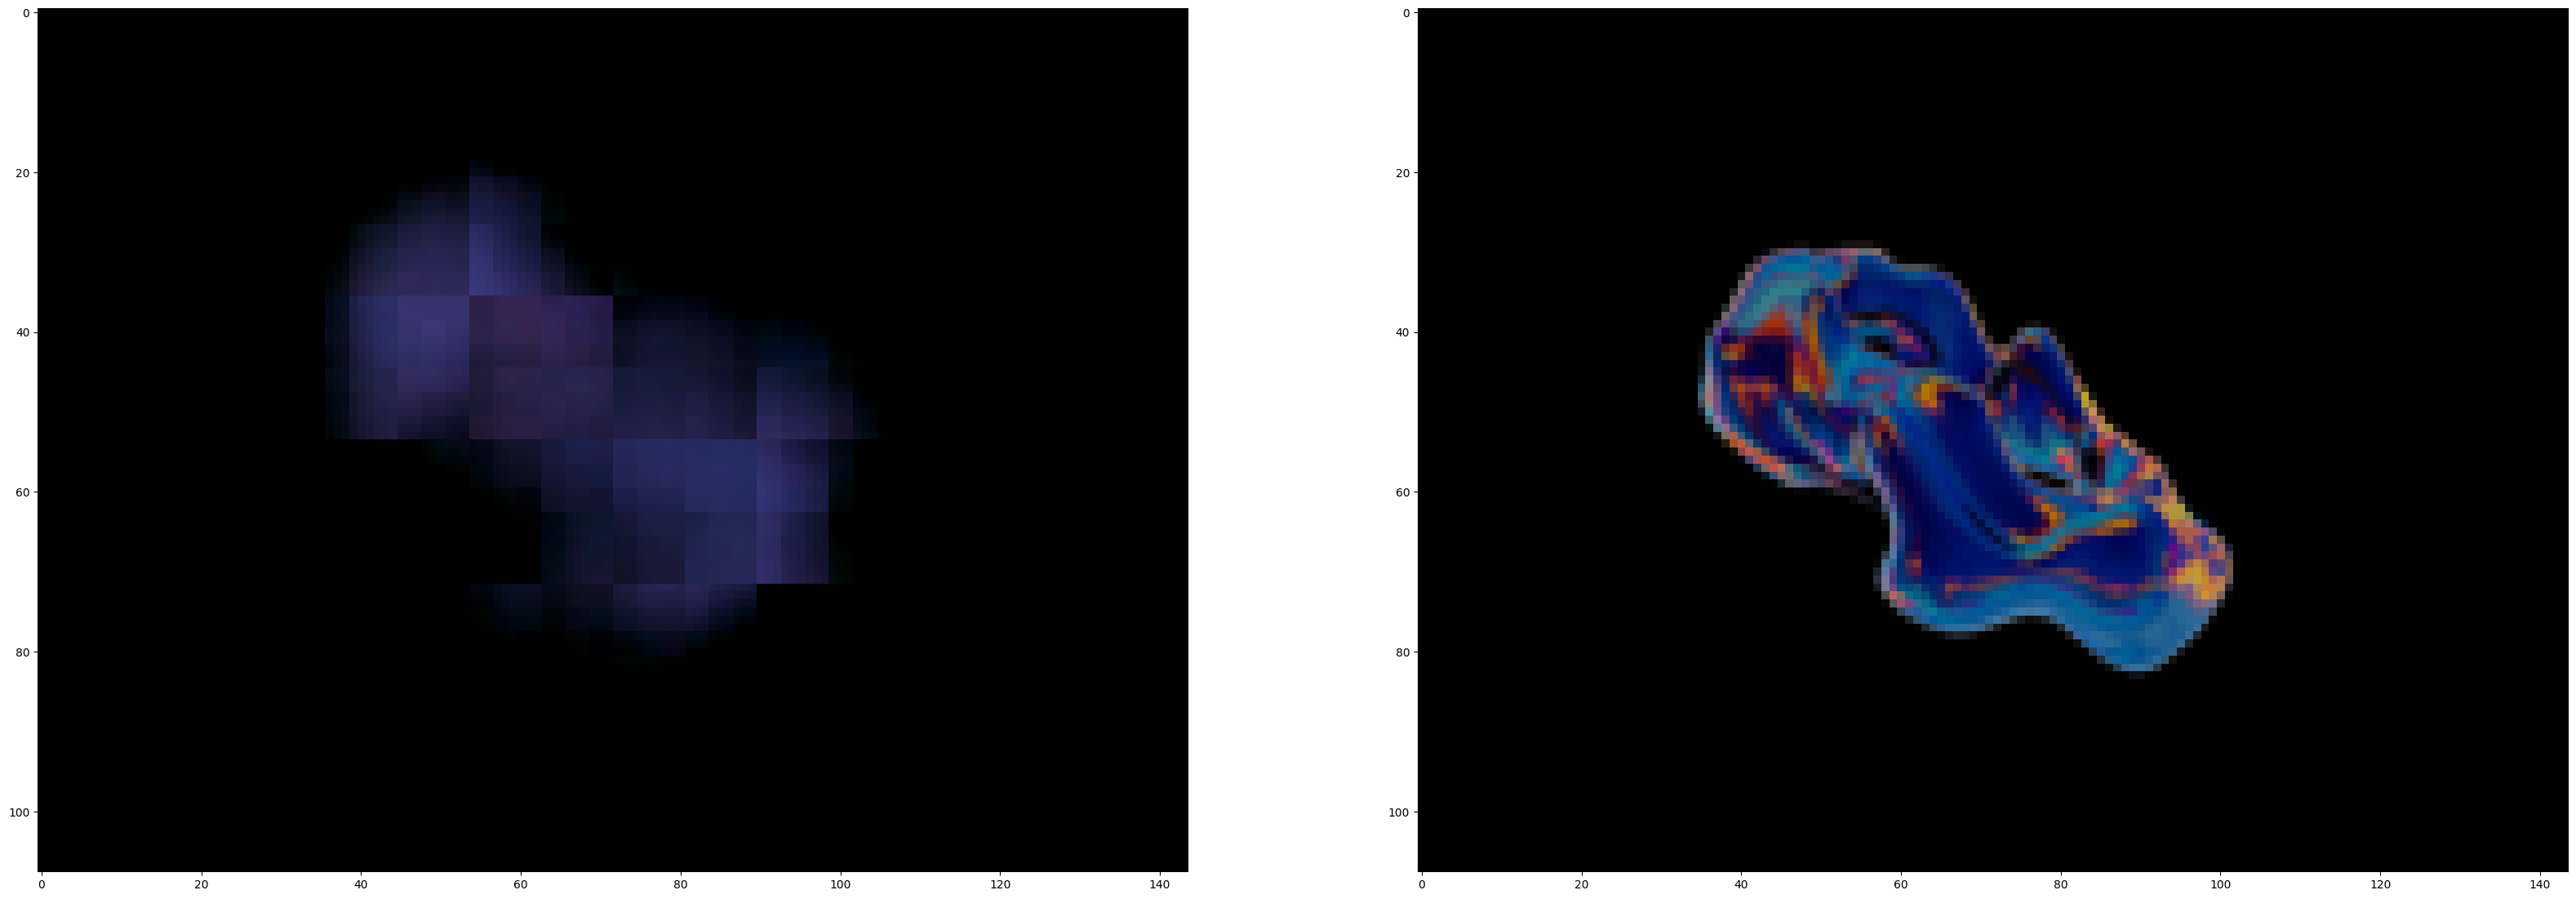

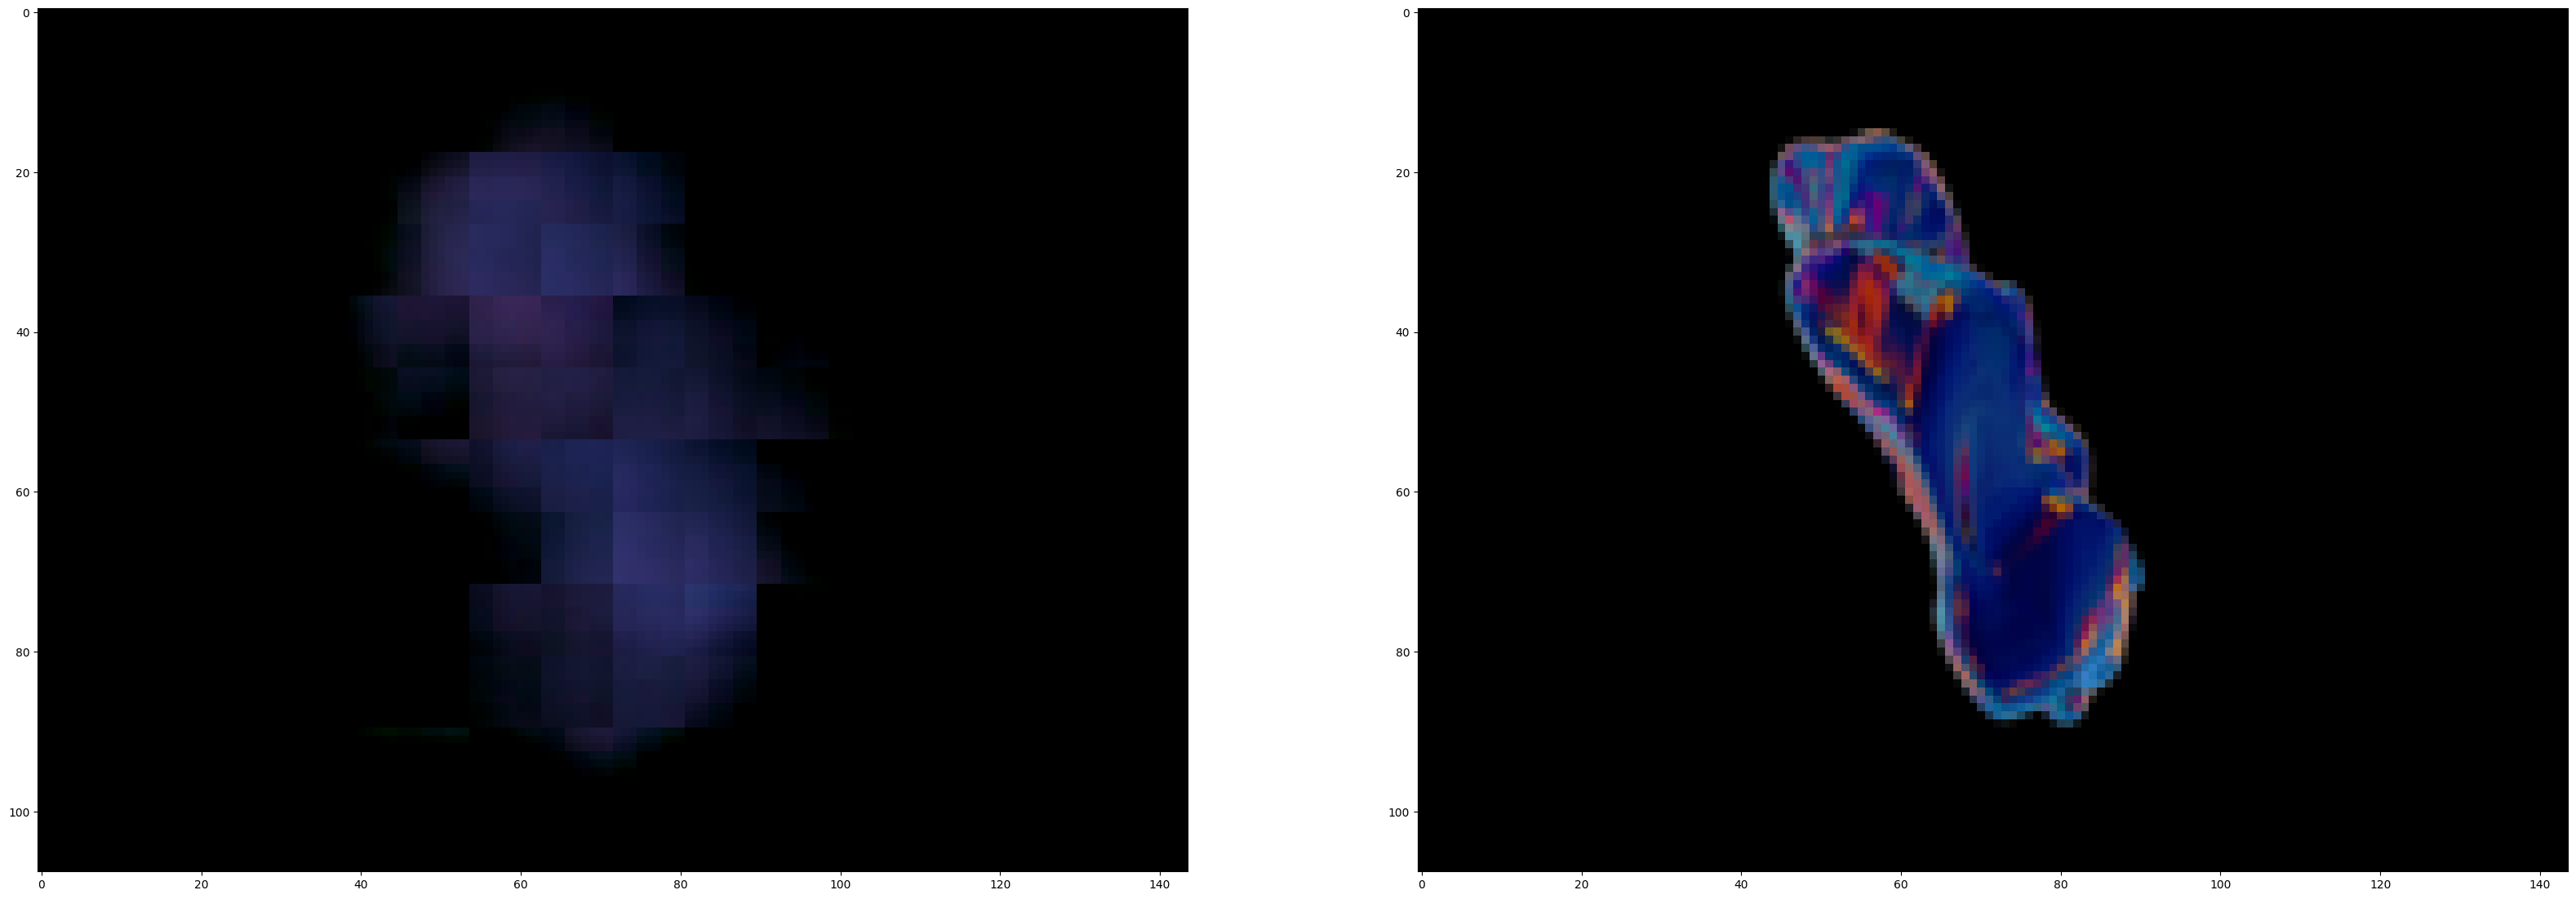

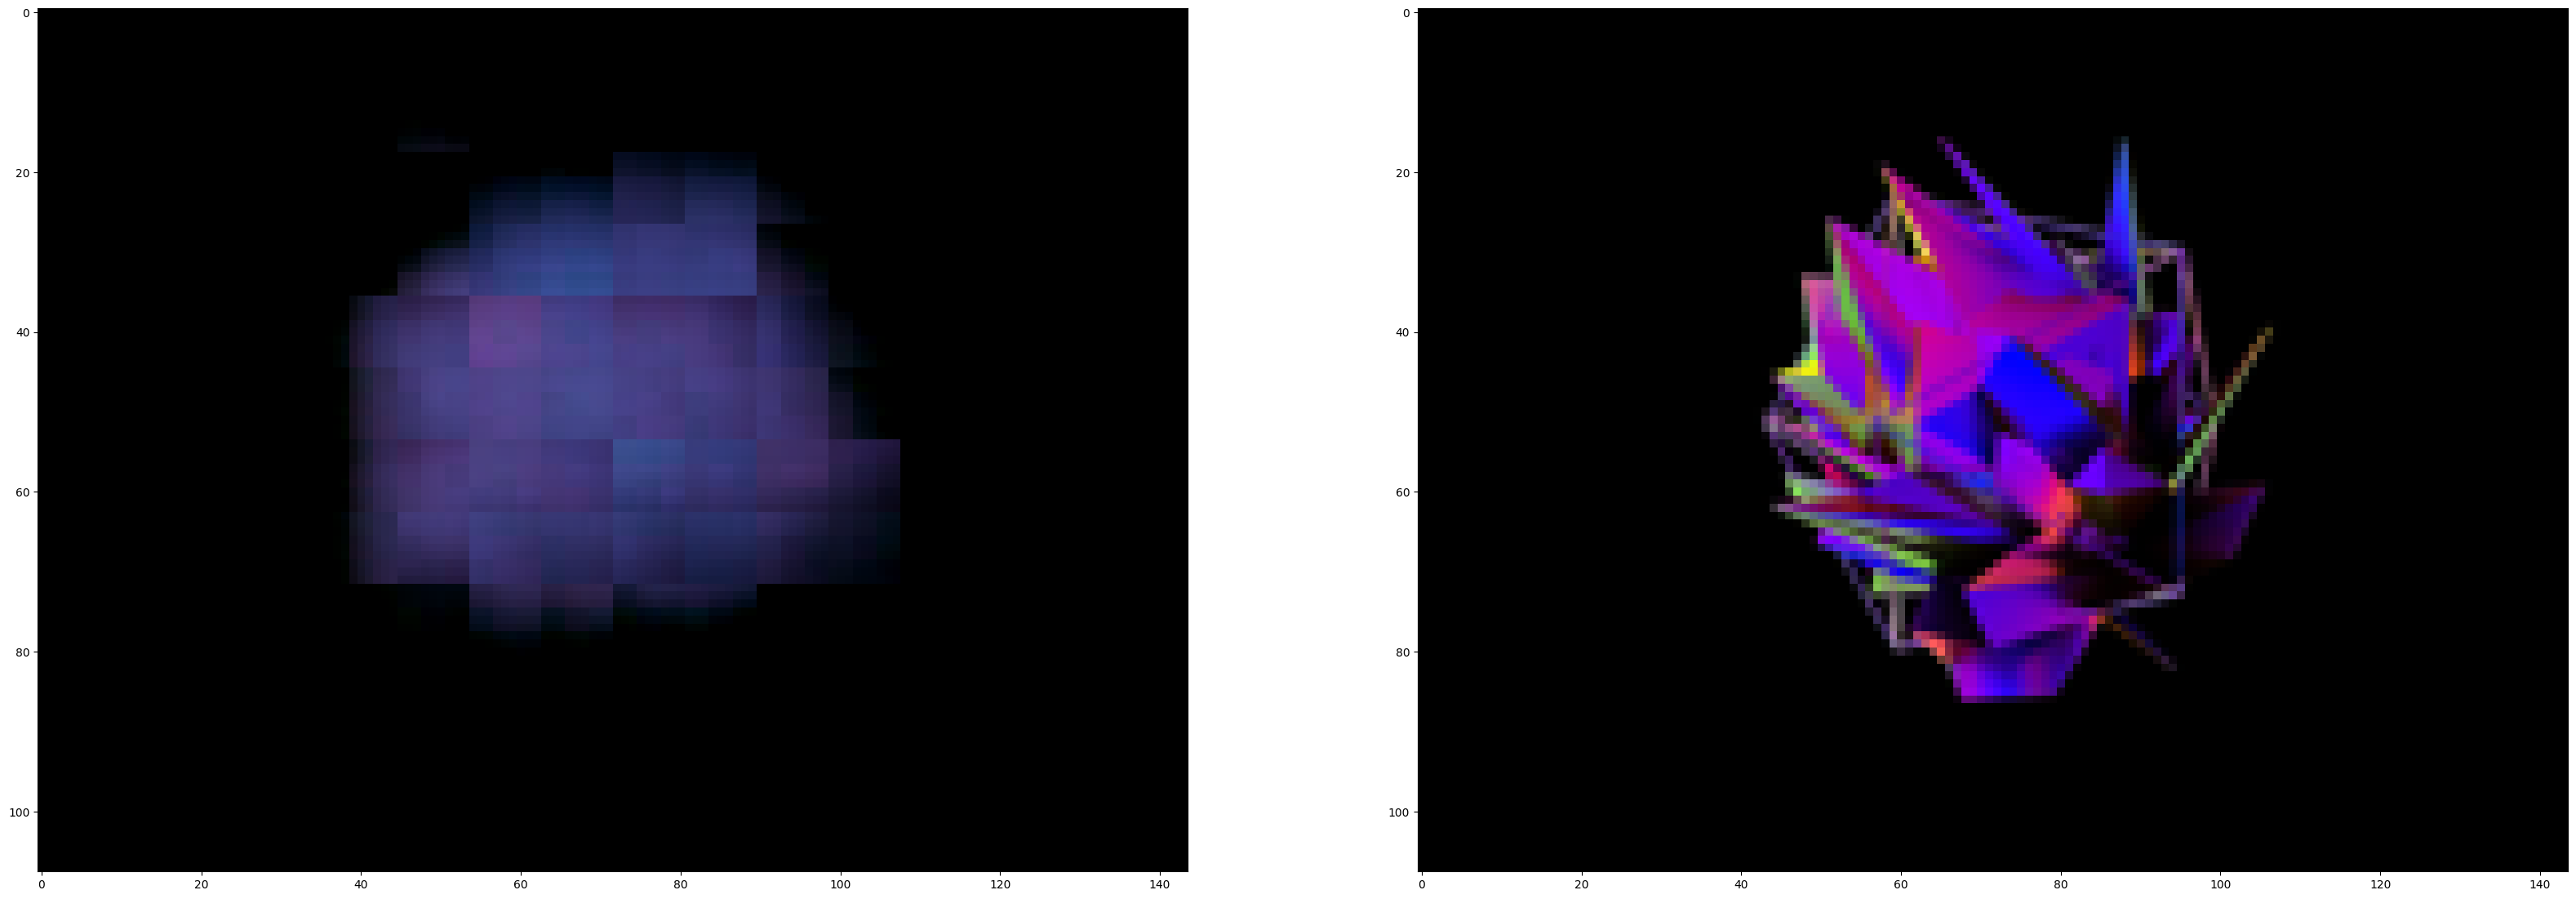

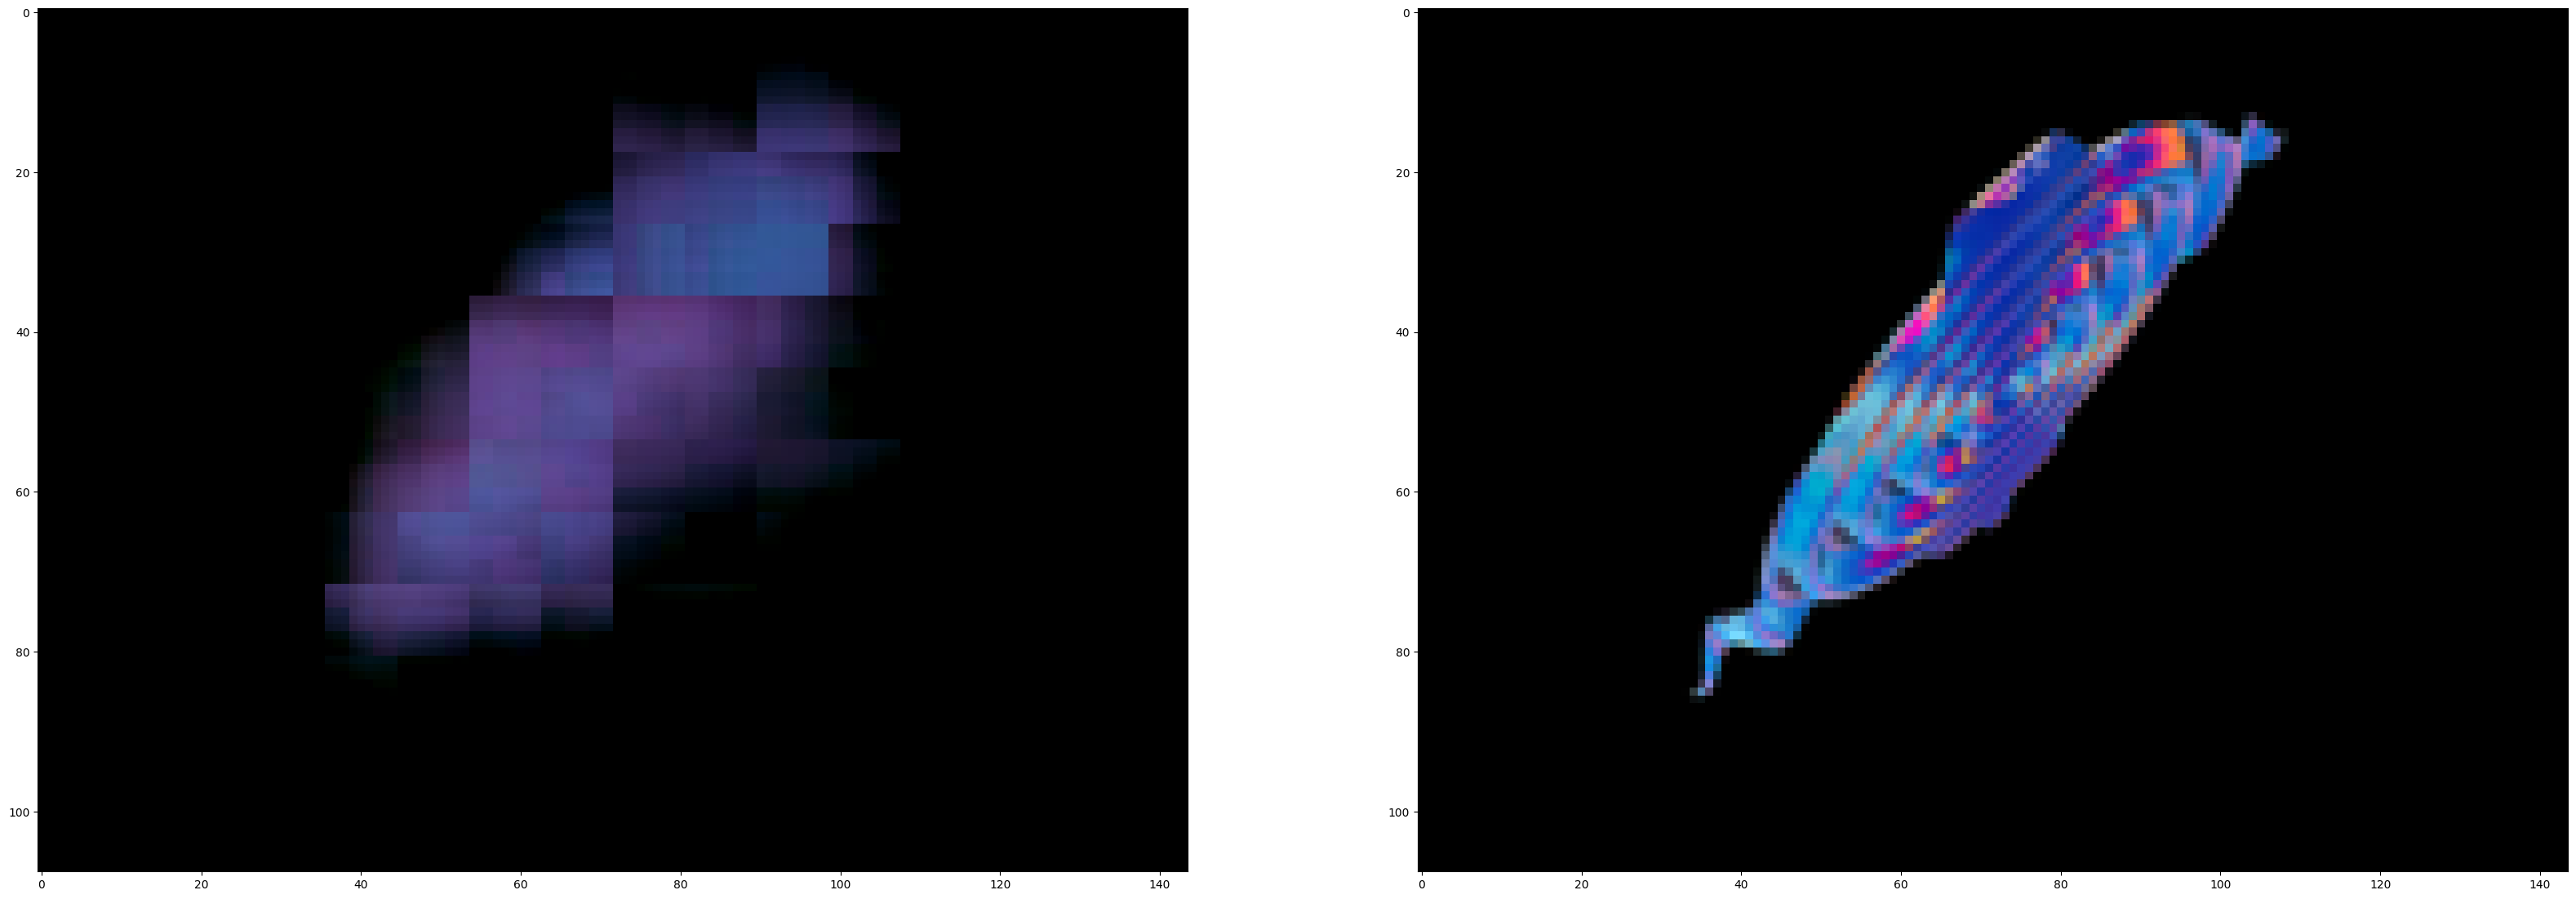

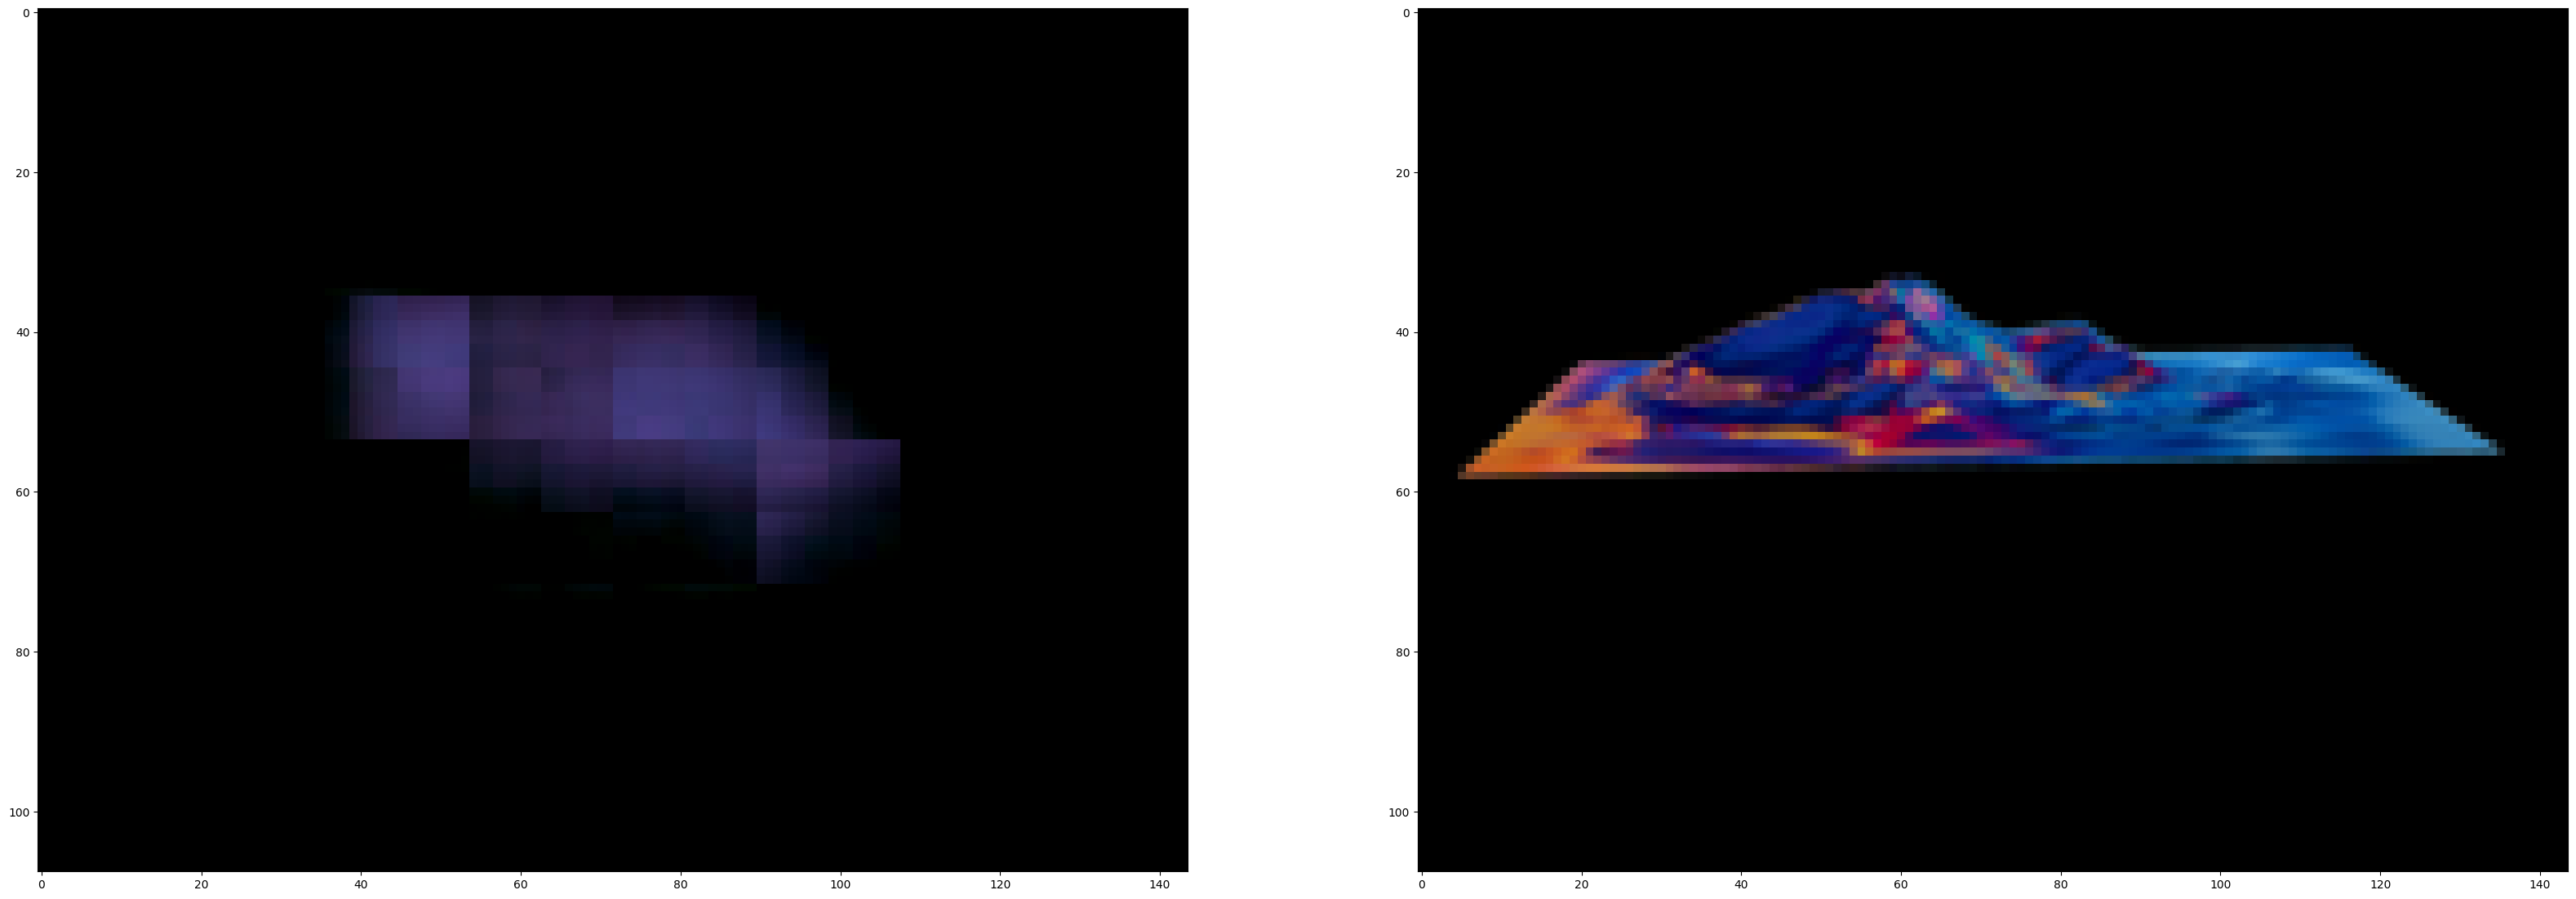

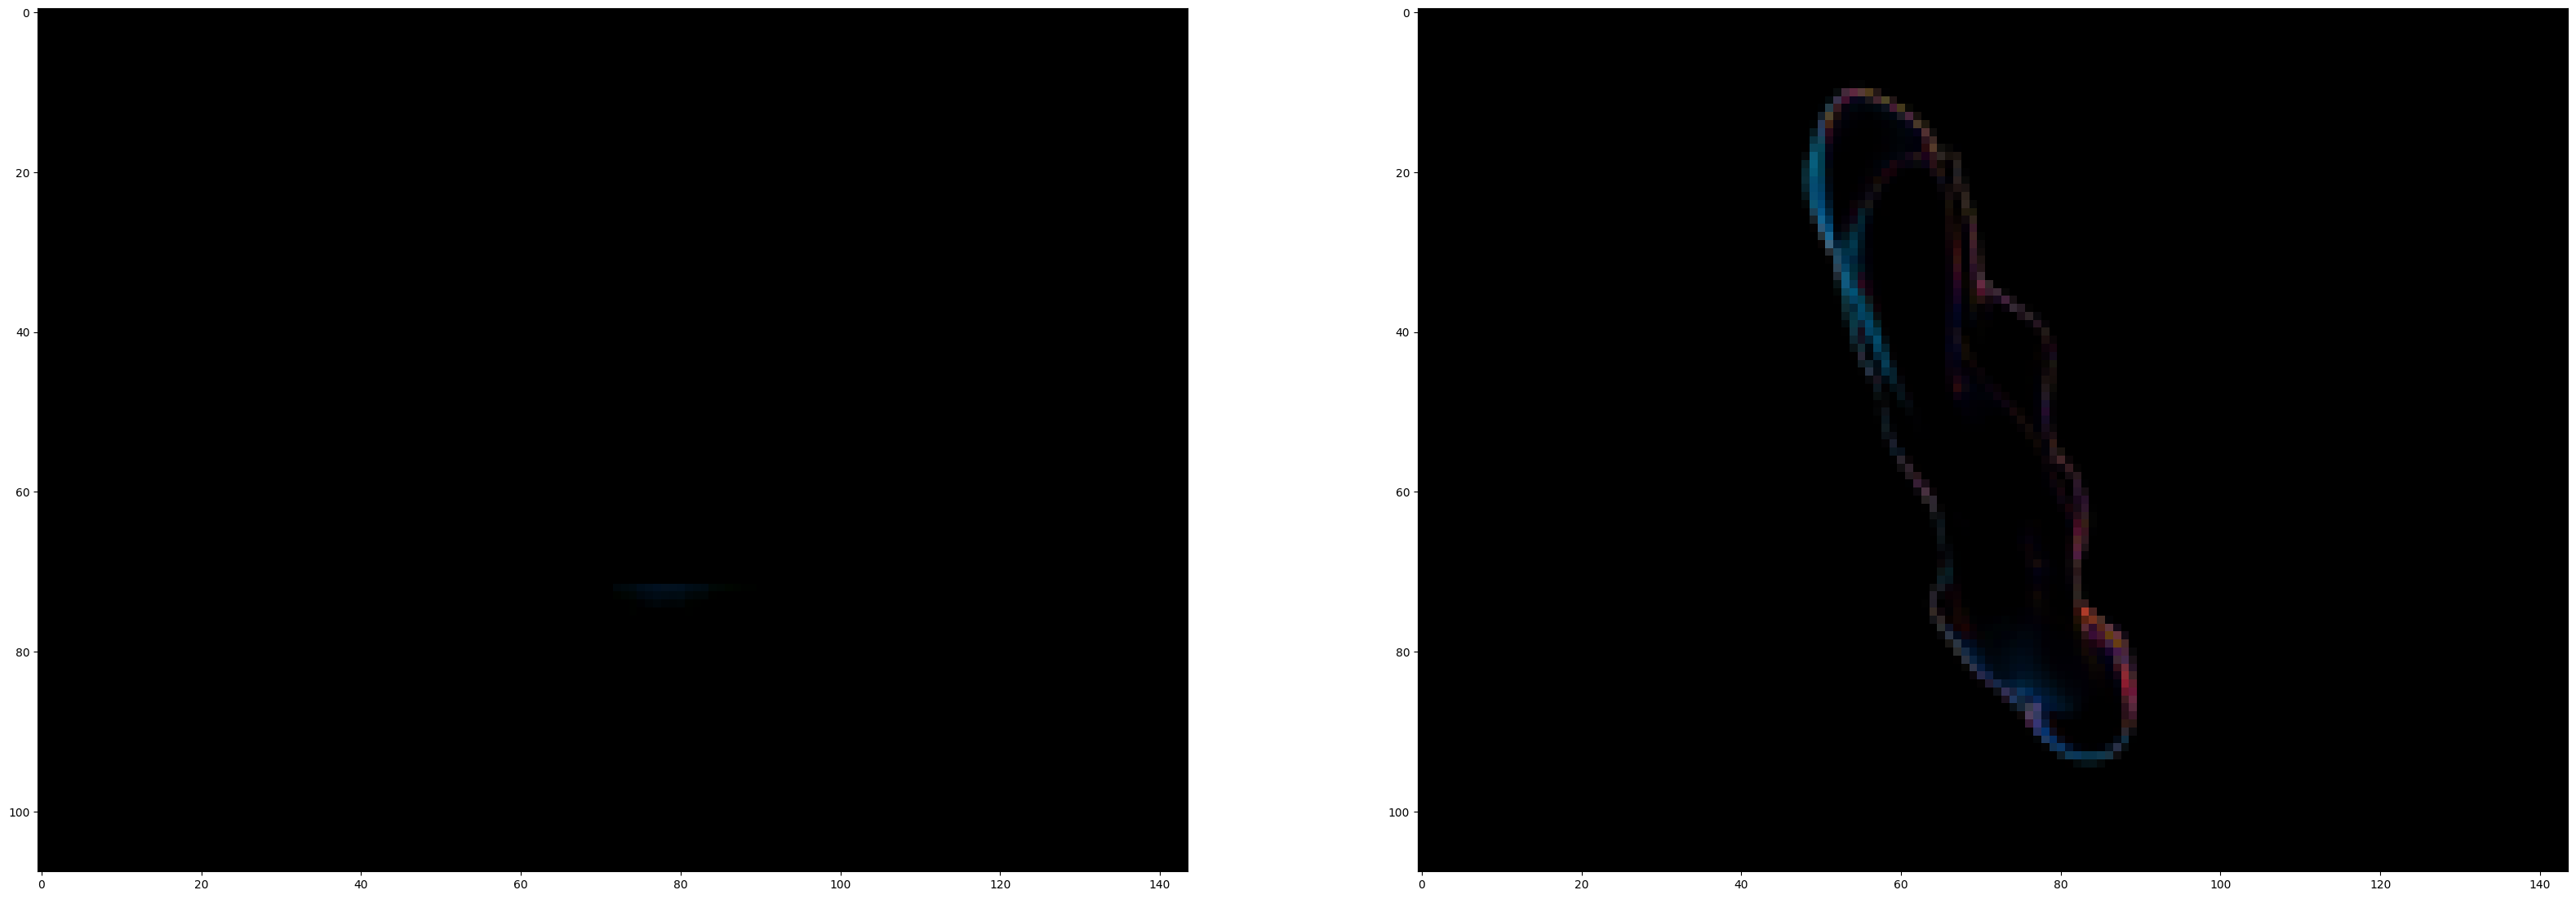

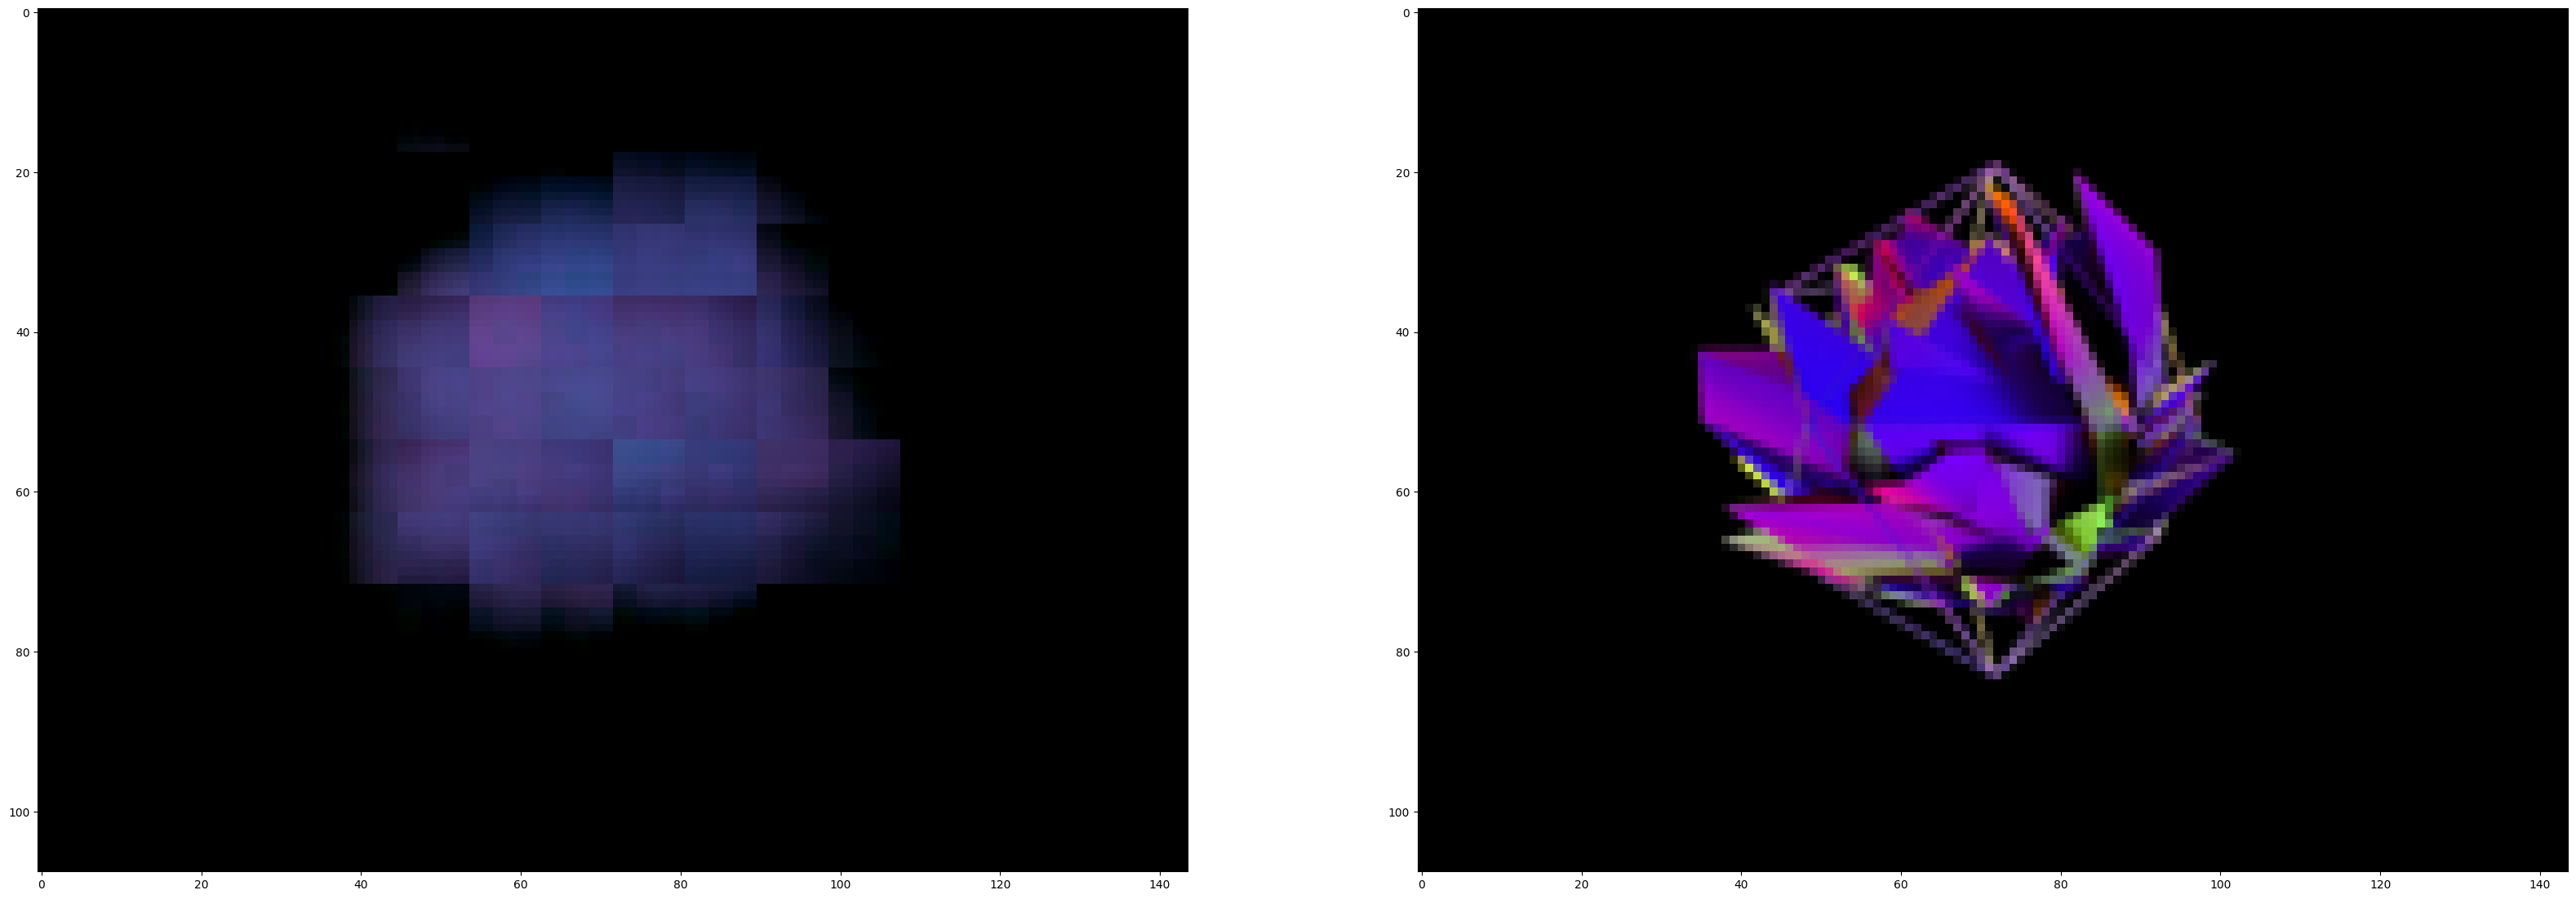

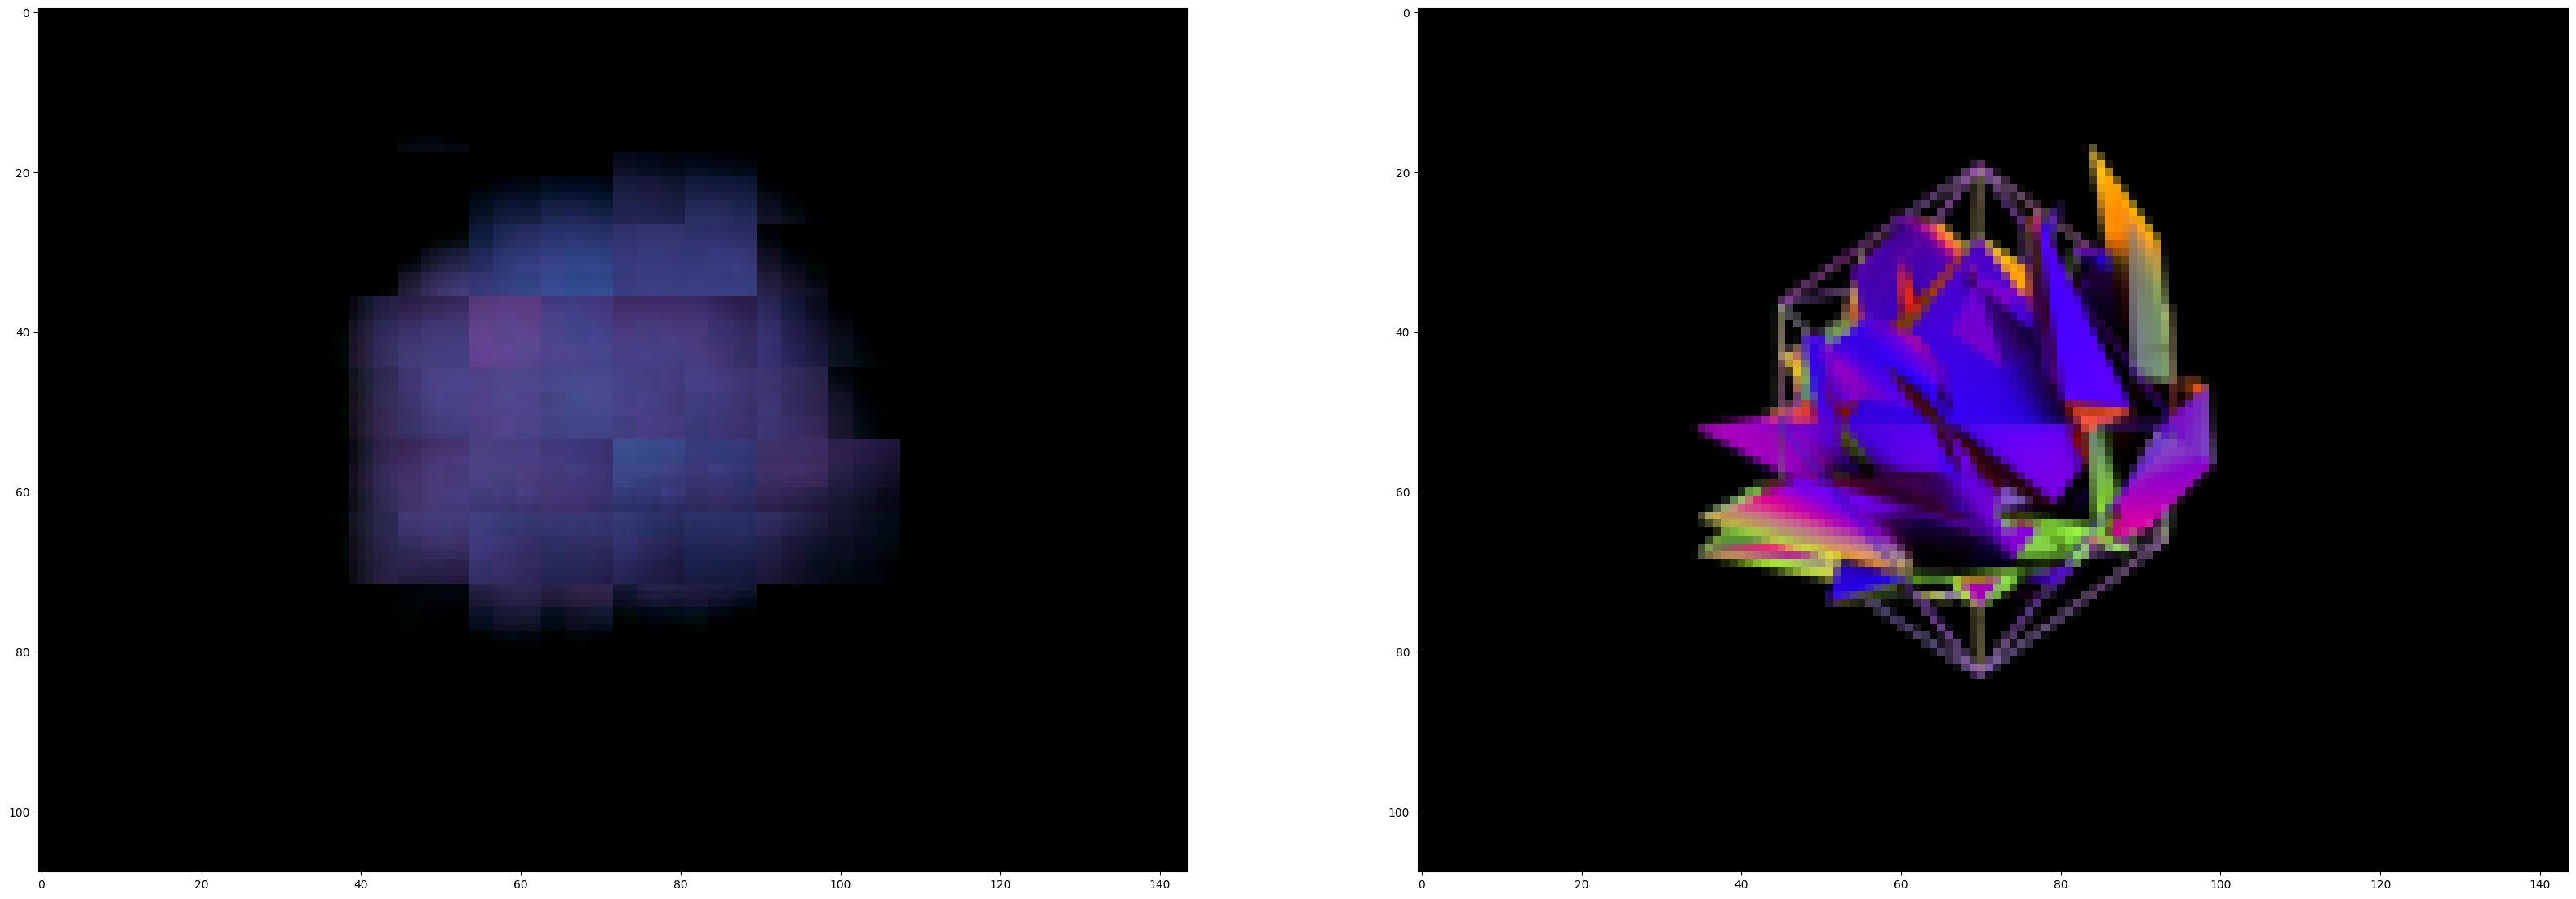

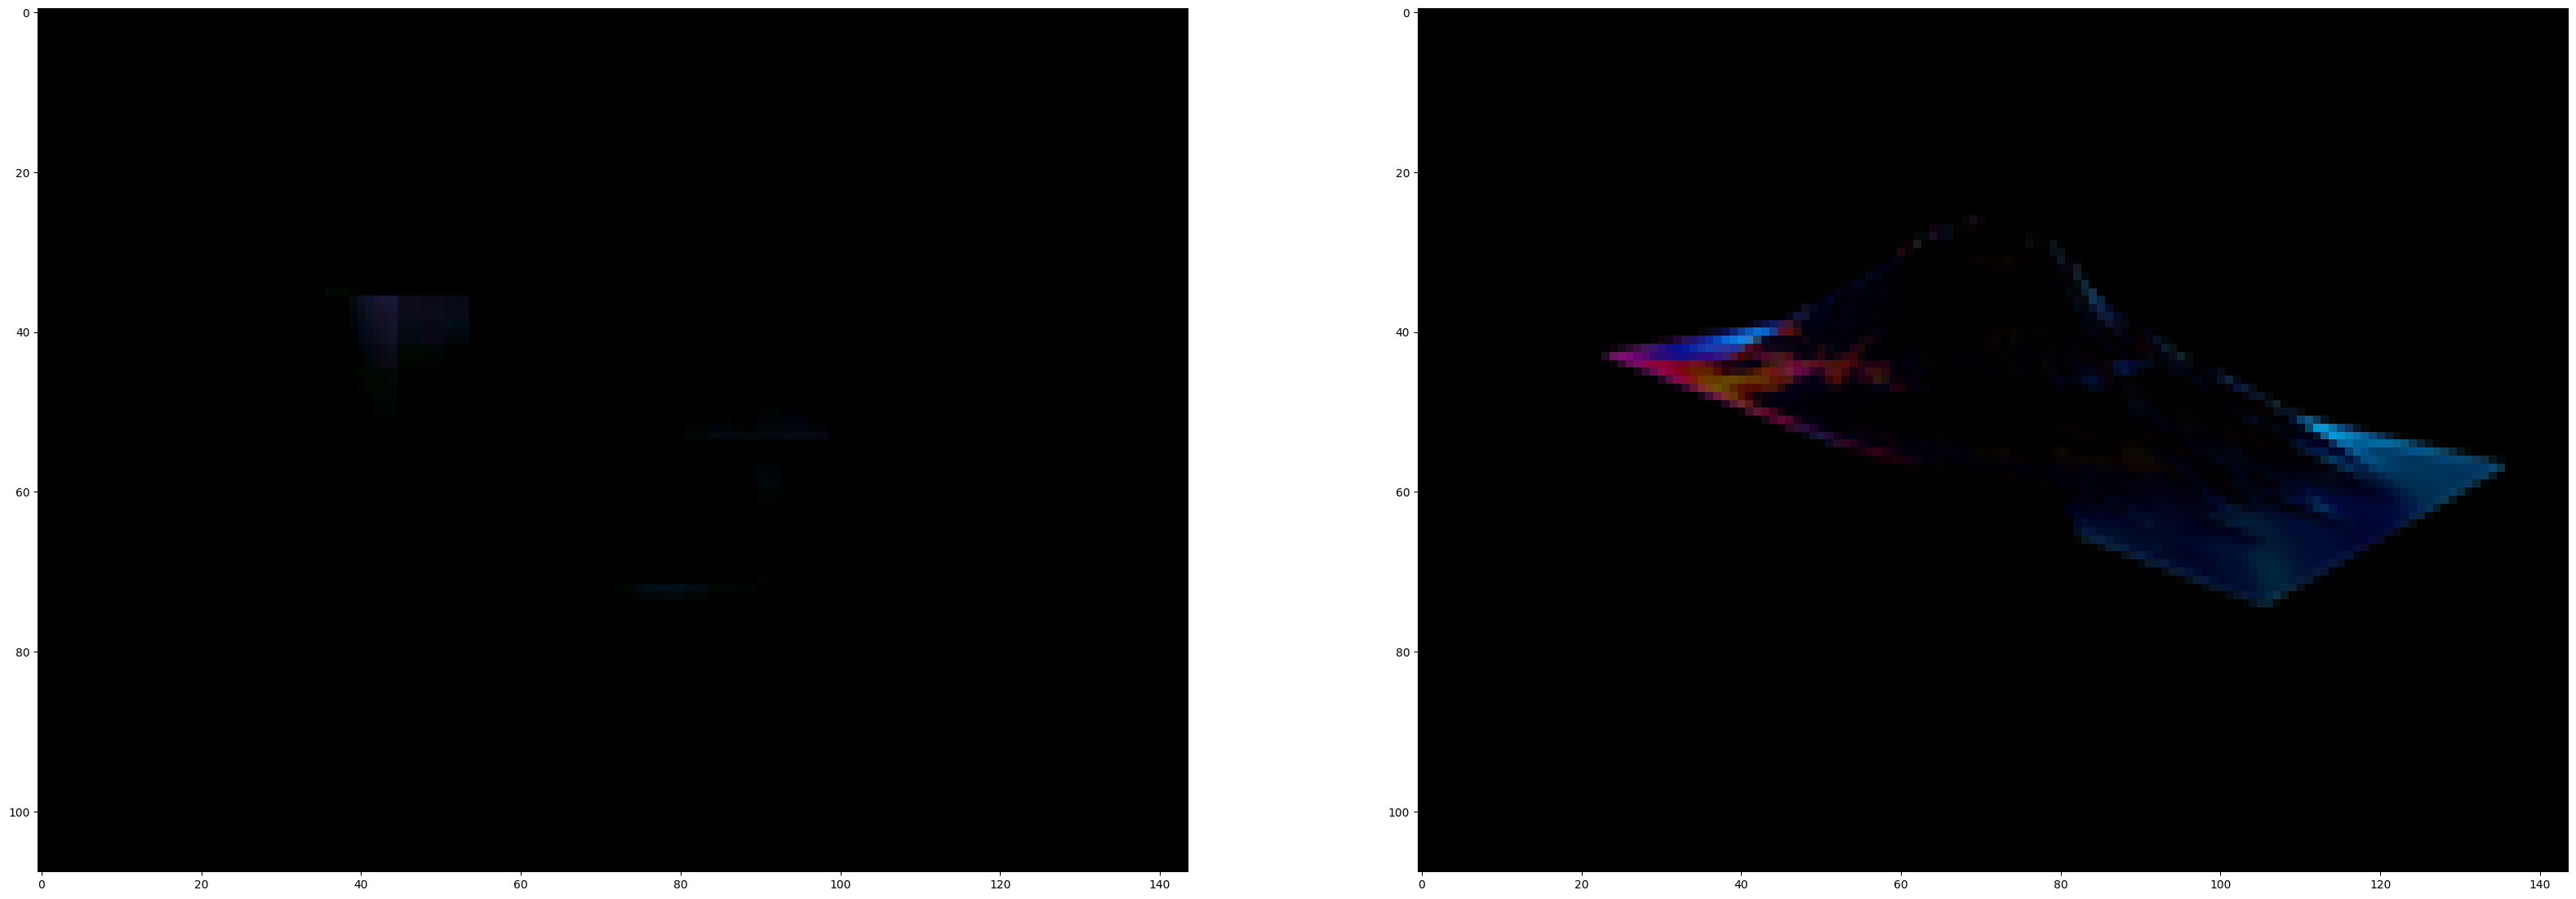

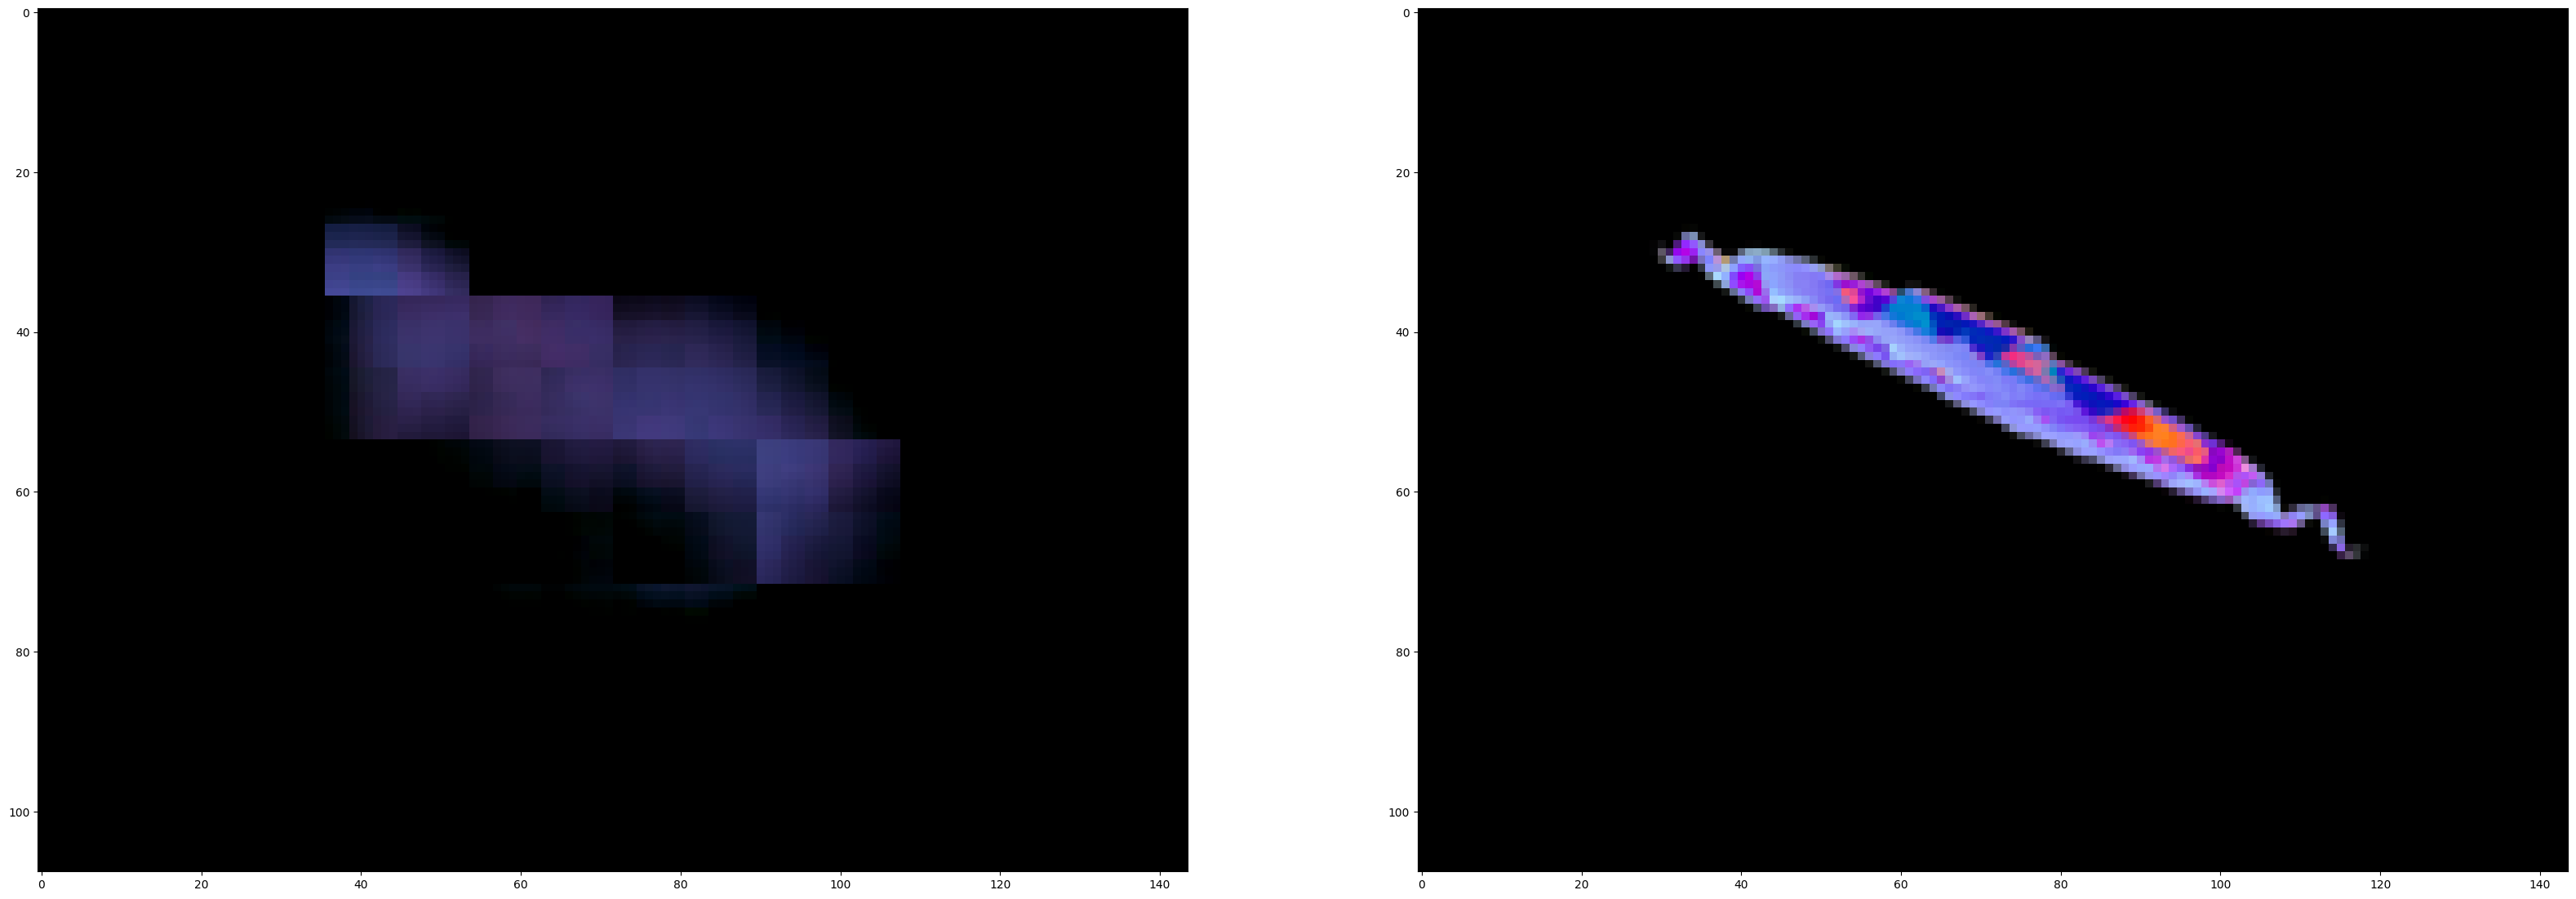

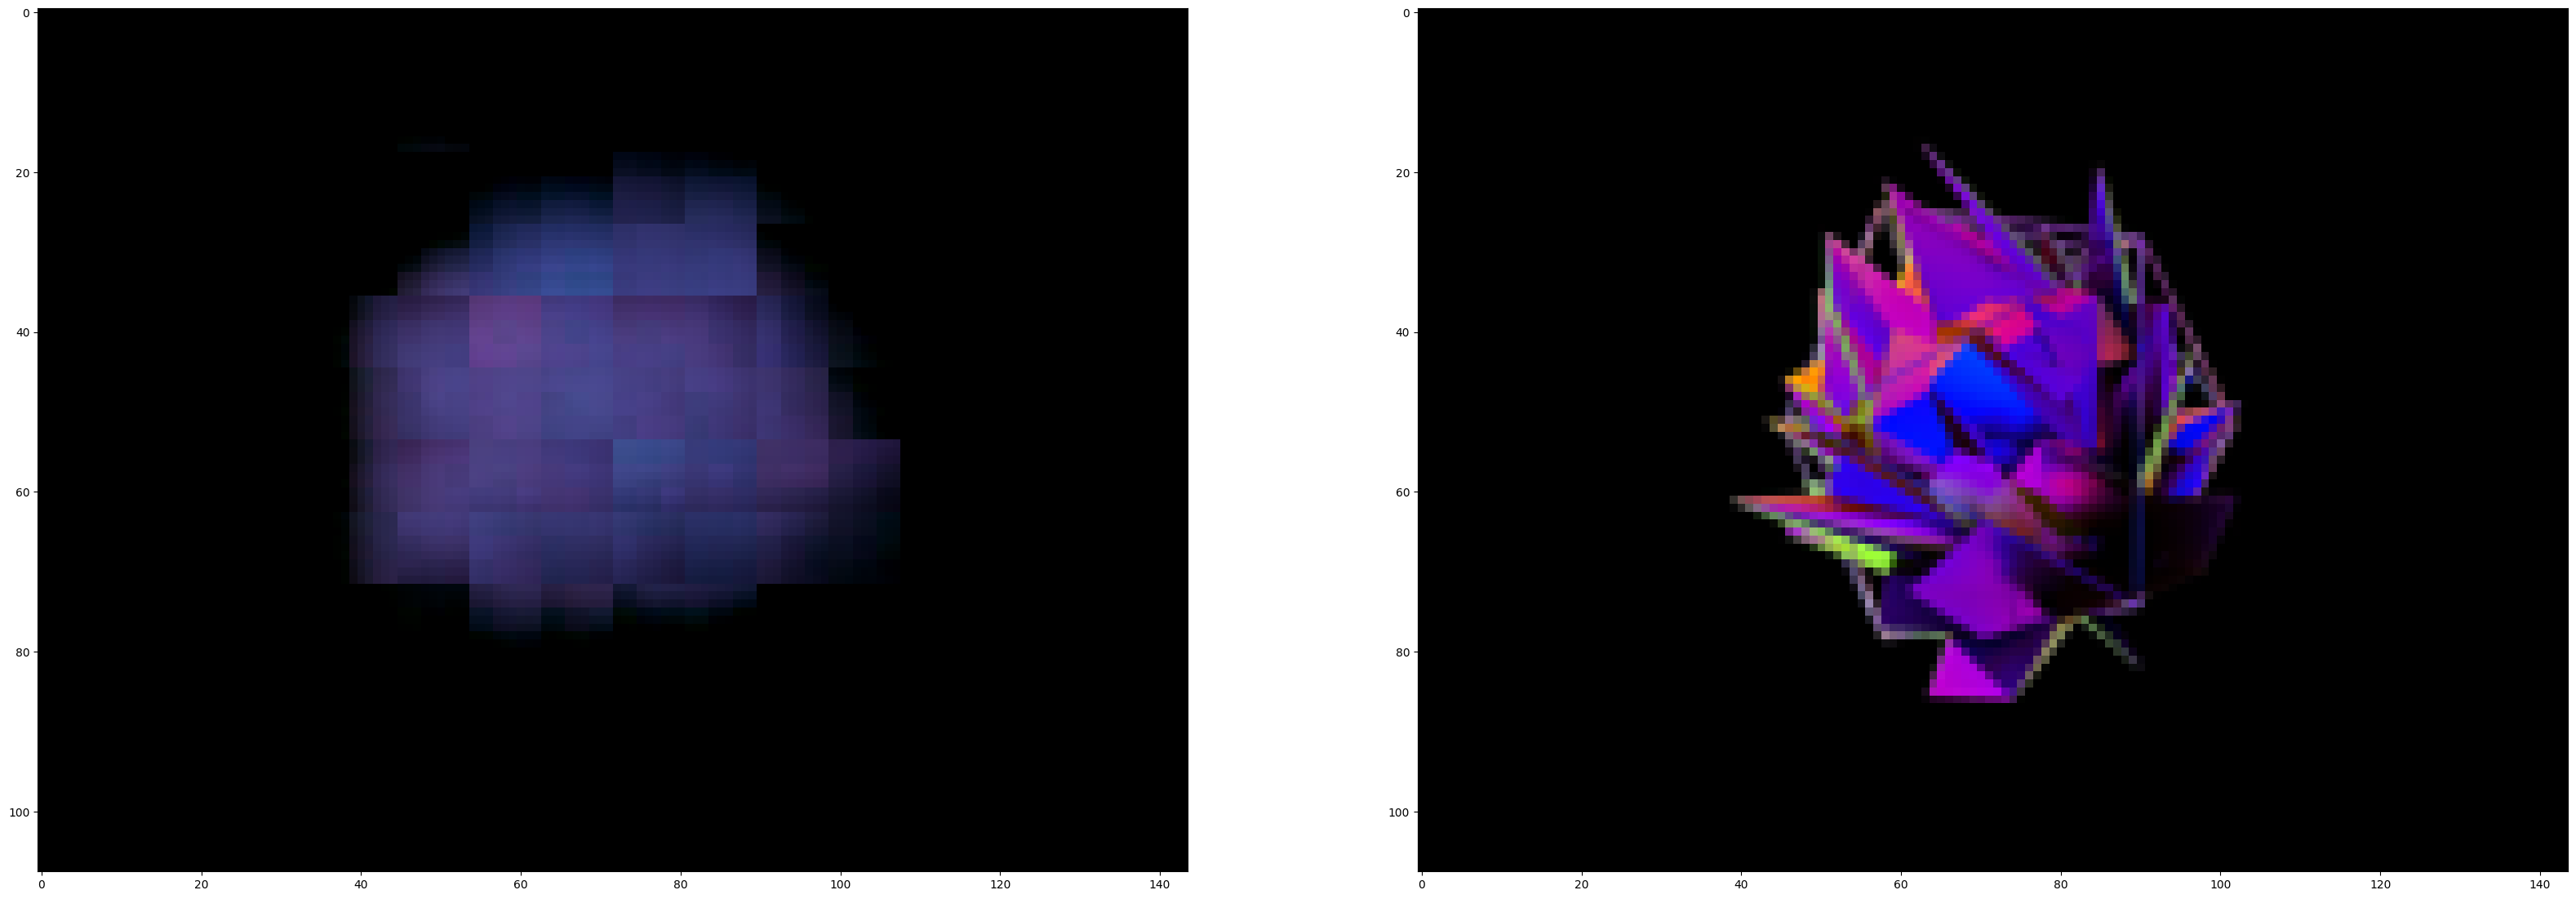

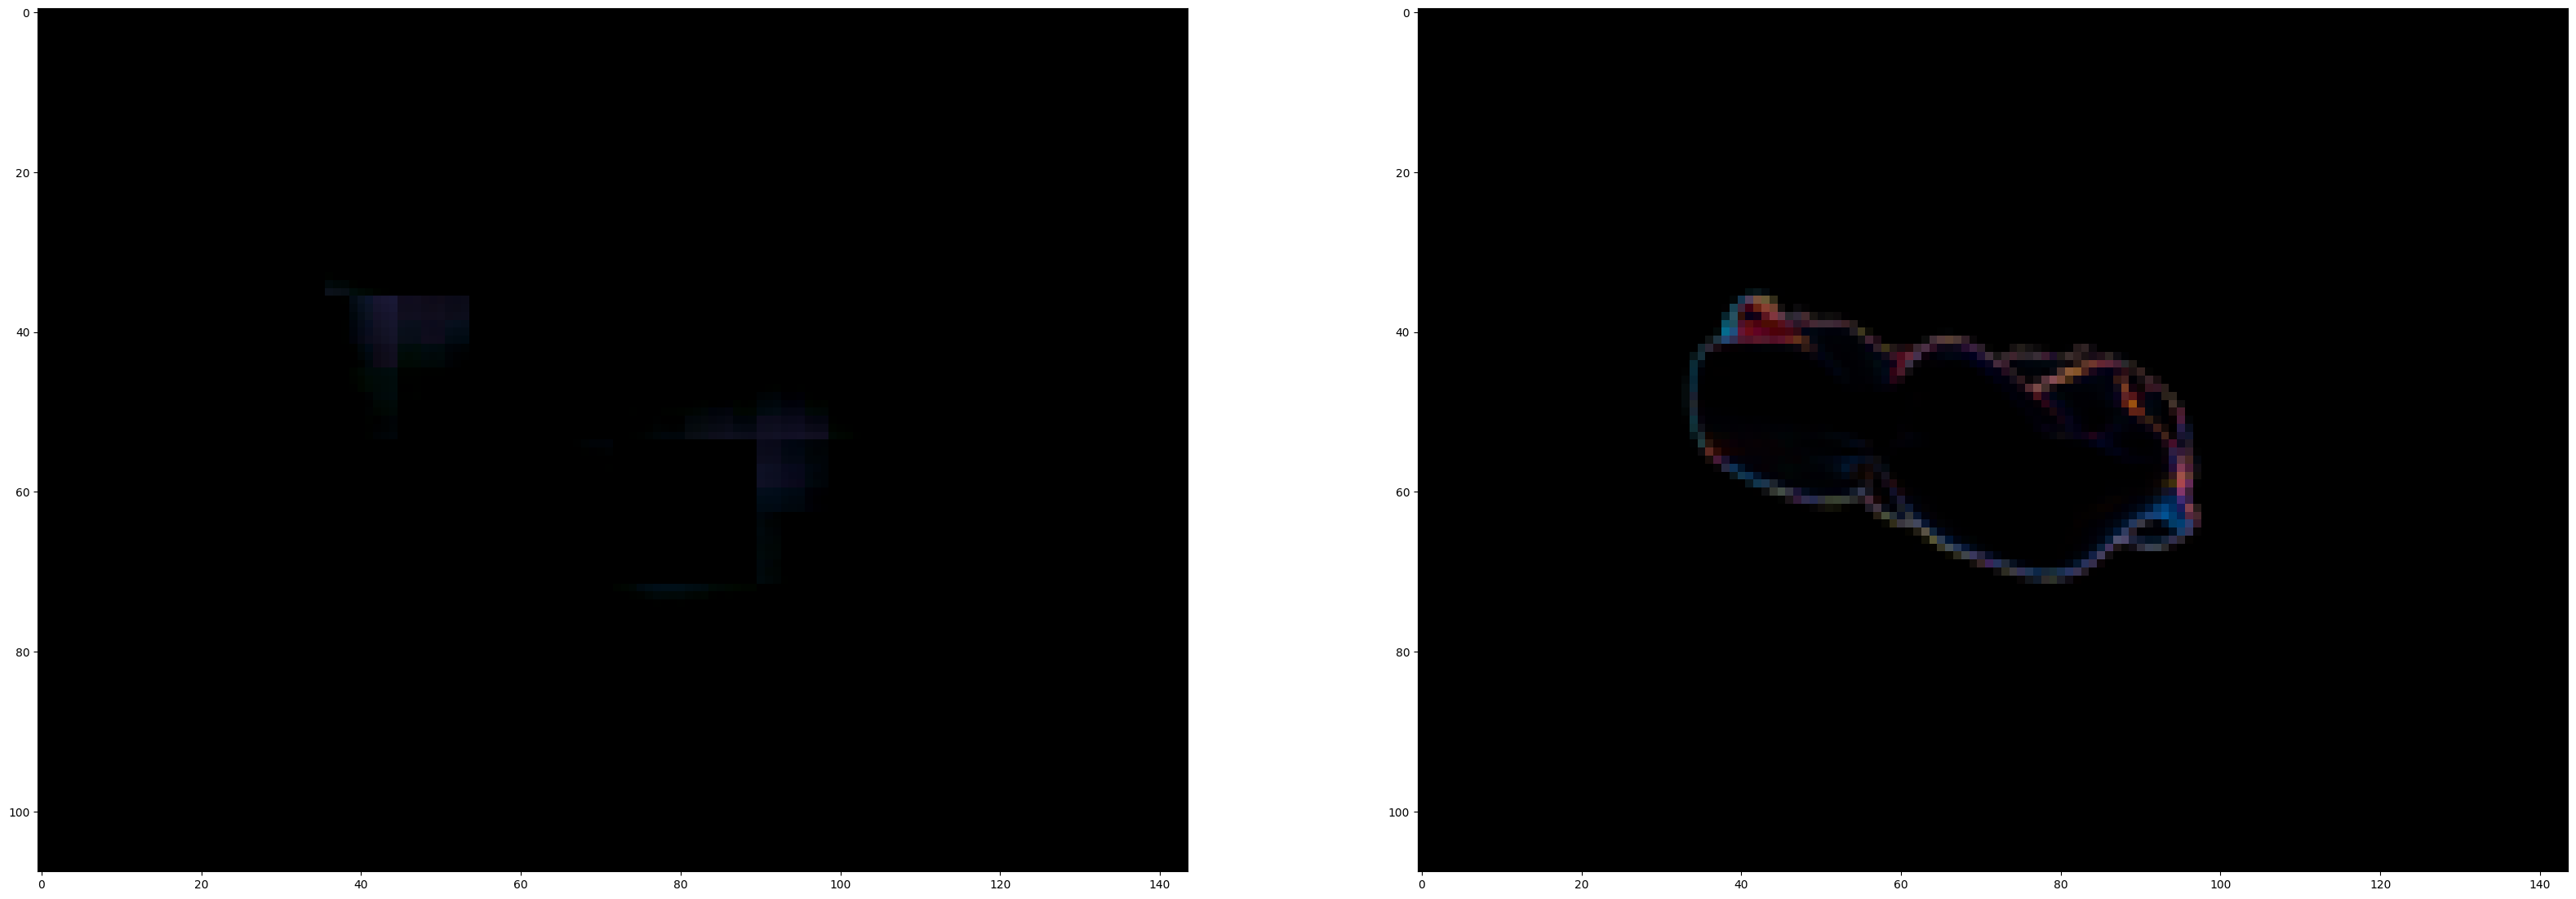

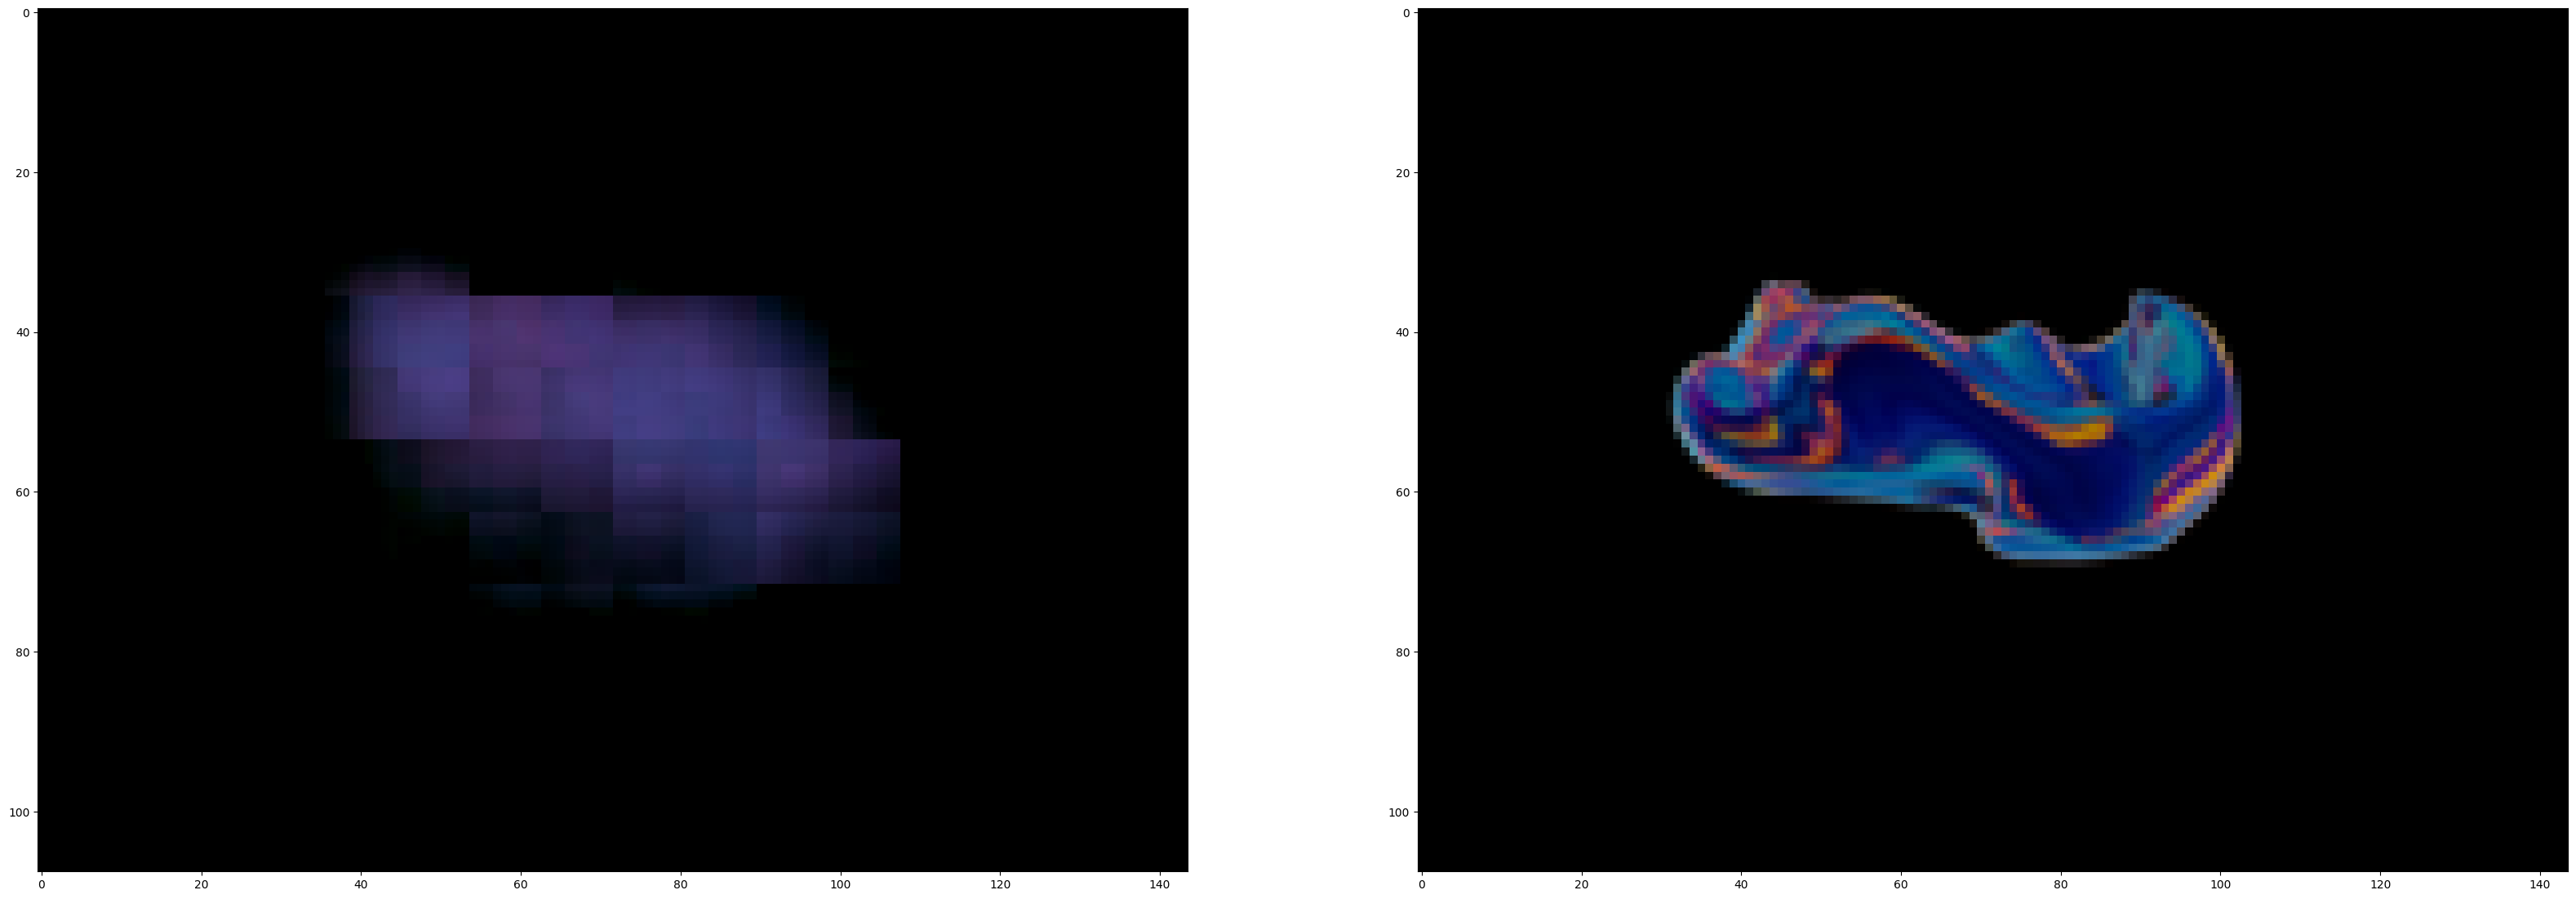

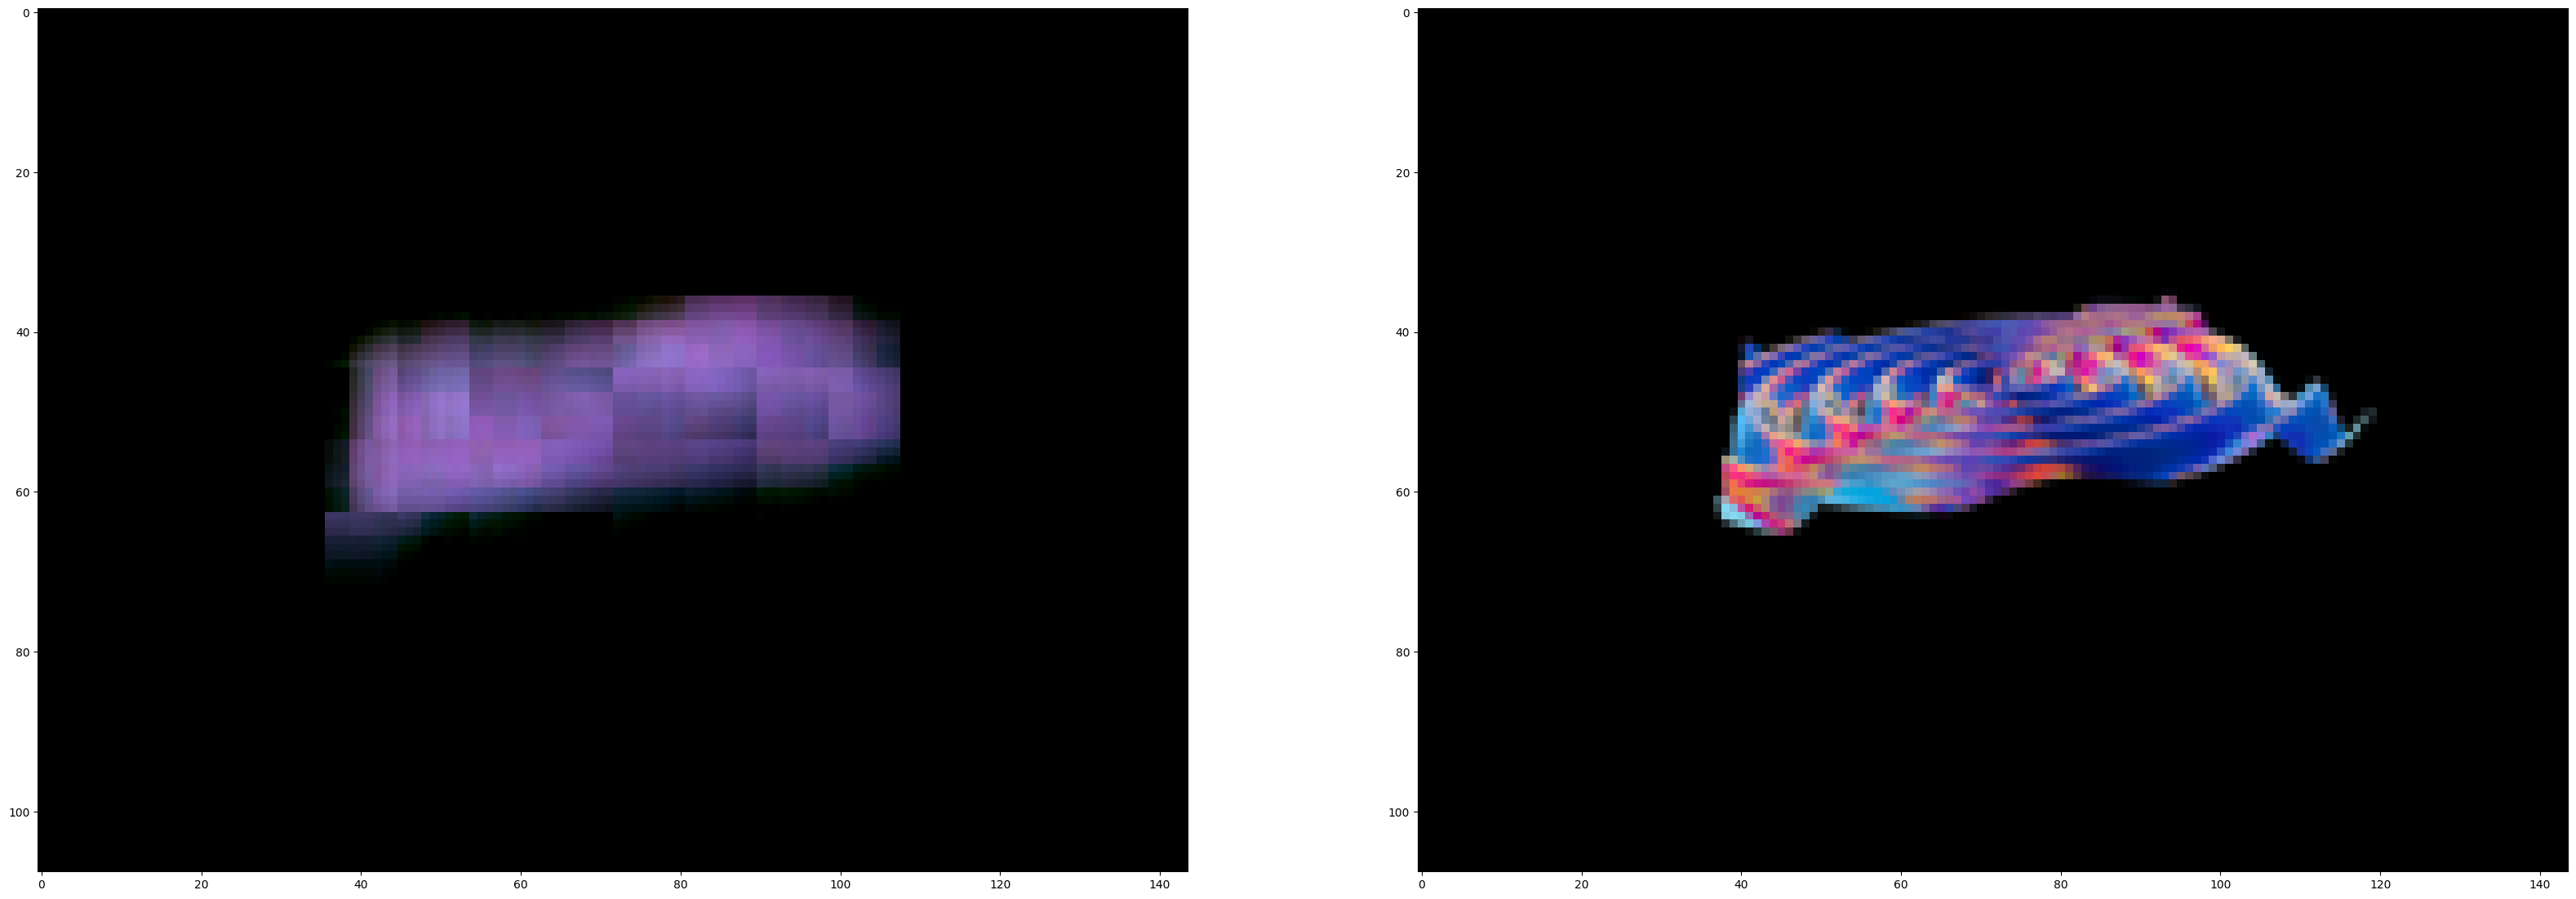

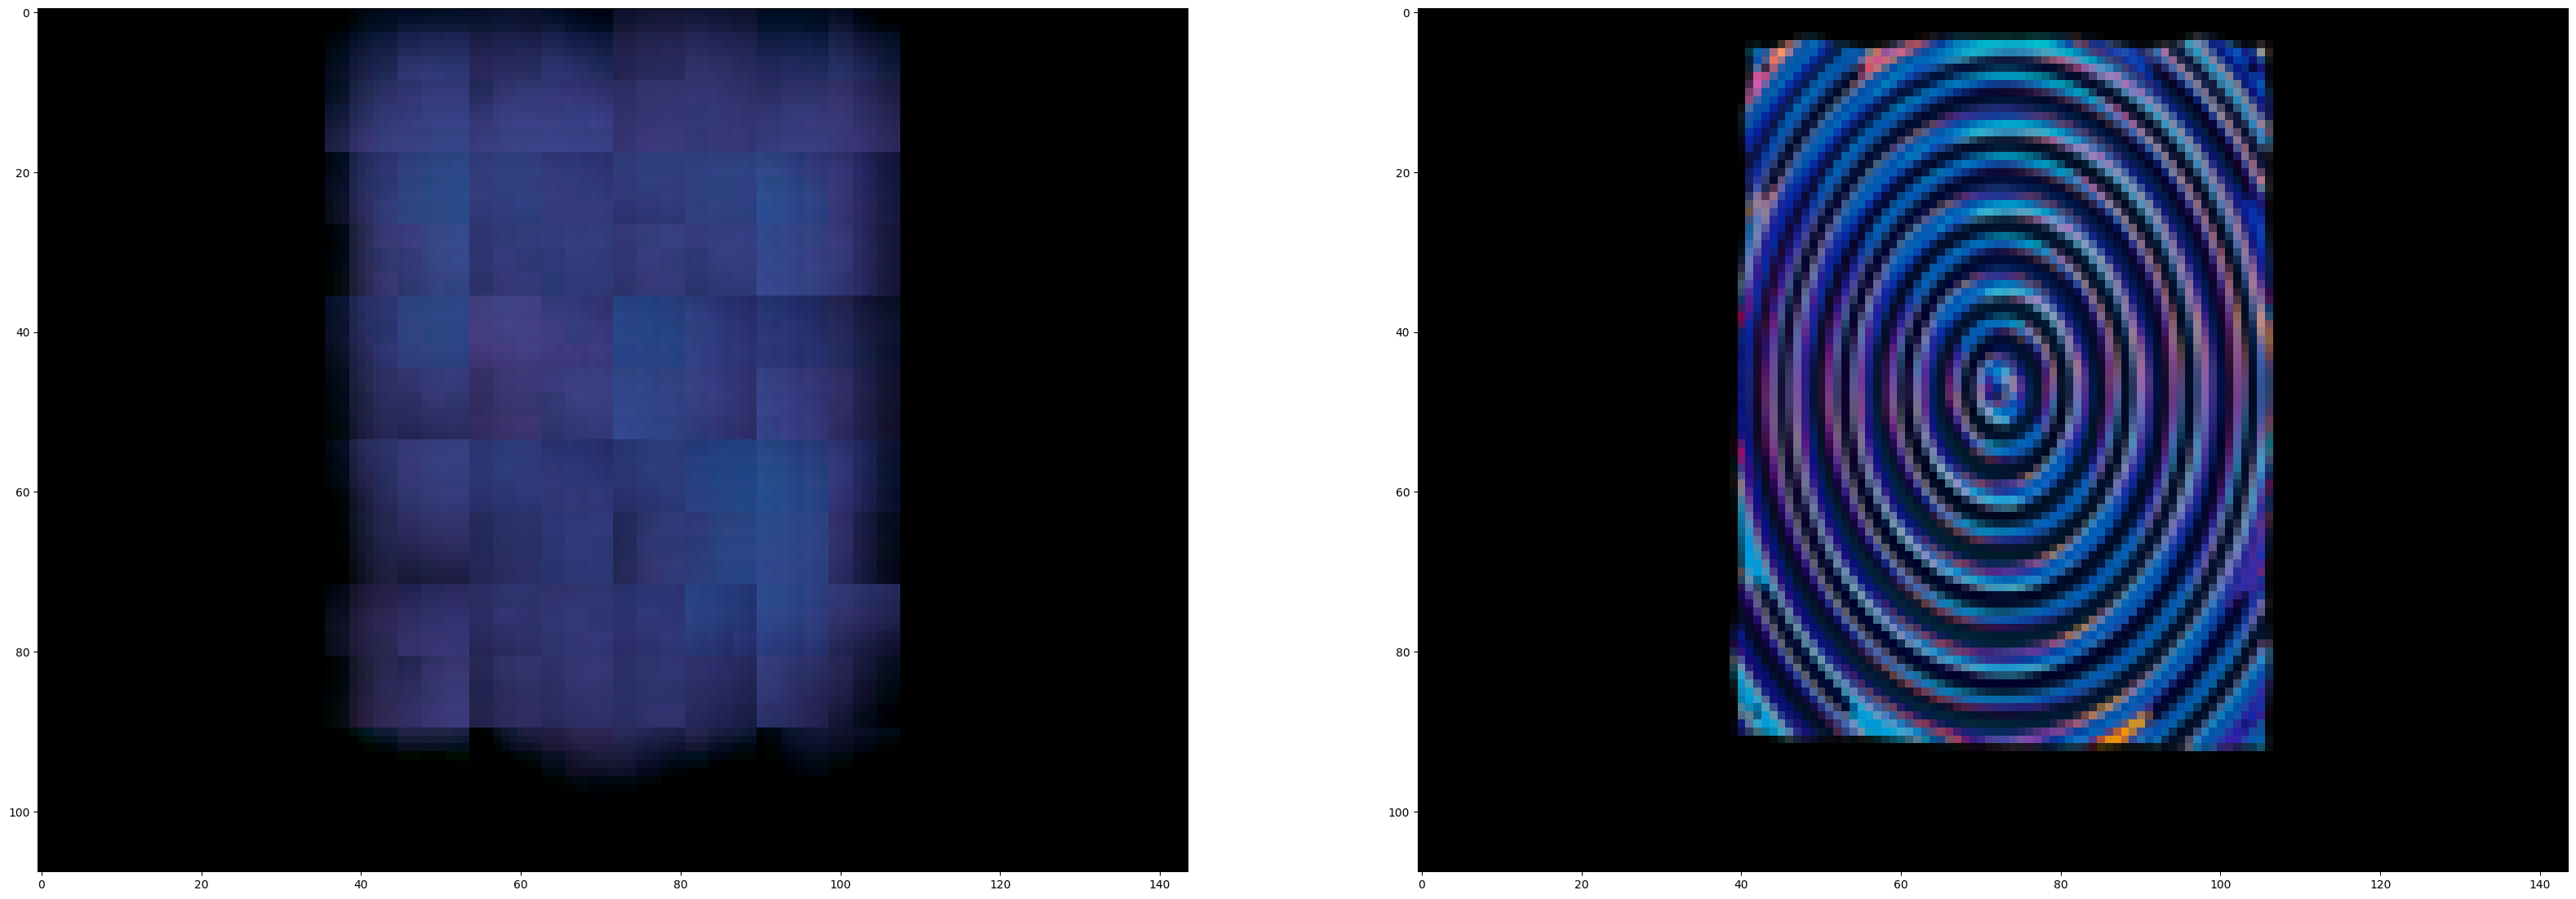

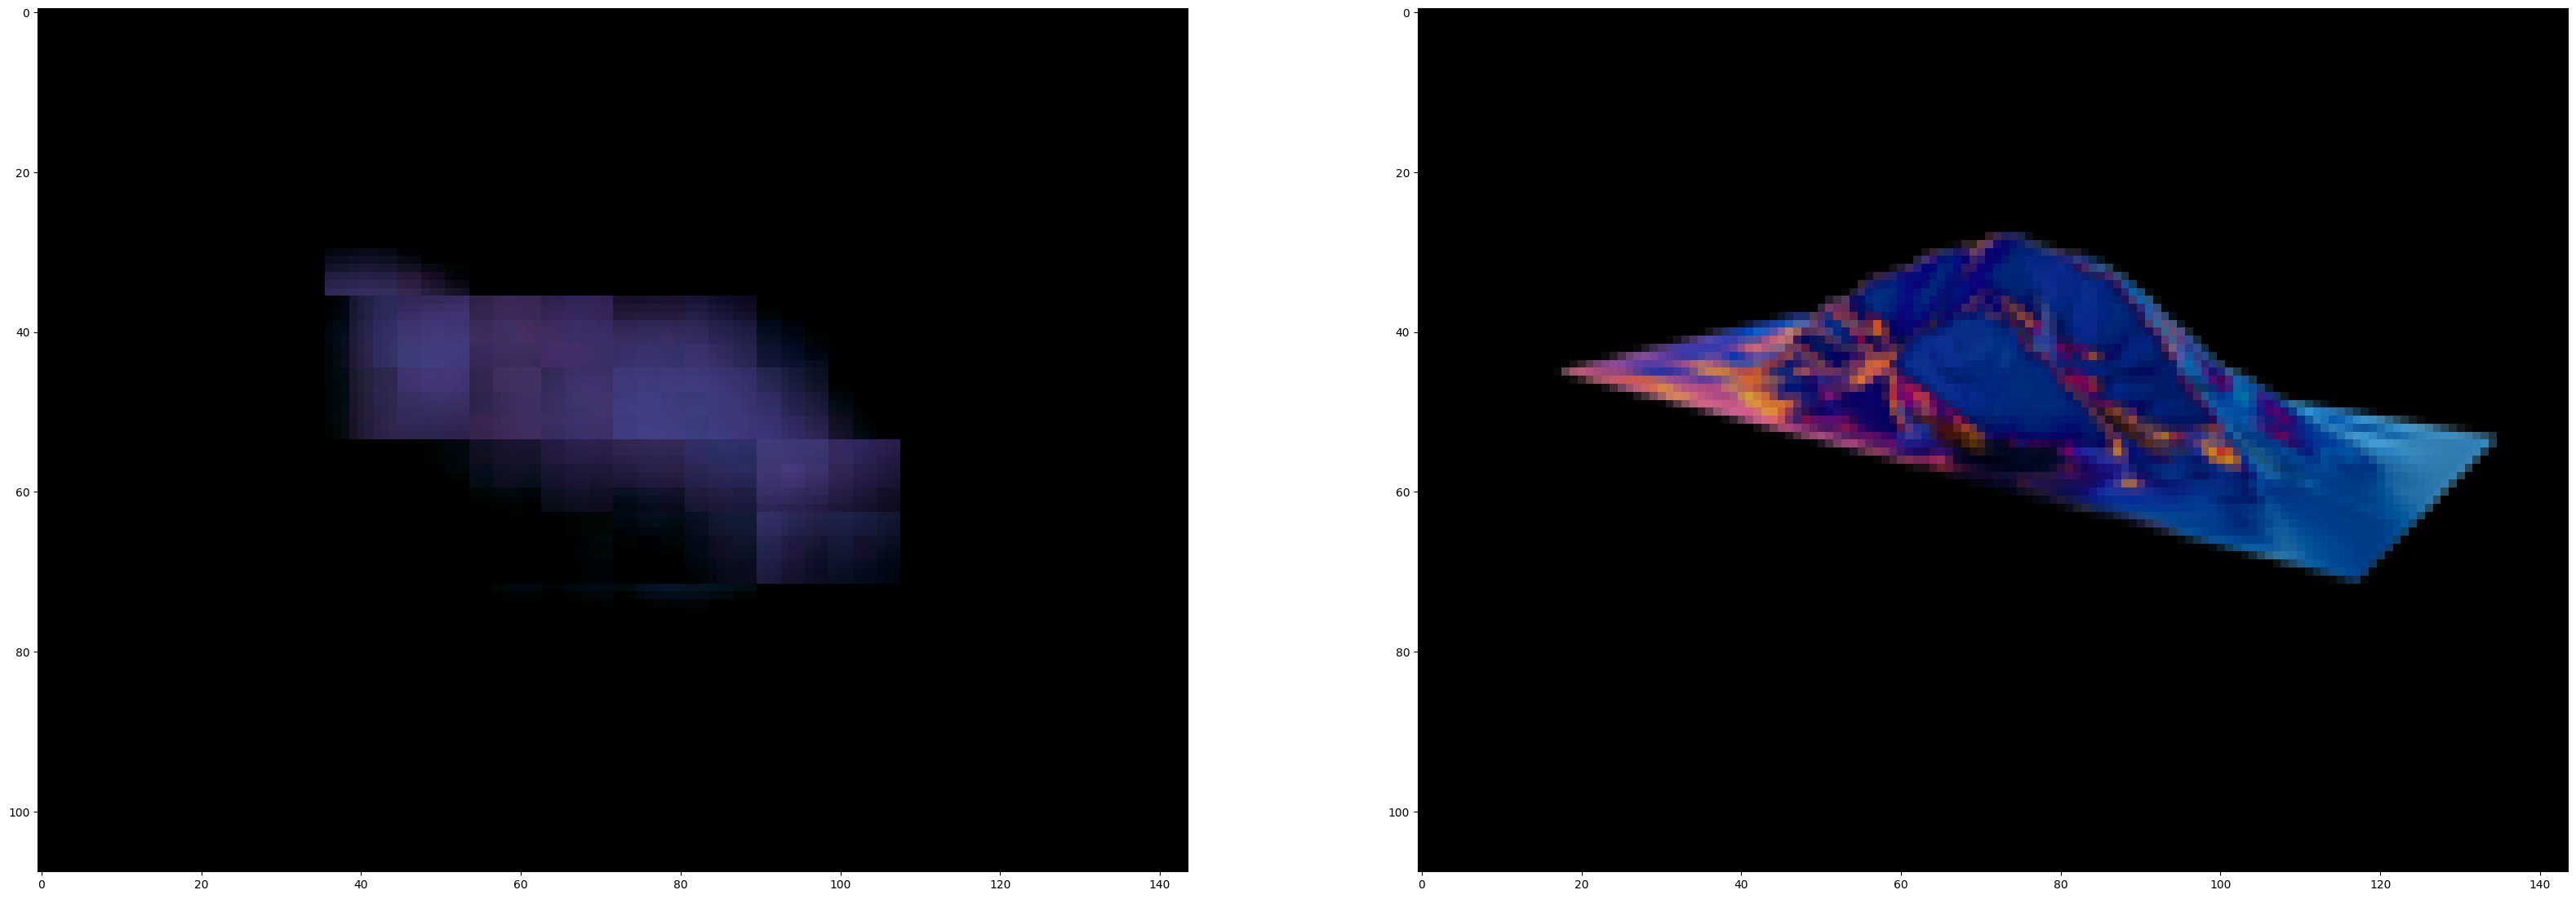

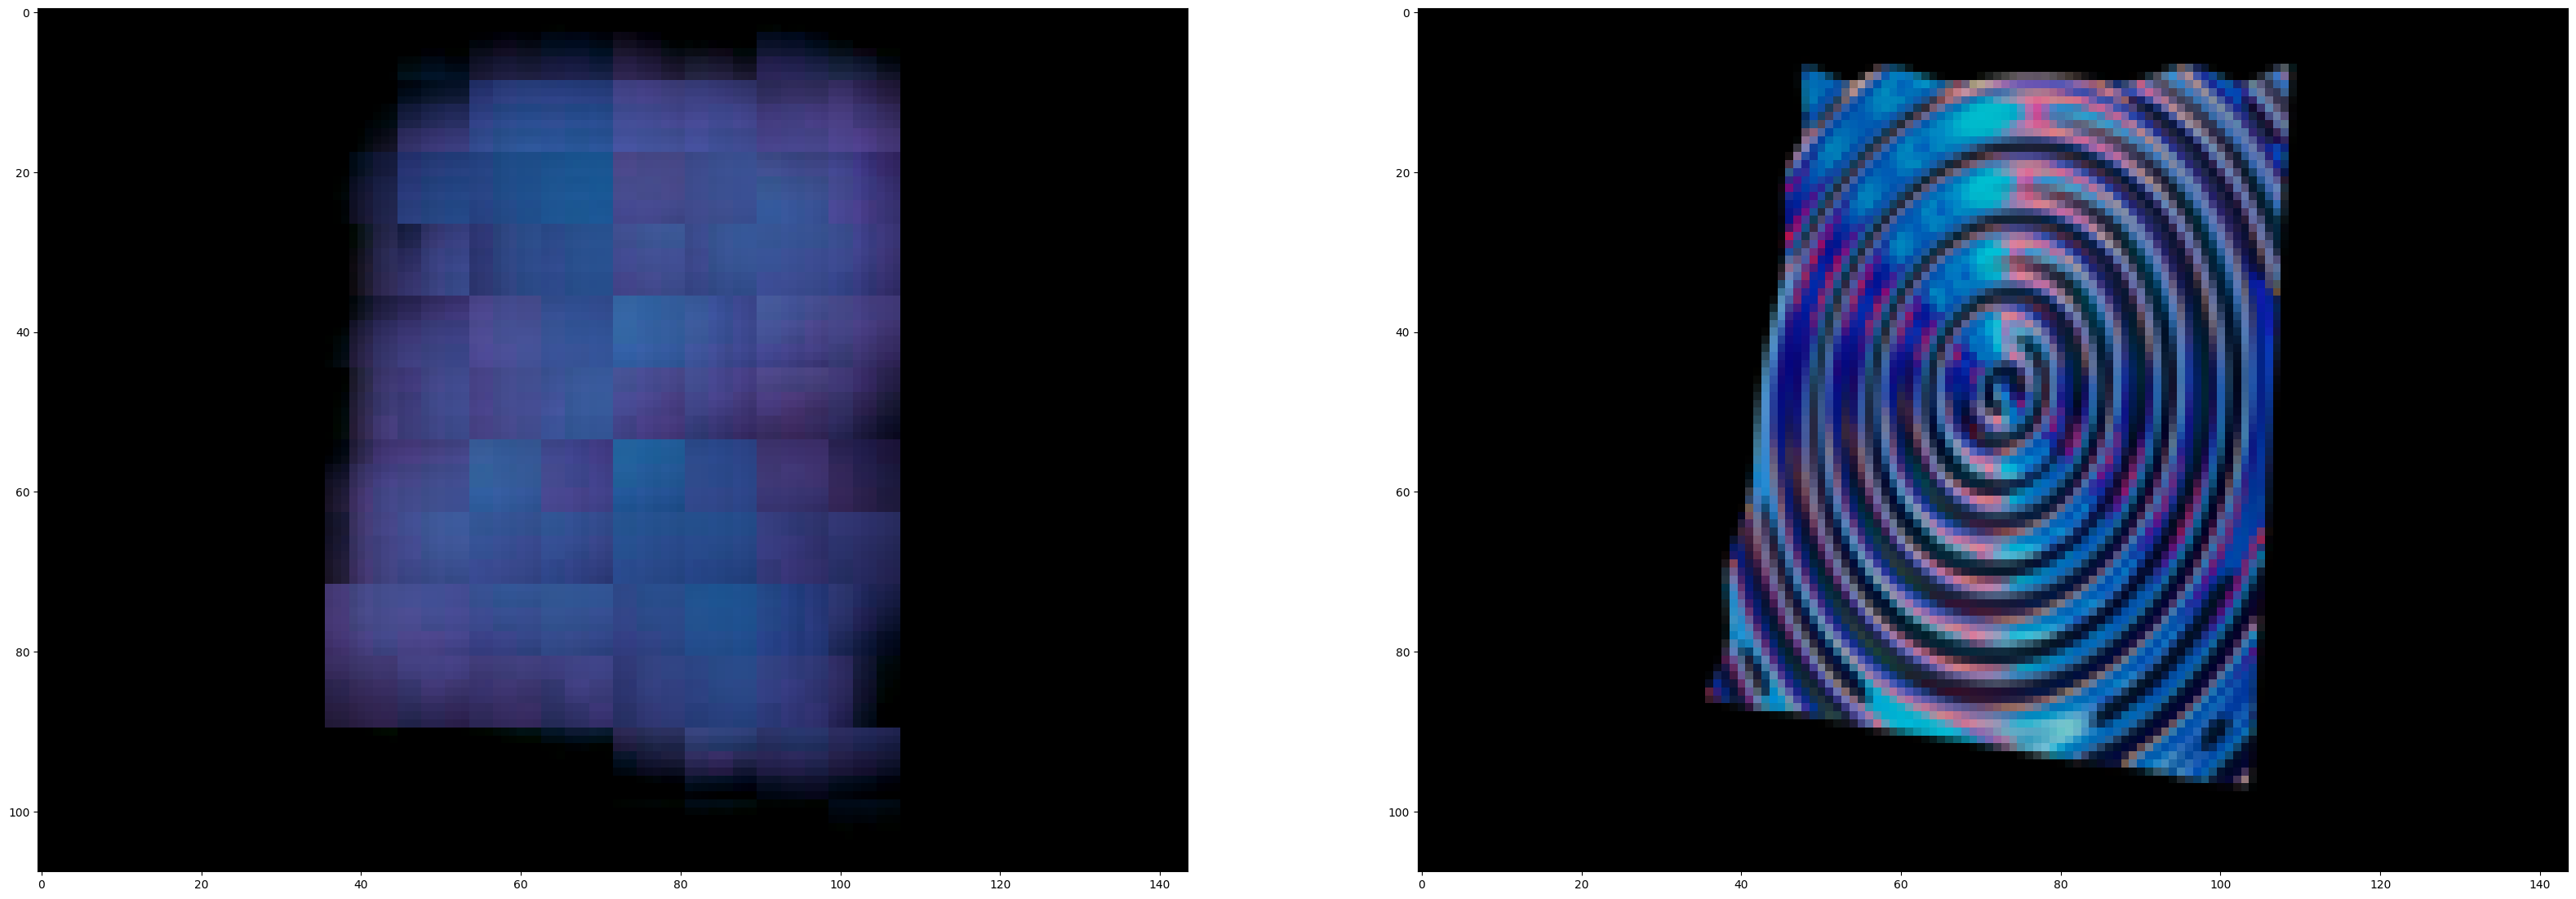

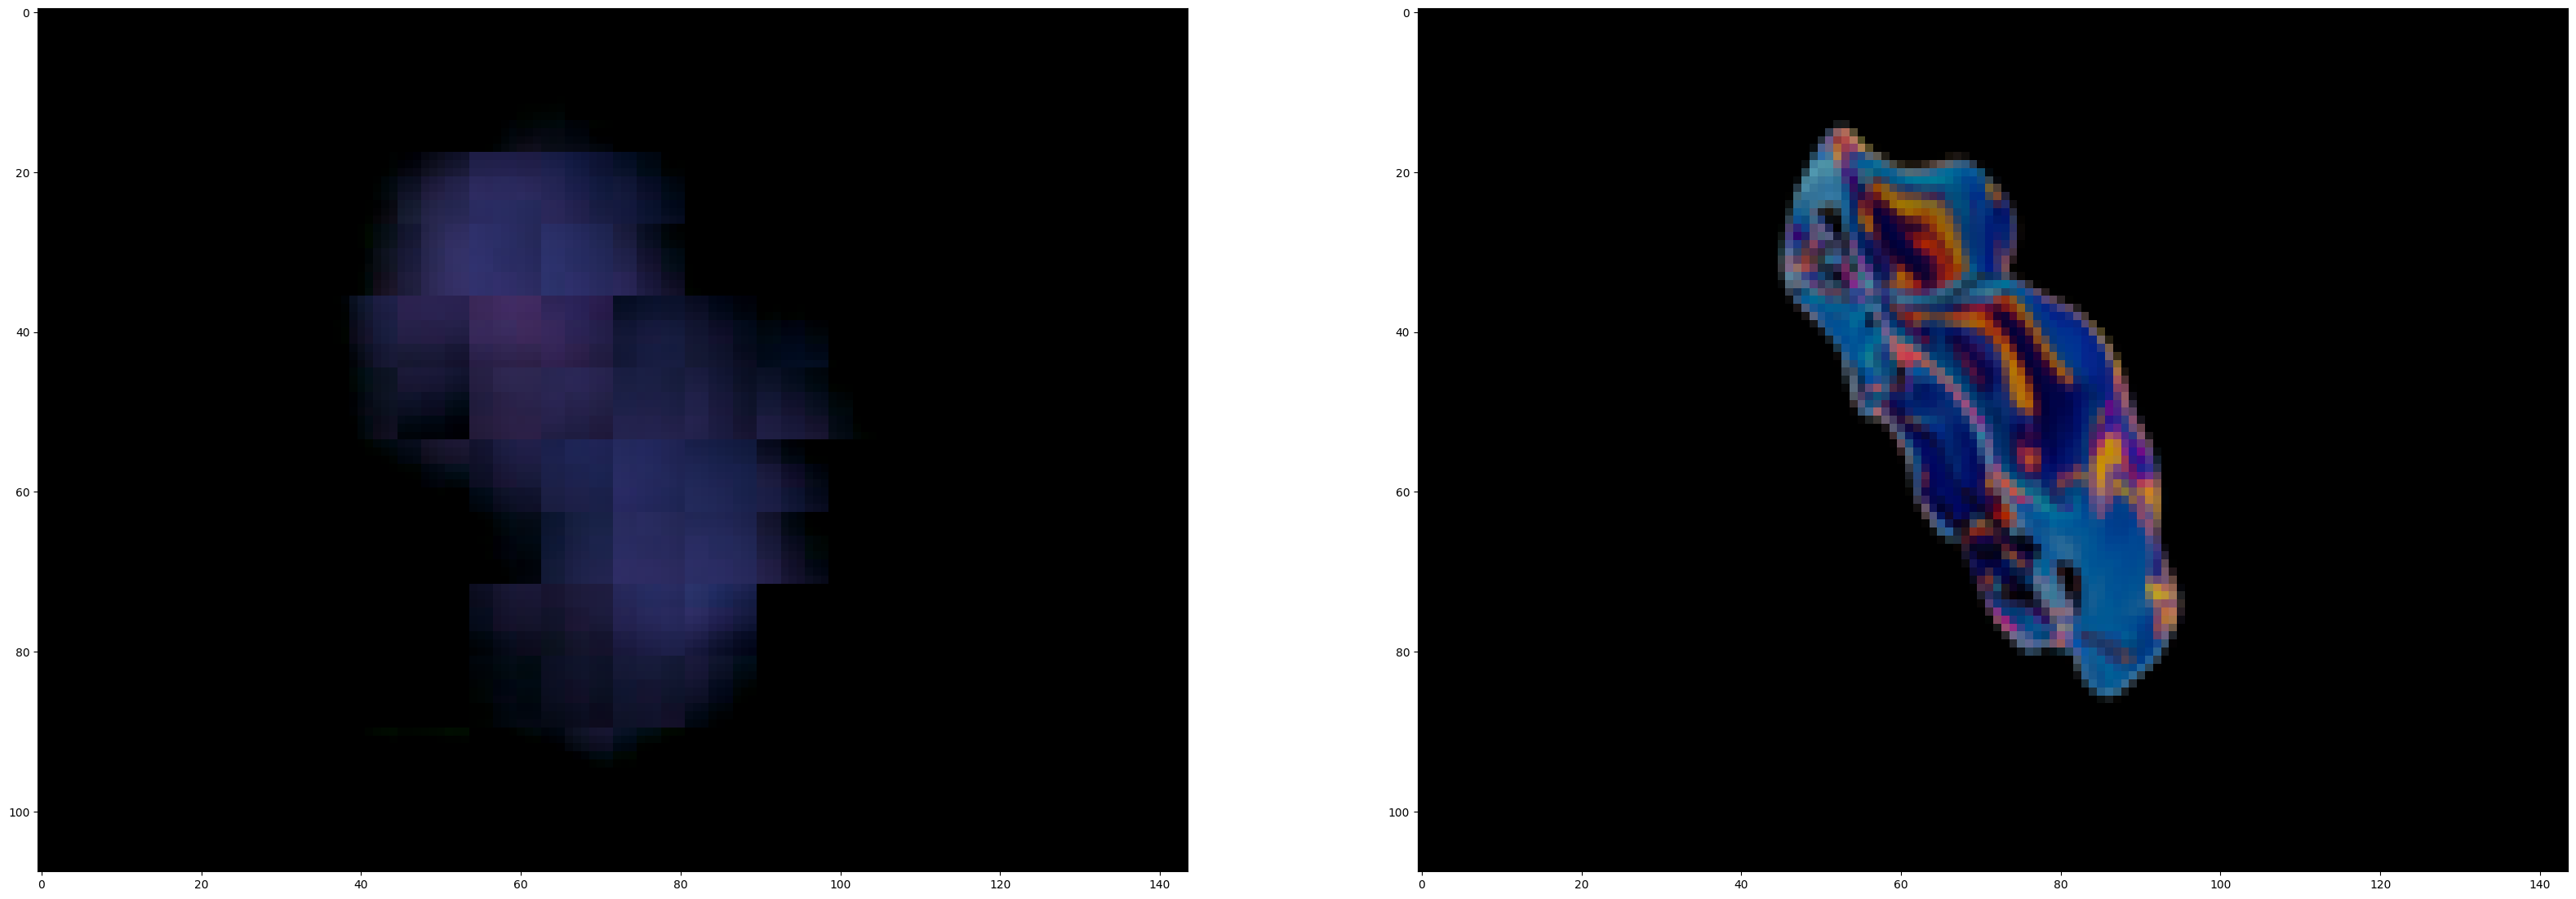

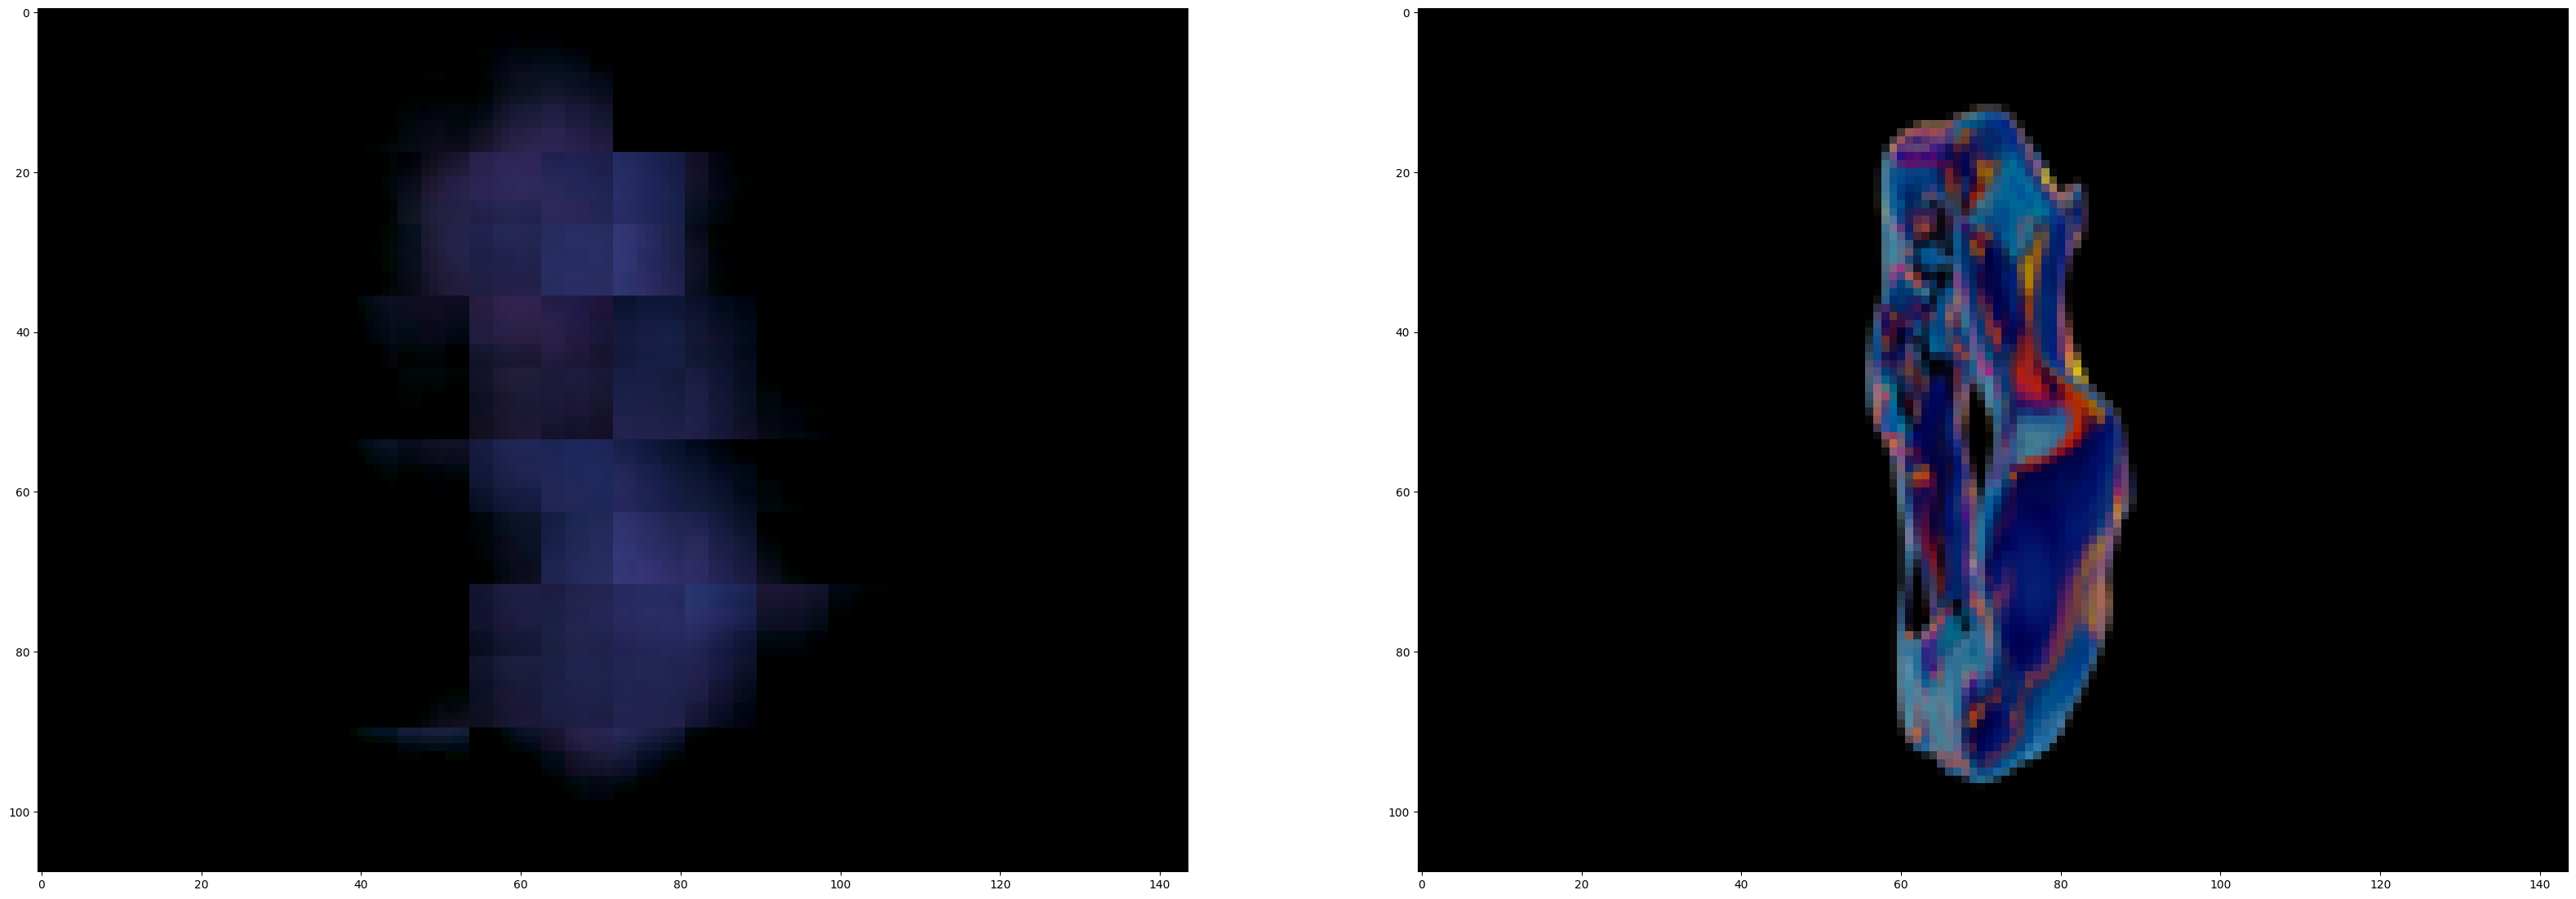

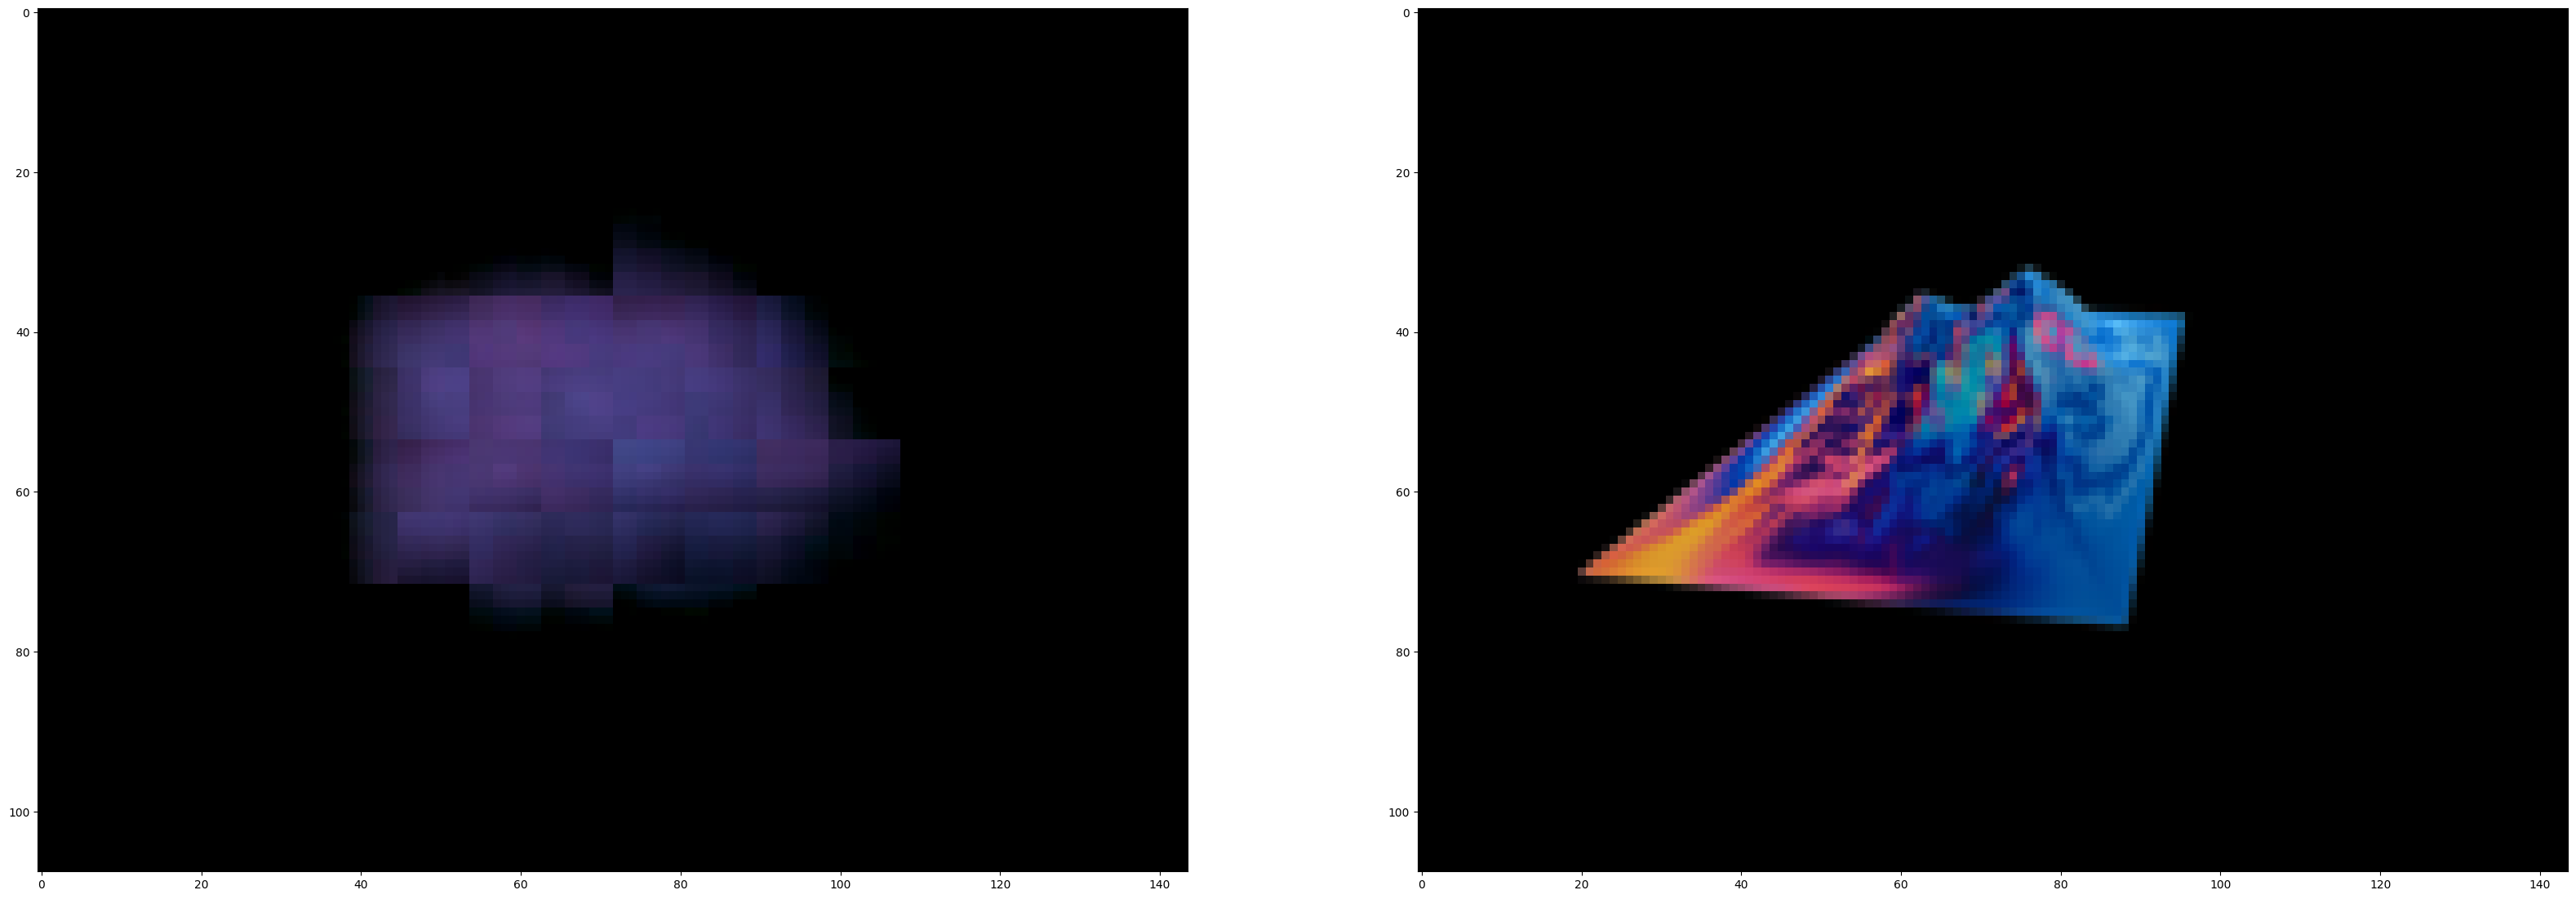

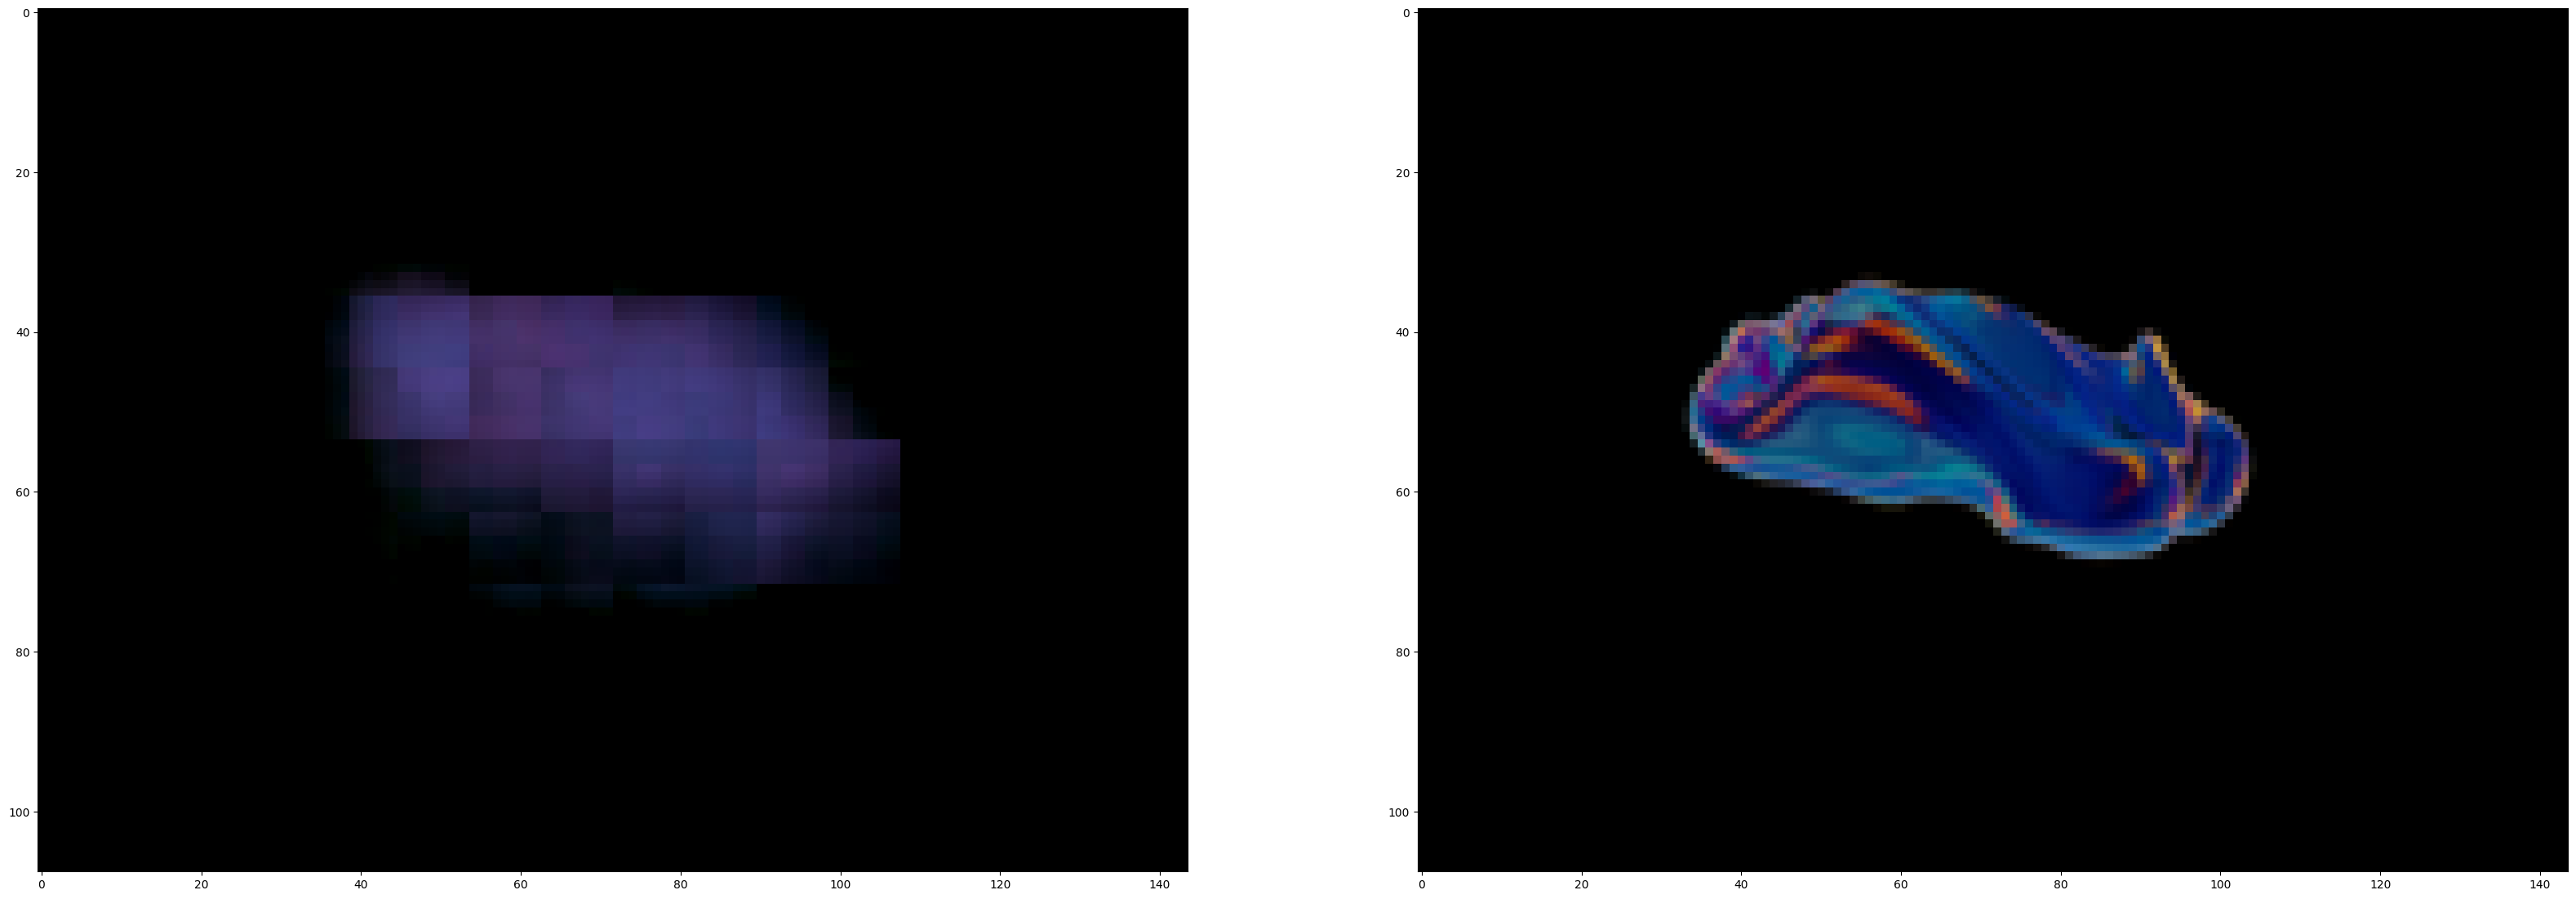

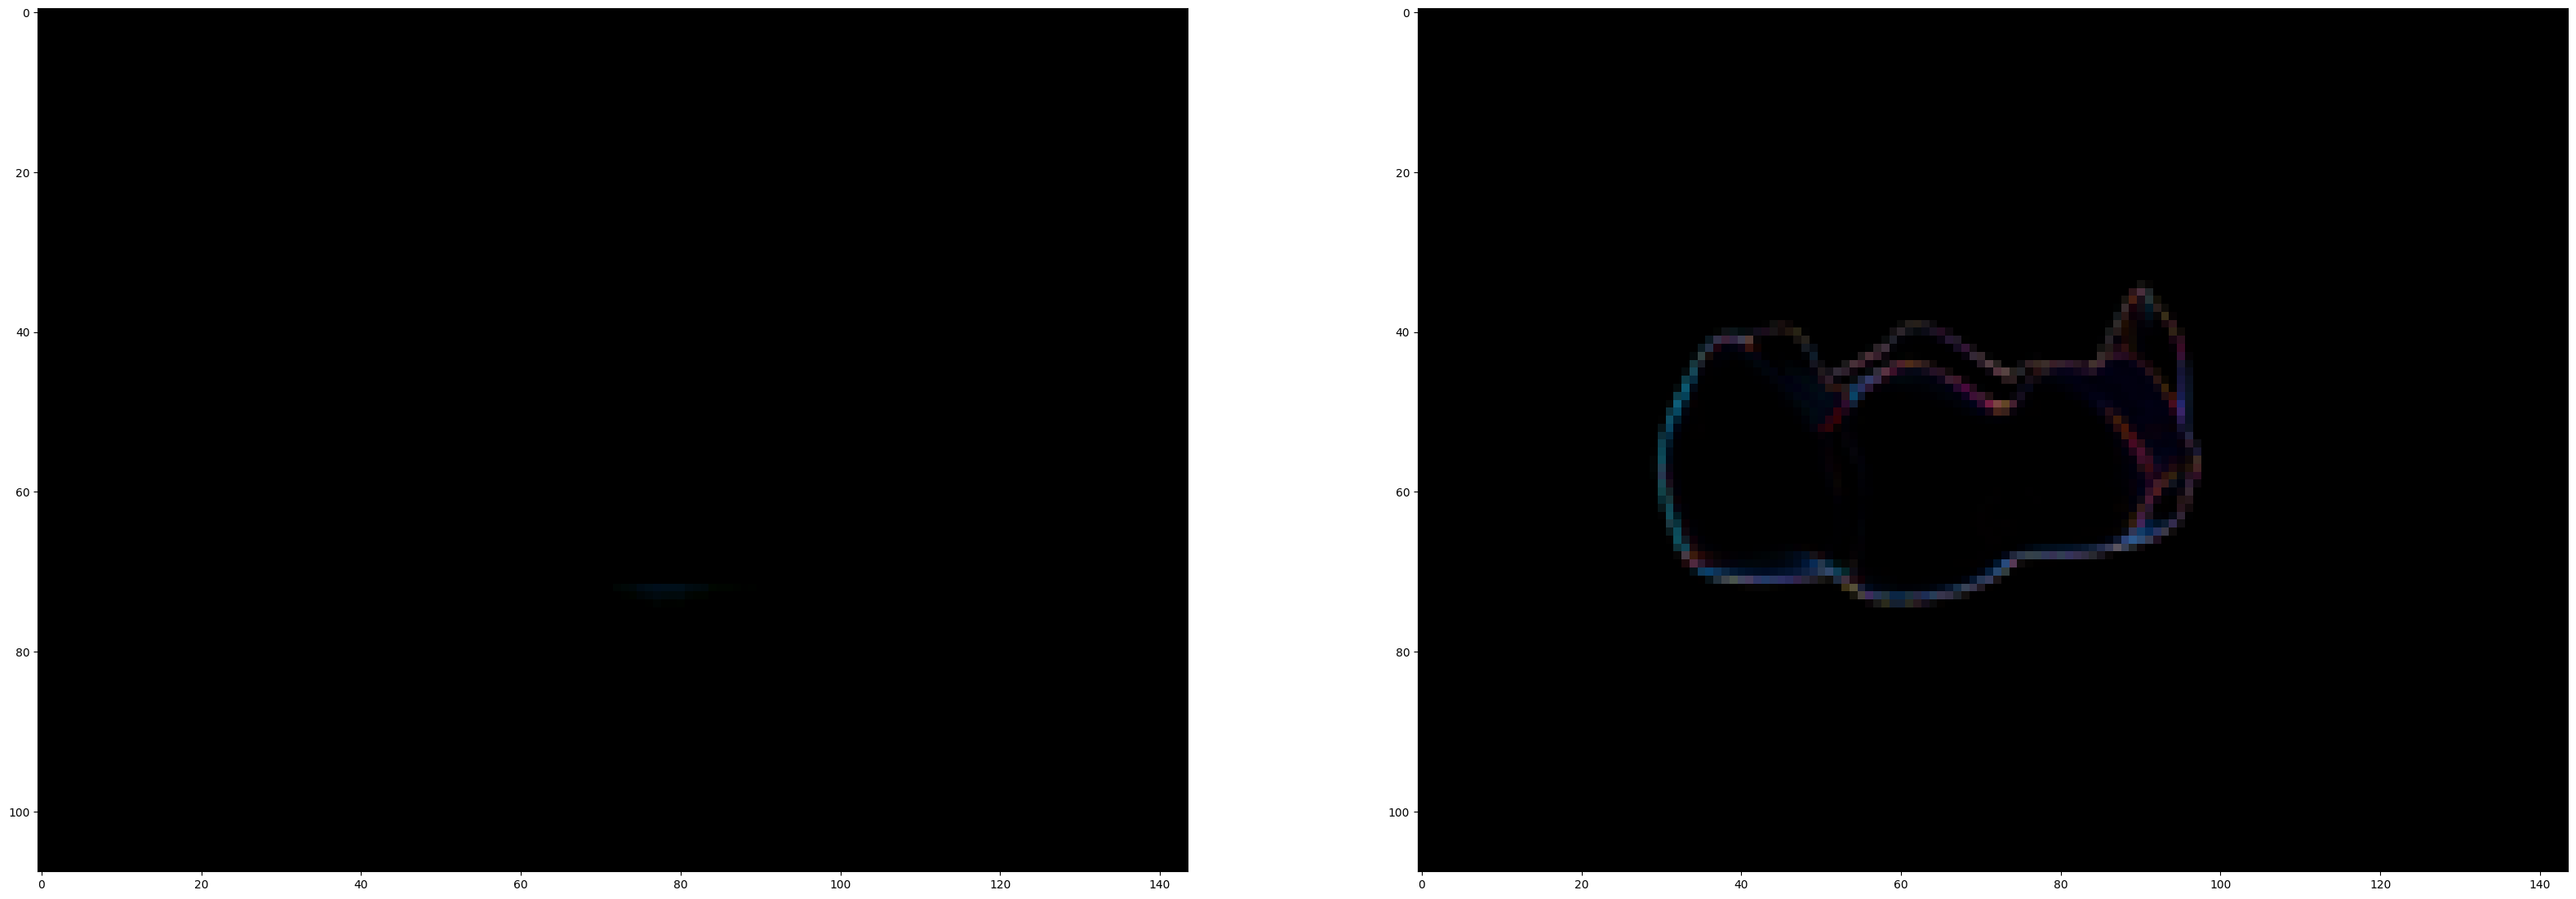

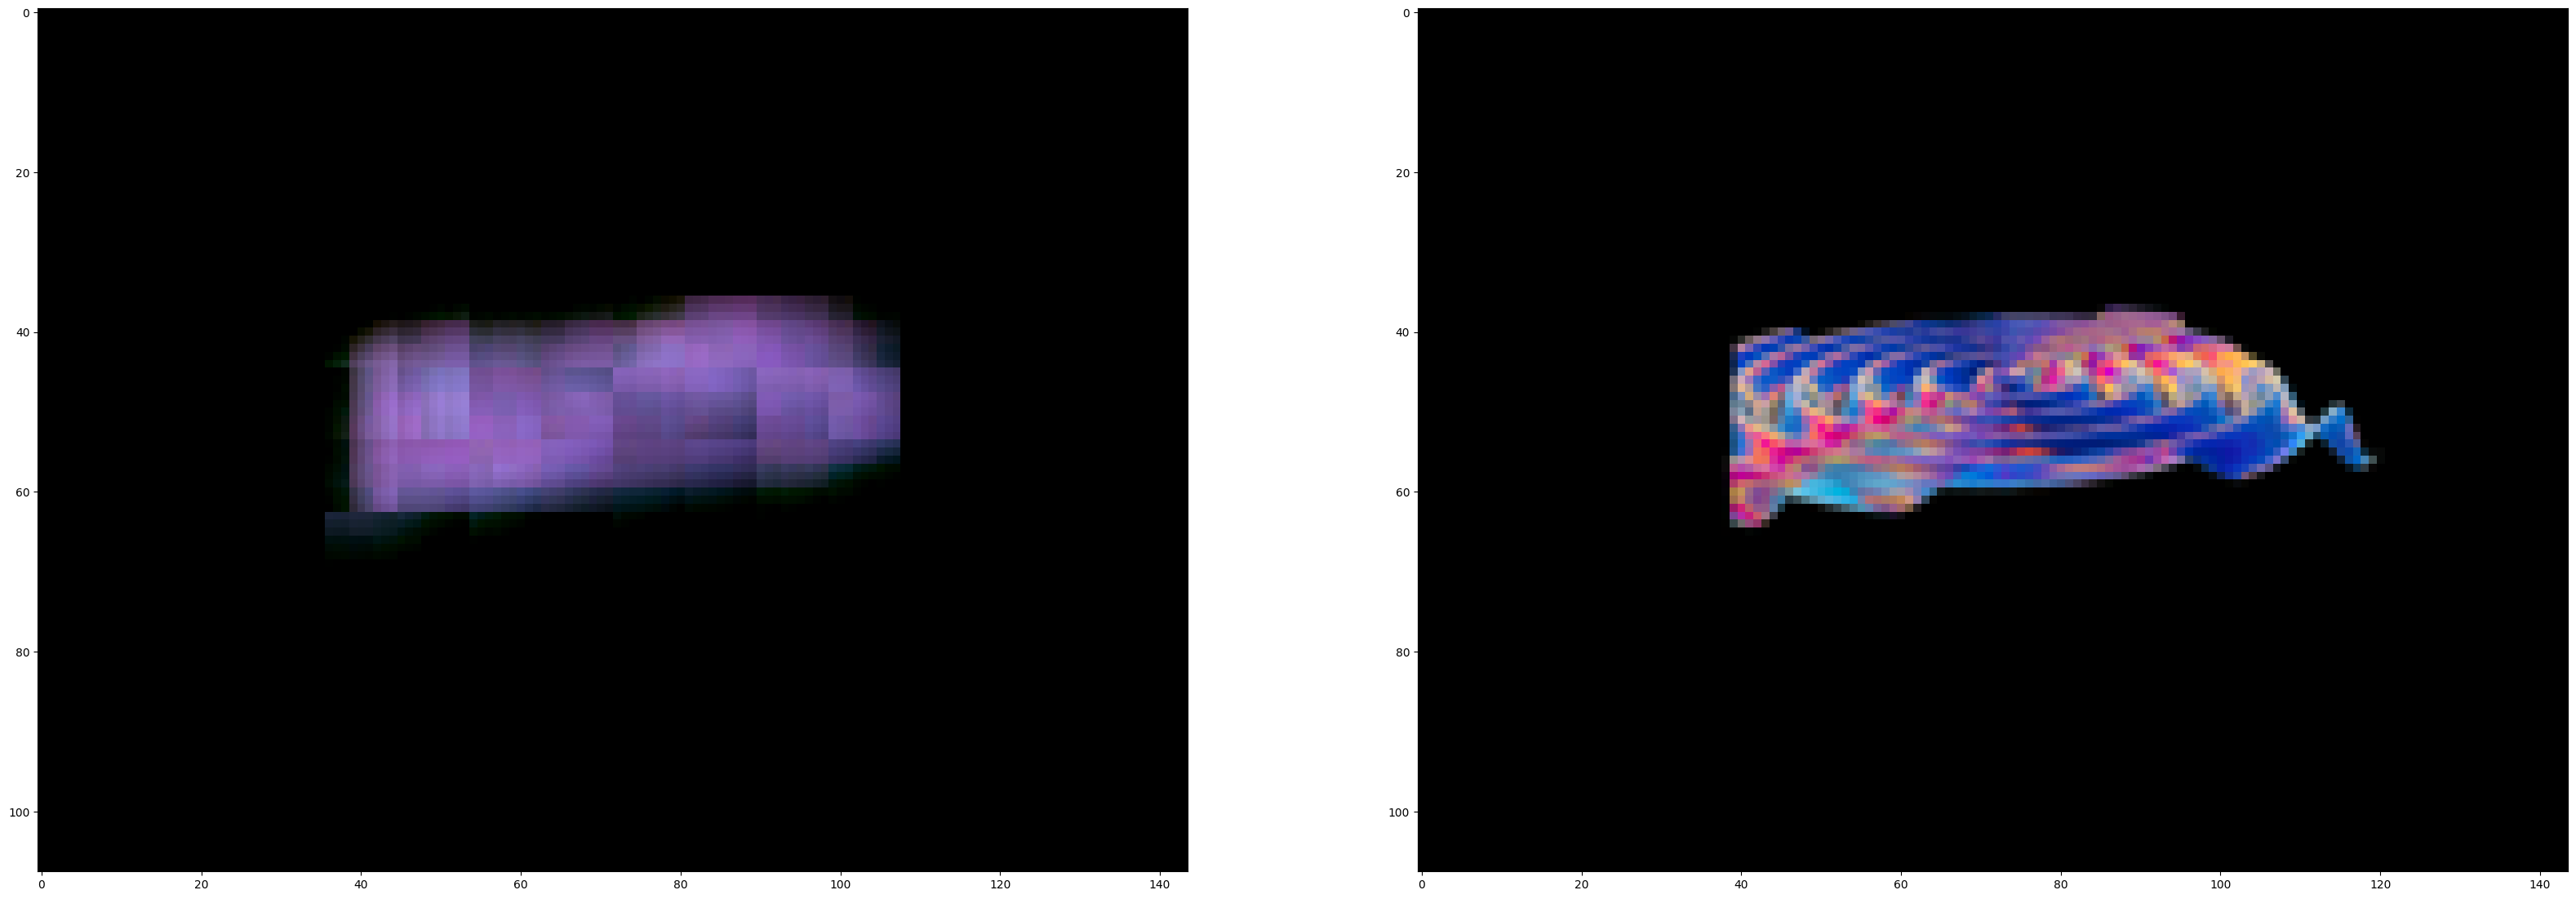

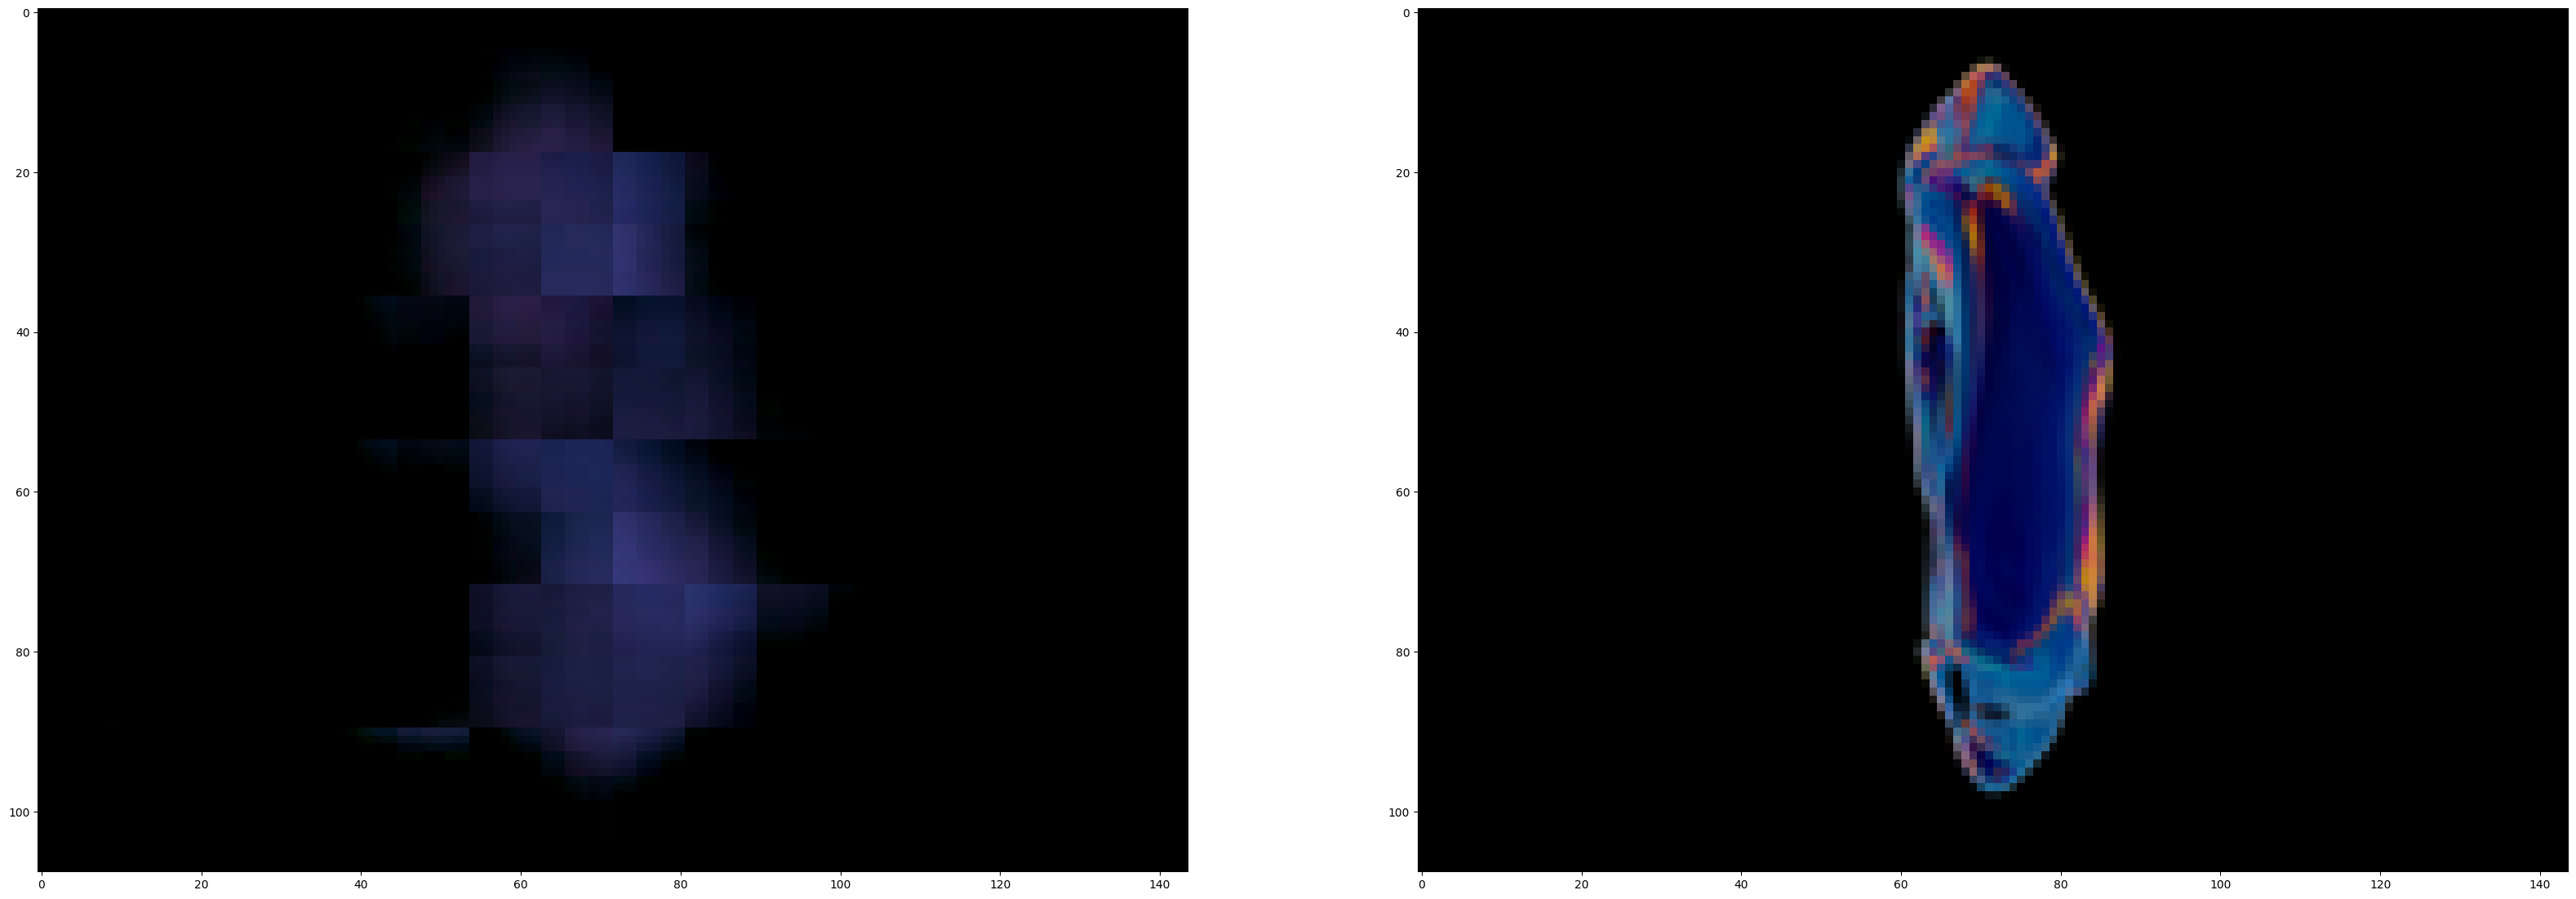

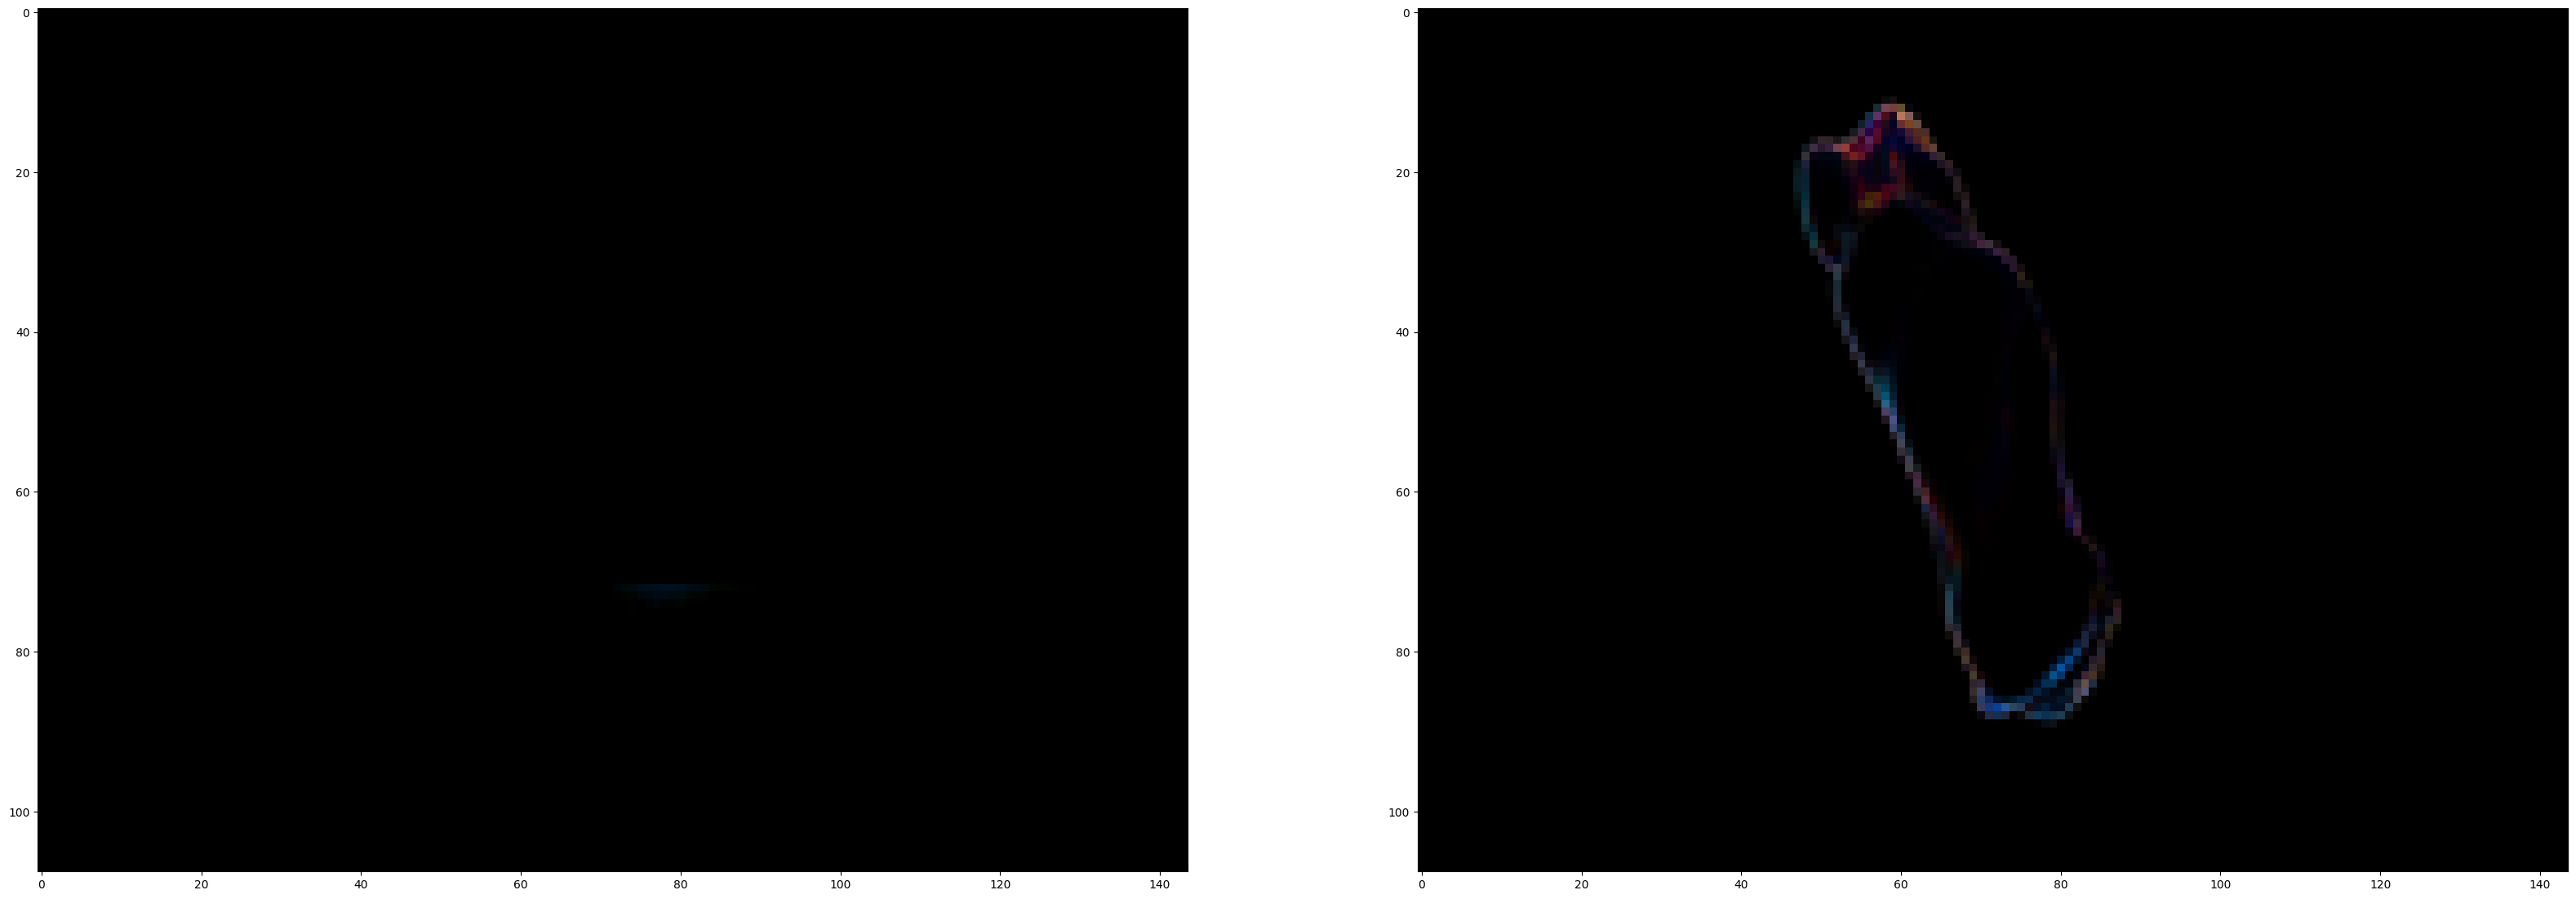

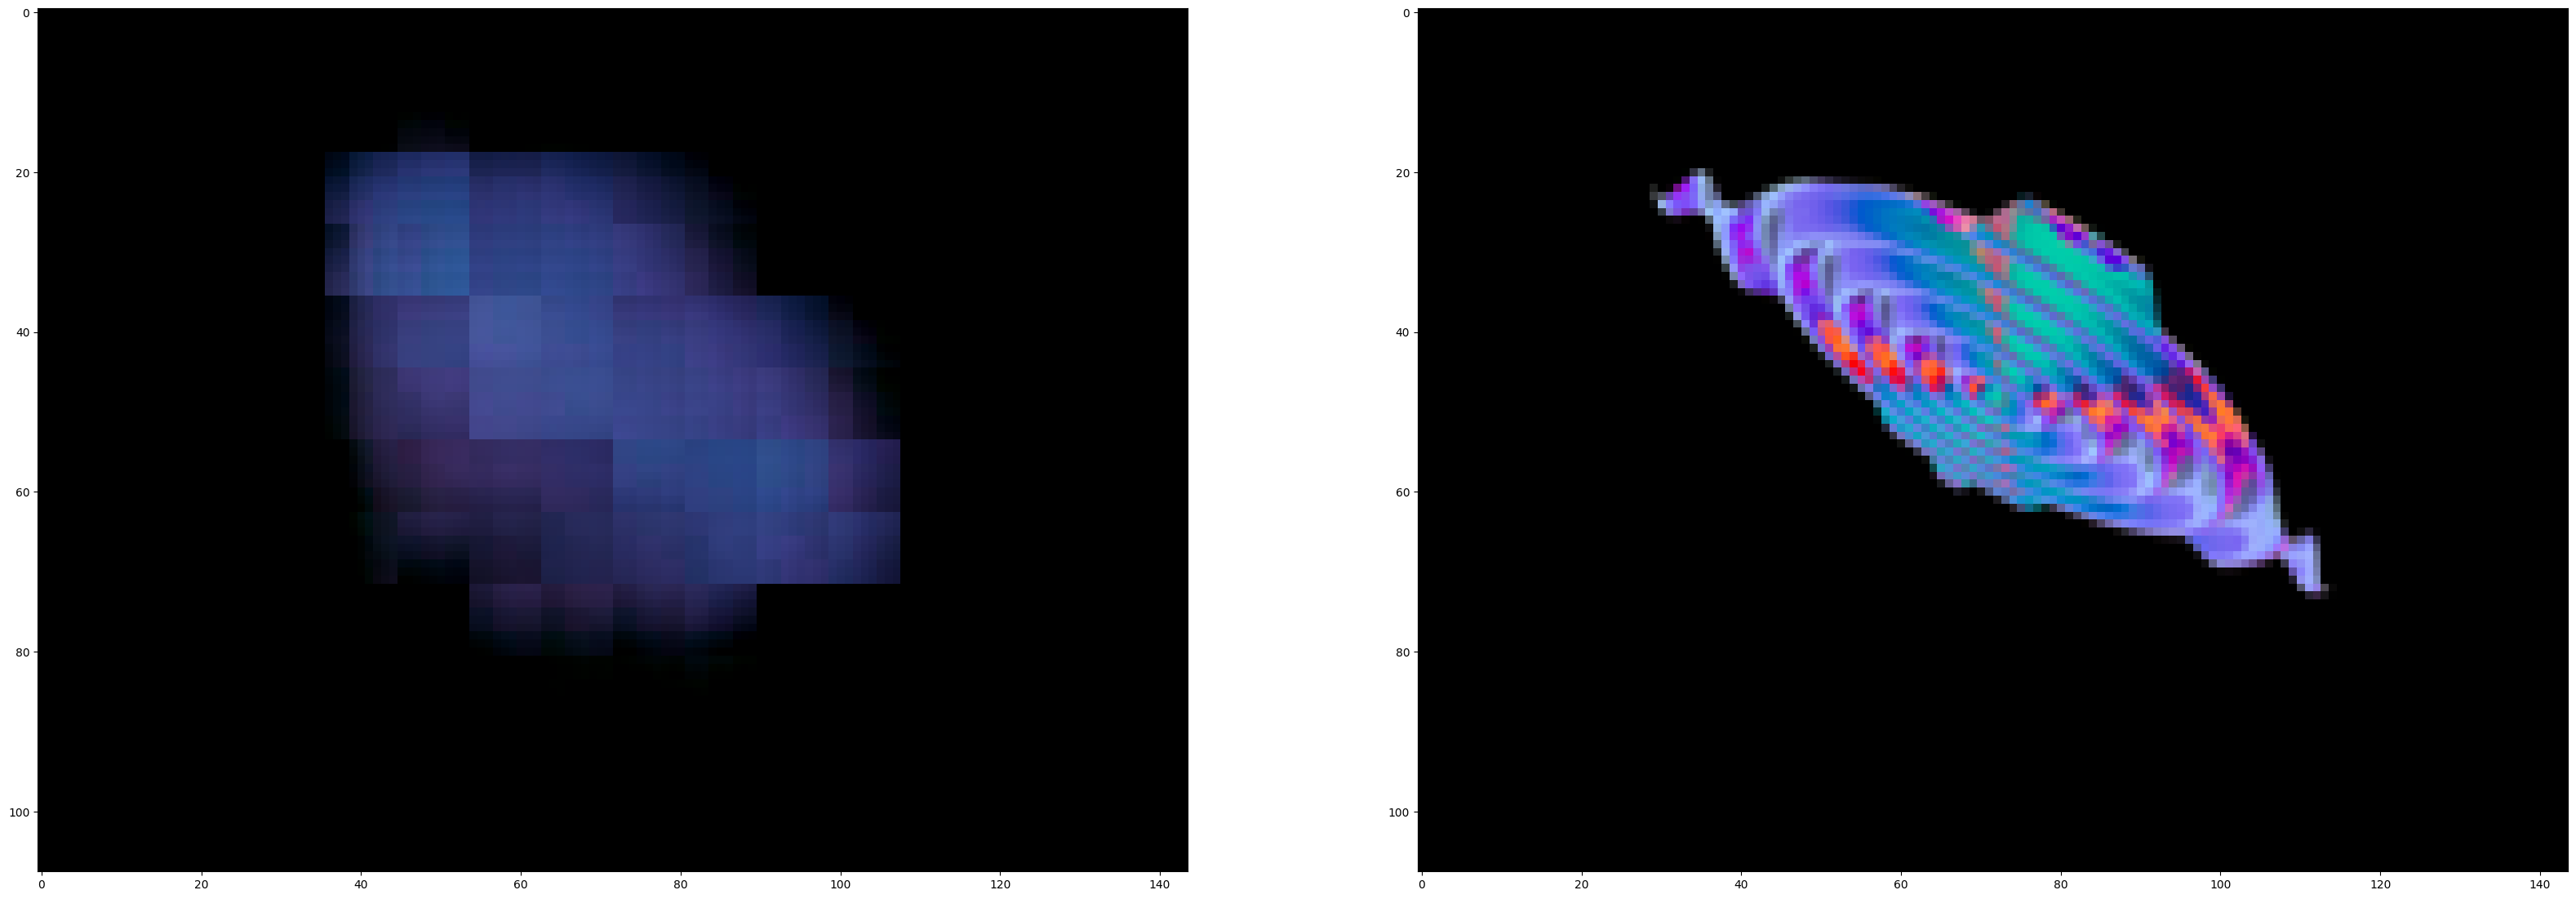

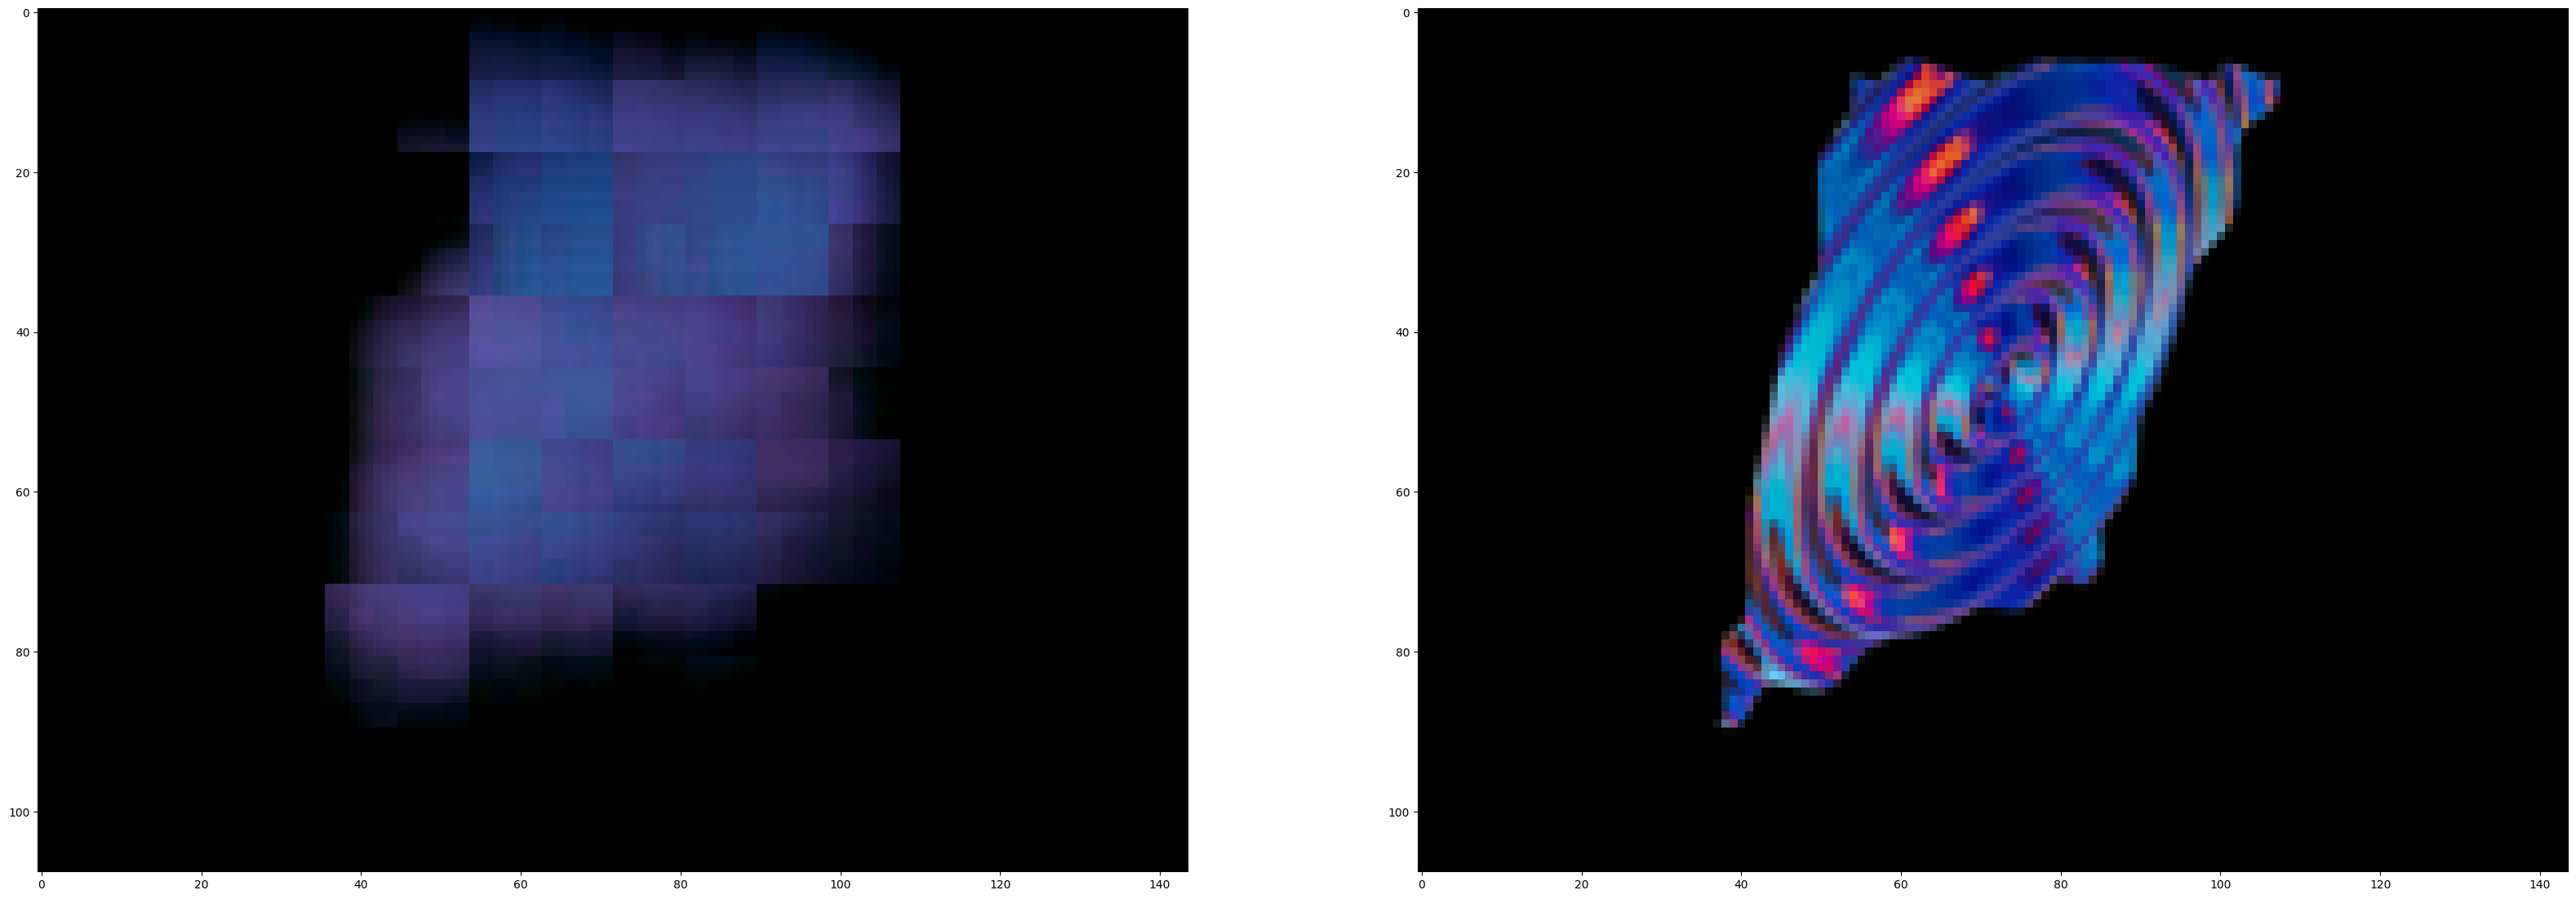

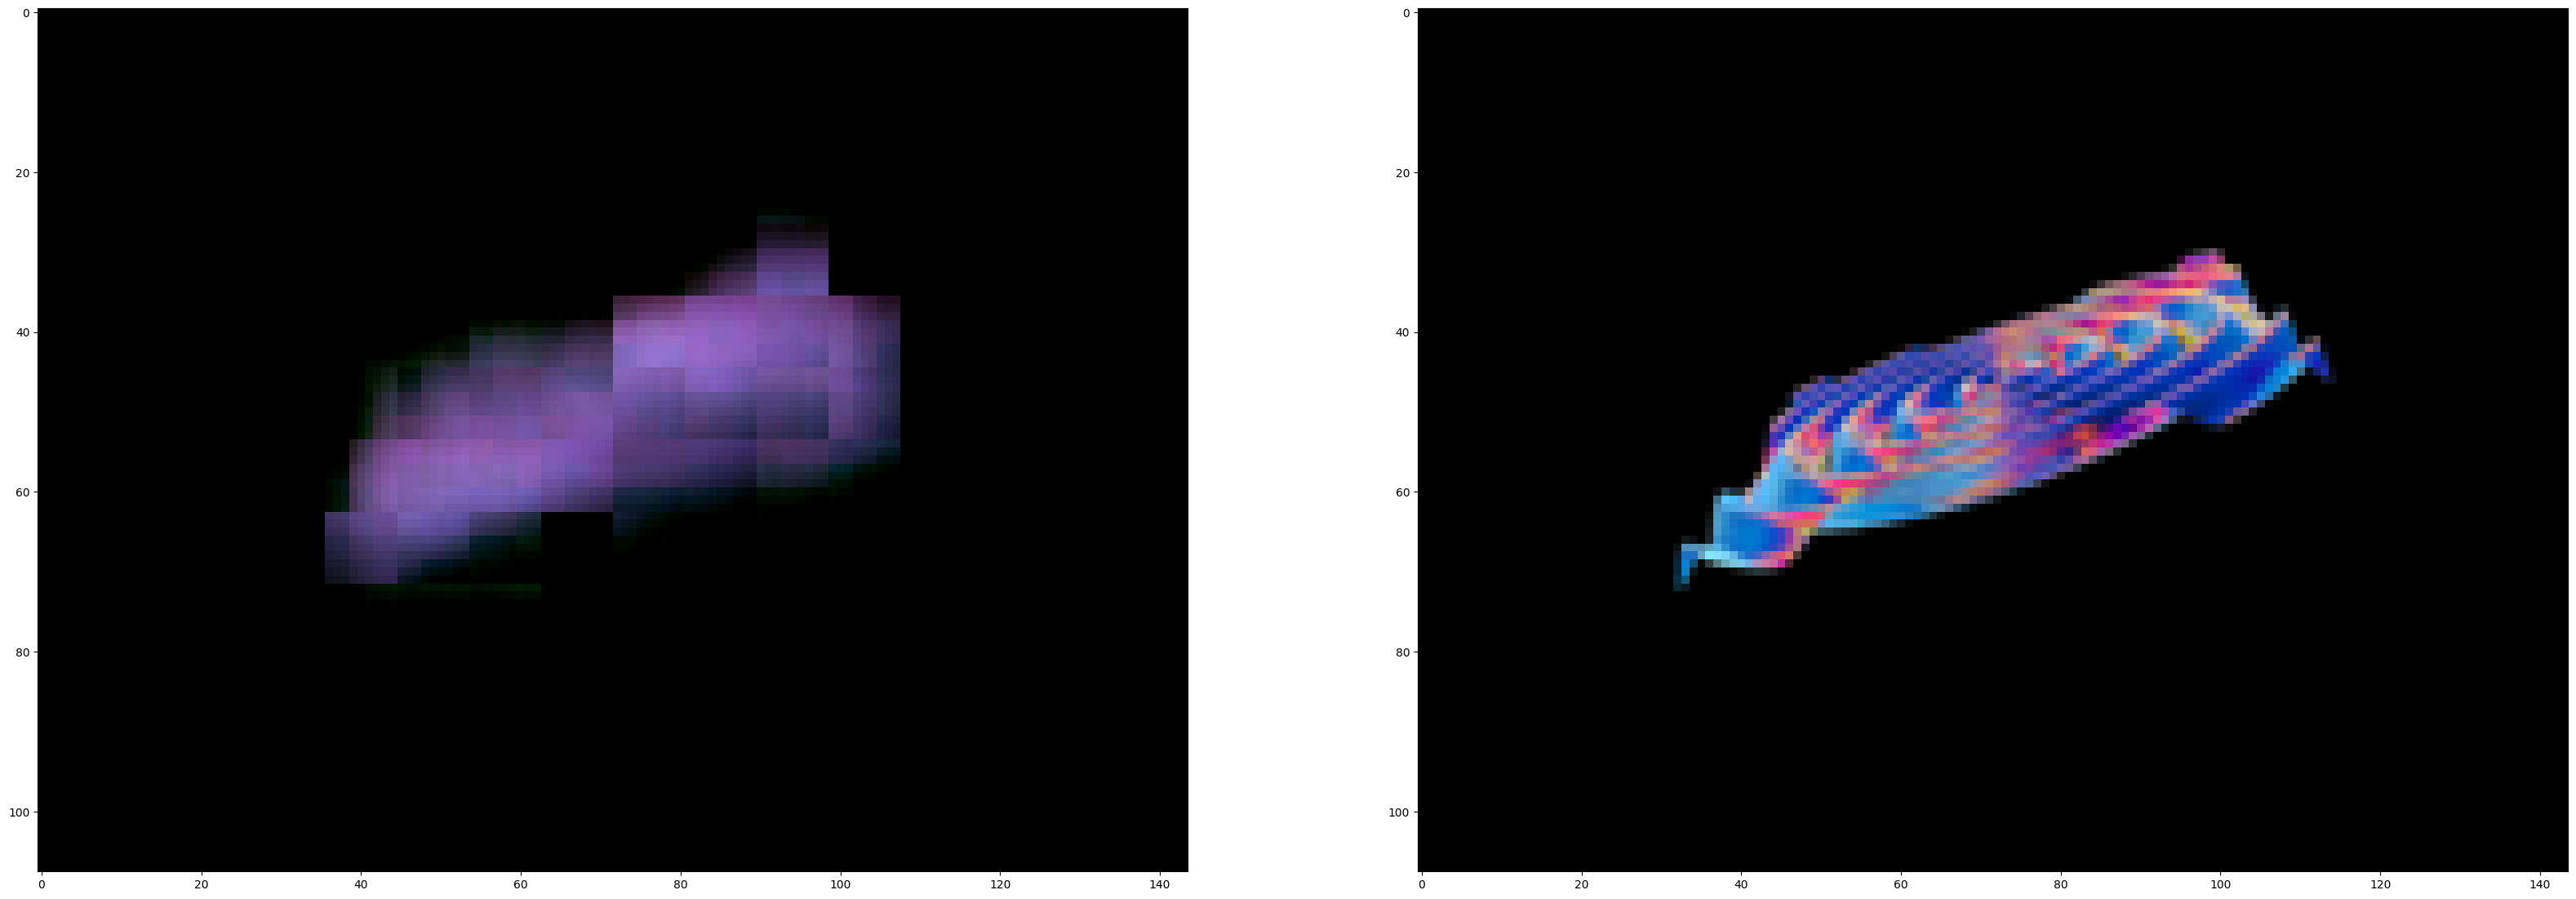

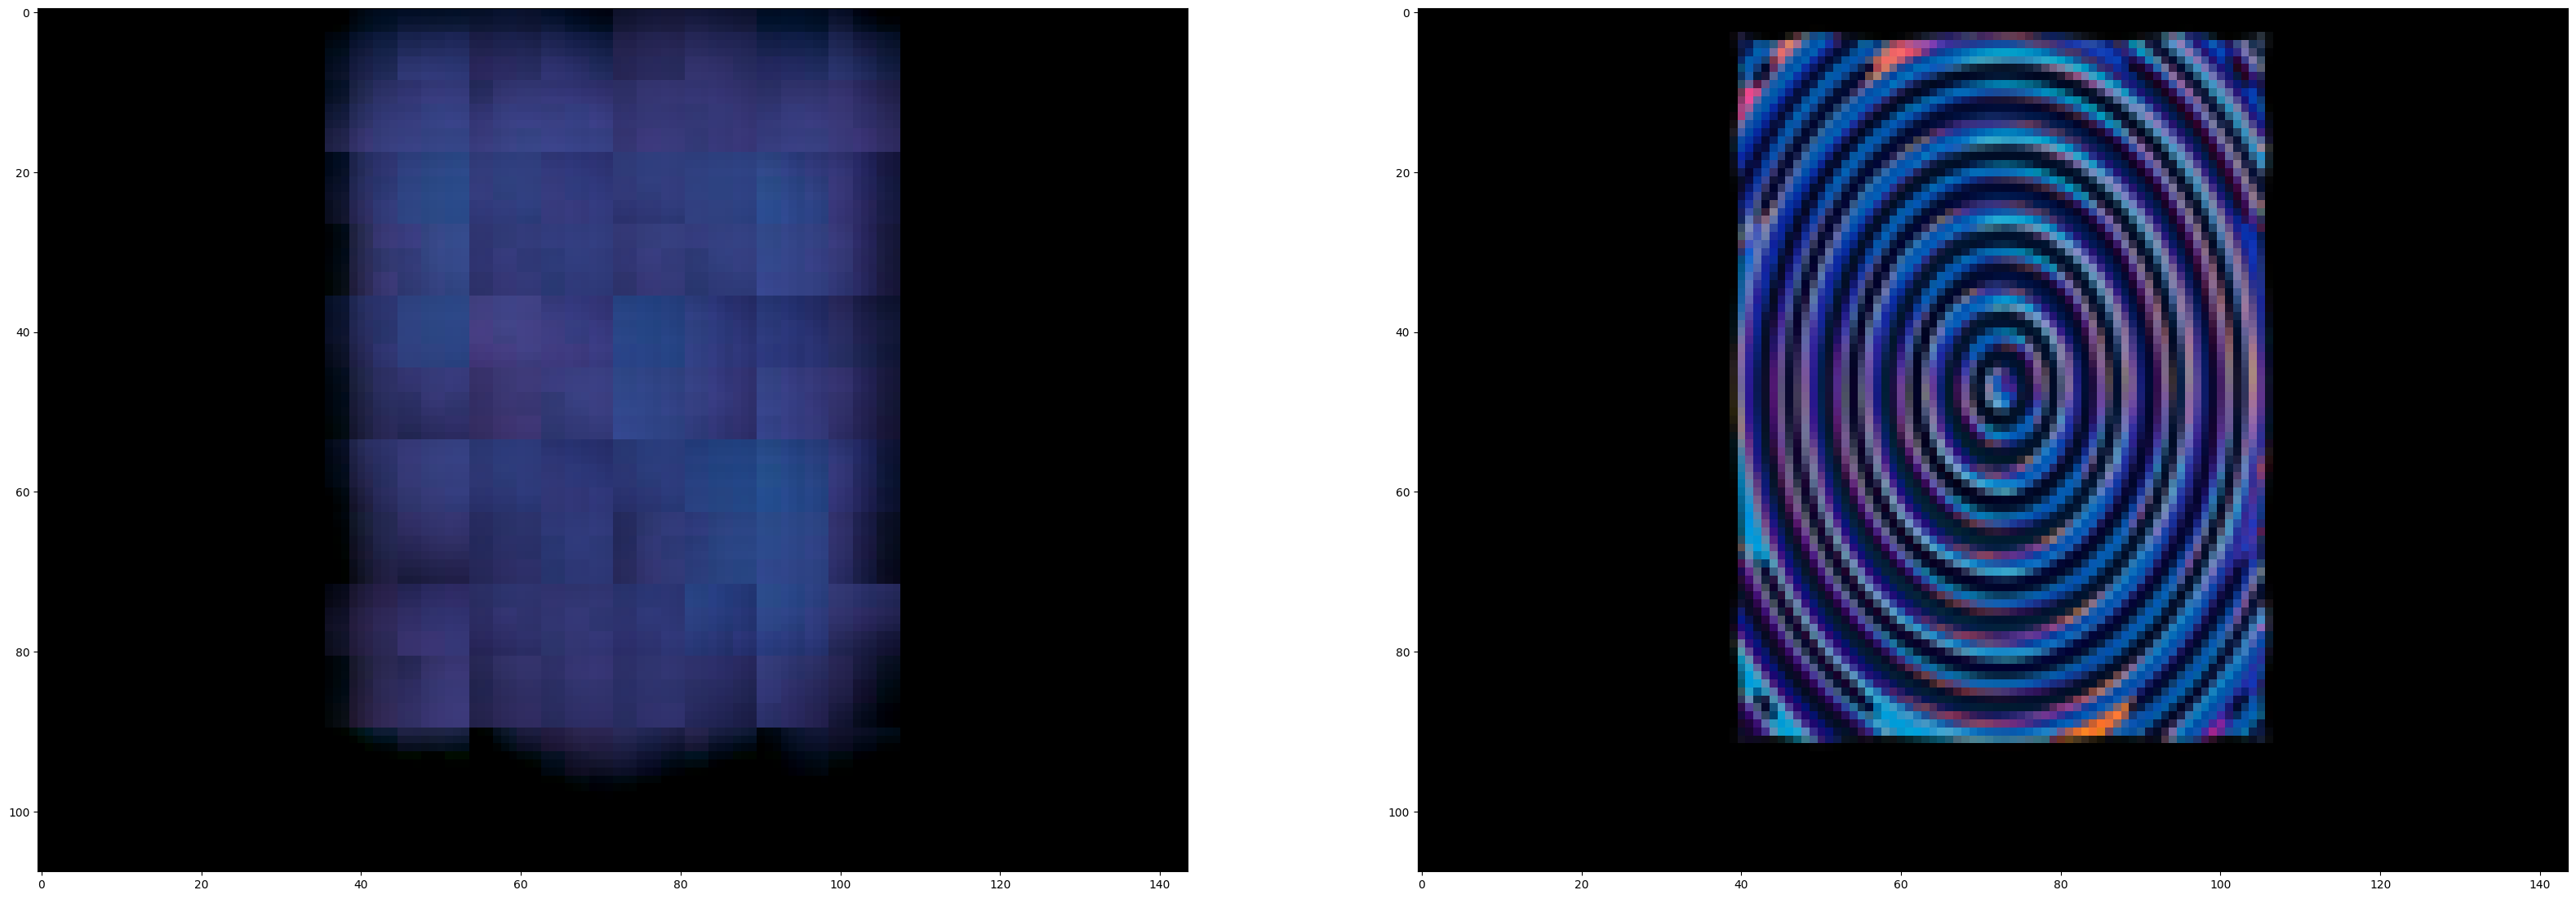

In [258]:
prediction = autoencoder.predict(X_train, verbose=0, batch_size=32)# you can now display an image to see it is reconstructed well

for i in range(70):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    ax1.imshow((prediction[i] * 255).astype(np.uint8))
    ax2.imshow(X_train[i].reshape(108, 144, 3))
    plt.show()
    

# AUDIO FEATURE EXTRACTION

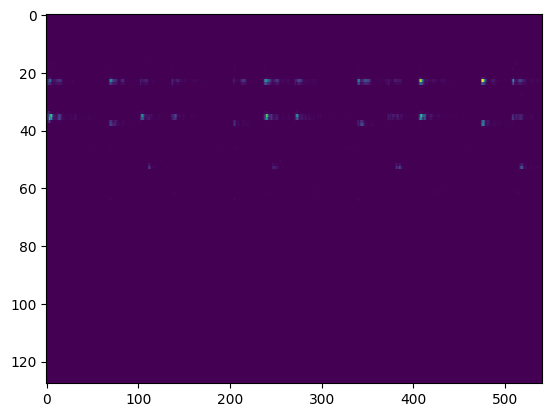

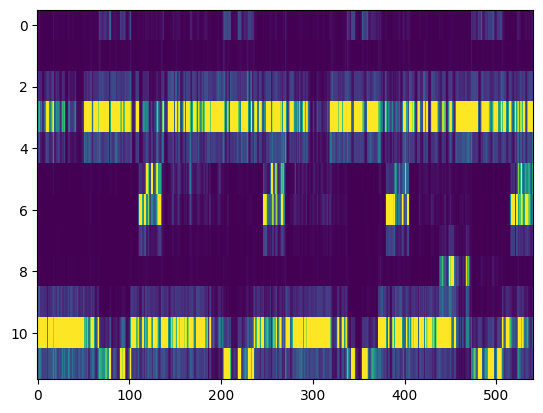

array([ 4.28925268e-02,  7.53055885e-03,  1.30799696e-01,  6.83138371e-01,
        1.58503160e-01,  9.04579684e-02,  1.42770022e-01,  3.27590741e-02,
        3.23623829e-02,  1.00854084e-01,  6.13468409e-01,  2.96926320e-01,
        1.05709943e-03,  2.24177478e-04,  4.31430992e-03,  1.55857308e-02,
        6.35685166e-03,  2.37612112e-04,  6.03840090e-05,  1.17687043e-04,
        1.61358301e-04,  4.56658861e-04,  5.22543536e-03,  1.53462738e-02,
        3.28889012e-01,  7.50696138e-02,  4.41935718e-01,  1.00000000e+00,
        5.70509017e-01,  1.00000000e+00,  1.00000000e+00,  2.73107618e-01,
        1.00000000e+00,  4.33658779e-01,  1.00000000e+00,  1.00000000e+00,
        8.71326483e-06,  5.94102348e-05,  4.46766680e-05,  1.94048684e-04,
        9.70807960e-05,  1.47652783e-04,  1.77833906e-04,  2.82112625e-04,
        3.74721654e-04,  5.25563897e-04,  2.10391125e-03,  1.99215058e-02,
        4.95481072e-03,  1.42470491e-03,  2.40984769e-03,  5.29949507e-03,
        1.42483106e-02,  

In [242]:
# from scipy.io import wavfile
# samplerate, data = wavfile.read('Audio_file.wav')

import os
import numpy as np
from tensorflow import keras
import librosa
from matplotlib import pyplot



# sin_data = np.sin(data)

# print (sin_data)

y, sr = librosa.load('Piano.wav') # D# piano

file_path = 'Masterplan.wav'
#extract_feature_means('Masterplan.wav')

def get_mfcc(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=30)
  mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr))
  return mfcc

example_file = "Piano.wav"
# mfcc = get_mfcc(example_file)
# pyplot.imshow(mfcc, interpolation='nearest', aspect='auto')
# pyplot.show()

def get_melspectrogram(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=30)
  melspectrogram = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
  return melspectrogram

melspectrogram = get_melspectrogram(example_file)
pyplot.imshow(melspectrogram, interpolation='nearest', aspect='auto')
pyplot.show()

def get_chroma_vector(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
  return chroma

chroma = get_chroma_vector(example_file)
pyplot.imshow(chroma, interpolation='nearest', aspect='auto')
pyplot.show()

def get_tonnetz(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  tonnetz = np.array(librosa.feature.tonnetz(y=y, sr=sr))
  return tonnetz

tntz = get_tonnetz(example_file)
pyplot.imshow(tntz , interpolation='nearest', aspect='auto')
pyplot.show()

def get_feature(file_path):
  # Extracting MFCC feature
  mfcc = get_mfcc(file_path)
  mfcc_mean = mfcc.mean(axis=1)
  mfcc_min = mfcc.min(axis=1)
  mfcc_max = mfcc.max(axis=1)
  mfcc_feature = np.concatenate( (mfcc_mean, mfcc_min, mfcc_max) )

  # Extracting Mel Spectrogram feature
  melspectrogram = get_melspectrogram(file_path)
  melspectrogram_mean = melspectrogram.mean(axis=1)
  melspectrogram_min = melspectrogram.min(axis=1)
  melspectrogram_max = melspectrogram.max(axis=1)
  melspectrogram_feature = np.concatenate( (melspectrogram_mean, melspectrogram_min, melspectrogram_max) )

  # Extracting chroma vector feature
  chroma = get_chroma_vector(file_path)
  chroma_mean = chroma.mean(axis=1)
  chroma_min = chroma.min(axis=1)
  chroma_max = chroma.max(axis=1)
  chroma_feature = np.concatenate( (chroma_mean, chroma_min, chroma_max) )

  # Extracting tonnetz feature
  tntz = get_tonnetz(file_path)
  tntz_mean = tntz.mean(axis=1)
  tntz_min = tntz.min(axis=1)
  tntz_max = tntz.max(axis=1)
  tntz_feature = np.concatenate( (tntz_mean, tntz_min, tntz_max) ) 
  
  feature = np.concatenate( (chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature) )
  return feature

features = get_feature(example_file)

len(features)

features



In [243]:
len(features)

498

# EXPERIMENTOWN 

In [244]:
len(prediction)
# decoded_images = tf.cast(decoded_images * 255.0, tf.uint8)

273

In [269]:
import cv2
type(prediction)

numpy.ndarray

In [246]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

In [253]:
type(prediction)
video_writer = cv2.VideoWriter('video.mp4', fourcc, 25.0, (108, 144))

In [256]:
for i in range(len(prediction)):
    image = prediction[i]
    image= cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    video_writer.write(image)

In [268]:
prediction.shape

(273, 108, 144, 3)

In [257]:
video_writer.release()

In [274]:
prediction.shape

(273, 108, 144, 3)

In [282]:
prediction = (prediction * 255).astype(np.uint8)

In [283]:
fps = 2
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (prediction.shape[2], prediction.shape[1]))
for i in range(aj.shape[0]):
    data = prediction[i, :, :, :]
    data = cv2.cvtColor(data, cv2.COLOR_RGB2BGR)
    out.write(data)
out.release()